In [274]:
import pandas as pd
import numpy as np
import os

In [275]:
matches = pd.read_csv("../../preparation_before_models/data/matches.csv")

In [276]:
matches['Date'] = pd.to_datetime(matches['Date'])
matches['year'] = matches['Date'].dt.year
matches = matches[matches['year'] > 2017]

In [277]:
# Check for missing values in the DataFrame
missing_values = matches.isnull().sum()

# Filter columns with missing values
columns_with_nan = missing_values[missing_values > 0]

# Display the columns and their corresponding NaN counts
print("Columns with NaN values and their counts:")
print(columns_with_nan)

Columns with NaN values and their counts:
player1_bet_odds    12
player2_bet_odds    12
dtype: int64


In [278]:
matches['Date'] = pd.to_datetime(matches['Date'])
matches['year'] = matches['Date'].dt.year
# Train: 2018–2021
train_matches = matches[matches['year'] <= 2021]

# Validation: 2022
val_matches = matches[matches['year'] == 2022]

# Test: 2023
test_matches = matches[matches['year'] == 2023]

In [168]:
matches = matches.drop(columns=["year", "Date"])

In [169]:
print(train_matches['year'].unique())  # Should print [2018, 2019, 2020, 2021]
print(val_matches['year'].unique())    # Should print [2022]
print(test_matches['year'].unique())   # Should print [2023]

[2018 2019 2020 2021]
[2022]
[2023]


In [170]:
import torch.nn as nn

In [171]:
list(matches.columns)

['outdoor',
 'player1_bet_odds',
 'player2_bet_odds',
 'tournament_level',
 'player1_right_handed',
 'player1_age',
 'player2_right_handed',
 'player2_age',
 'best_of',
 'player1_rank',
 'player2_rank',
 'player1_entry_LL',
 'player1_entry_Q',
 'player1_entry_WC',
 'player2_entry_LL',
 'player2_entry_Q',
 'player2_entry_WC',
 'player1_is_seeded',
 'player2_is_seeded',
 'w_ace_avg',
 'l_ace_avg',
 'w_CO_ace_avg',
 'l_CO_ace_avg',
 'w_df_avg',
 'l_df_avg',
 'w_CO_df_avg',
 'l_CO_df_avg',
 'w_2ndIn_avg',
 'l_2ndIn_avg',
 'w_CO_2ndIn_avg',
 'l_CO_2ndIn_avg',
 'player1_1st_serve_in_pct_avg',
 'player2_1st_serve_in_pct_avg',
 'player1_CO_1st_serve_in_pct_avg',
 'player2_CO_1st_serve_in_pct_avg',
 'player1_1st_serve_win_pct_avg',
 'player2_1st_serve_win_pct_avg',
 'player1_CO_1st_serve_win_pct_avg',
 'player2_CO_1st_serve_win_pct_avg',
 'player1_2nd_serve_in_pct_avg',
 'player2_2nd_serve_in_pct_avg',
 'player1_CO_2nd_serve_in_pct_avg',
 'player2_CO_2nd_serve_in_pct_avg',
 'player1_2nd_serve_w

In [172]:
weather_cols = ['temperature_2m', 'relative_humidity_2m','windspeed_10m','apparent_temperature']
#  and not ("avg" in col and "CO" not in col)
player1_cols = [col for col in matches.columns if col.startswith('player1_') and "bet" not in col]
player2_cols = [col for col in matches.columns if col.startswith('player2_') and "bet" not in col]
env_cols = [col for col in matches.columns if not  col.startswith('player') and col not in player1_cols and col not in player2_cols and "diff" not in col and "target" not in col and "bet" not in col and col not in weather_cols and "avg" not in col]
target_col = 'target'
player1_bet = 'player1_bet_odds'
player2_bet = 'player2_bet_odds'
env_cols

['outdoor',
 'tournament_level',
 'best_of',
 'non_CO_uncertainty',
 'CO_uncertainty',
 'Round_Num',
 'Surface_Clay',
 'Surface_Grass',
 'Surface_Hard']

In [173]:
# TRAIN
player1_train = train_matches[player1_cols].values
player2_train = train_matches[player2_cols].values
env_train = train_matches[env_cols].values
y_train = train_matches['target'].values  # Match outcome
player1_bet_odds_train = train_matches['player1_bet_odds'].values
player2_bet_odds_train = train_matches['player2_bet_odds'].values

# VALIDATION
player1_val = val_matches[player1_cols].values
player2_val = val_matches[player2_cols].values
env_val = val_matches[env_cols].values
y_val = val_matches['target'].values
player1_bet_odds_val = val_matches['player1_bet_odds'].values
player2_bet_odds_val = val_matches['player2_bet_odds'].values
uncertainty_val = val_matches['CO_uncertainty'].values

# TEST
player1_test = test_matches[player1_cols].values
player2_test = test_matches[player2_cols].values
env_test = test_matches[env_cols].values
y_test = test_matches['target'].values
player1_bet_odds_test = test_matches['player1_bet_odds'].values
player2_bet_odds_test = test_matches['player2_bet_odds'].values
uncertainty_test = test_matches['CO_uncertainty'].values



In [174]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scalers
player_scaler = MinMaxScaler()
env_scaler = MinMaxScaler()

# --- FIT SCALERS ONLY ON TRAINING DATA ---
player_scaler.fit(np.vstack([player1_train, player2_train]))
env_scaler.fit(env_train)

# --- SCALE TRAIN DATA ---
player1_train = player_scaler.transform(player1_train)
player2_train = player_scaler.transform(player2_train)
env_train = env_scaler.transform(env_train)

# --- SCALE VALIDATION DATA ---
player1_val = player_scaler.transform(player1_val)
player2_val = player_scaler.transform(player2_val)
env_val = env_scaler.transform(env_val)

# --- SCALE TEST DATA ---
player1_test = player_scaler.transform(player1_test)
player2_test = player_scaler.transform(player2_test)
env_test = env_scaler.transform(env_test)


In [175]:
import torch

# TRAIN
player1_train = torch.tensor(player1_train, dtype=torch.float32)
player2_train = torch.tensor(player2_train, dtype=torch.float32)
env_train = torch.tensor(env_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
player1_bet_odds_train = torch.tensor(player1_bet_odds_train, dtype=torch.float32)
player2_bet_odds_train = torch.tensor(player2_bet_odds_train, dtype=torch.float32)

# VALIDATION
player1_val = torch.tensor(player1_val, dtype=torch.float32)
player2_val = torch.tensor(player2_val, dtype=torch.float32)
env_val = torch.tensor(env_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
player1_bet_odds_val = torch.tensor(player1_bet_odds_val, dtype=torch.float32)
player2_bet_odds_val = torch.tensor(player2_bet_odds_val, dtype=torch.float32)
uncertainty_val = torch.tensor(uncertainty_val, dtype=torch.float32)


# TEST
player1_test = torch.tensor(player1_test, dtype=torch.float32)
player2_test = torch.tensor(player2_test, dtype=torch.float32)
env_test = torch.tensor(env_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
player1_bet_odds_test = torch.tensor(player1_bet_odds_test, dtype=torch.float32)
player2_bet_odds_test = torch.tensor(player2_bet_odds_test, dtype=torch.float32)
uncertainty_test = torch.tensor(uncertainty_test, dtype=torch.float32)


In [176]:
# from sklearn.model_selection import train_test_split
# 
# player1_train, player1_test, player2_train, player2_test, env_train, env_test, y_train, y_test, player1_bet_odds_train, player1_bet_odds_test, player2_bet_odds_train, player2_bet_odds_test = train_test_split(
#     player1_features, player2_features, env_features, match_outcomes, player1_bet_odds, player2_bet_odds, test_size=0.2, random_state=42, stratify=match_outcomes
# )
# player1_train, player1_val, player2_train, player2_val, env_train, env_val, y_train, y_val, player1_bet_odds_train, player1_bet_odds_val, player2_bet_odds_train, player2_bet_odds_val = train_test_split(
#     player1_train, player2_train, env_train, y_train, player1_bet_odds_train, player2_bet_odds_train, test_size=0.2, random_state=42, stratify=y_train
# )
# y_val.unique(return_counts=True)

In [177]:
class PlayerEmbeddingNet(nn.Module):
    def __init__(self, player_feature_size, embedding_size, dropout, hidden_sizes):
        super(PlayerEmbeddingNet, self).__init__()

        
        # Dynamically build the layers
        layers = []
        input_size = player_feature_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))  # Batch normalization
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))  # Regularization
            input_size = hidden_size
            
        # Add the final layer to project to the embedding size
        layers.append(nn.Linear(input_size, embedding_size))
        layers.append(nn.BatchNorm1d(embedding_size))  # Normalize embeddings

        # Define the network
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)  # Output: player embedding

In [178]:
class SymmetricNNWithEnvInteraction(nn.Module):
    def __init__(self, player_feature_size, env_feature_size, embedding_size, hidden_sizes, dropout, embedding_hidden_sizes=None):
        embedding_hidden_sizes = embedding_hidden_sizes if embedding_hidden_sizes else [32]

        """
        Args:
            player_feature_size (int): Number of features for each player.
            env_feature_size (int): Number of environmental features.
            embedding_size (int): Size of the player embedding.
            hidden_sizes (list[int]): List of hidden layer sizes. Each entry adds one hidden layer.
        """
        super(SymmetricNNWithEnvInteraction, self).__init__()
        
        # Shared subnetwork for player stats
        self.shared_player_net = PlayerEmbeddingNet(player_feature_size, embedding_size, dropout, embedding_hidden_sizes)
        
        # Dynamically build the final network
        layers = []
        input_size = embedding_size * 2 + env_feature_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))  # Hidden layer
            layers.append(nn.SiLU())                          # Activation
            layers.append(nn.Dropout(dropout))                    # Dropout
            input_size = hidden_size  # Update input size for the next layer
        
        # Output layer
        layers.append(nn.Linear(input_size, 1))  # Final layer
        layers.append(nn.Sigmoid())             # Output probability
        
        self.final_net = nn.Sequential(*layers)

    def forward(self, player1_features, player2_features, env_features):
        # Generate embeddings for both players
        player1_emb = self.shared_player_net(player1_features)
        player2_emb = self.shared_player_net(player2_features)
        
        # Combine embeddings symmetrically
        combined_embedding = torch.cat([
            player1_emb - player2_emb,
            torch.abs(player1_emb - player2_emb),
        ], dim=1)
        
        # Concatenate with environmental features
        final_input = torch.cat([combined_embedding, env_features], dim=1)
        
        # Pass through the dynamically built final network
        return self.final_net(final_input)


In [179]:
class SymmetricNNWithoutEmbeddings(nn.Module):
    def __init__(self, player_feature_size, env_feature_size, hidden_sizes, dropout):
        super(SymmetricNNWithoutEmbeddings, self).__init__()

        # Input size: concatenated features of both players + environment
        input_size = 2 * player_feature_size + env_feature_size

        # Define layers dynamically
        layers = []
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))  # Hidden layer
            layers.append(nn.ReLU())                          # Activation
            layers.append(nn.Dropout(dropout))                # Dropout
            input_size = hidden_size

        # Final output layer
        layers.append(nn.Linear(input_size, 1))  # Single output (probability)
        layers.append(nn.Sigmoid())              # Sigmoid activation for probabilities

        self.network = nn.Sequential(*layers)

    def forward(self, p1_features, p2_features, env_features):
        # Concatenate features for (P1, P2)
        input_1 = torch.cat([p1_features, p2_features, env_features], dim=1)

        # Concatenate features for (P2, P1)
        input_2 = torch.cat([p2_features, p1_features, env_features], dim=1)

        # Compute probabilities for both orders
        prob_1 = self.network(input_1)
        prob_2 = self.network(input_2)

        # Average the probabilities
        return (prob_1 + 1 - prob_2) / 2


In [180]:
def calculate_kelly_fraction(p, odds):
    if odds > 1:
        b = odds - 1  # Adjust odds to represent decimal profit
        f = (p * b - (1 - p)) / b
        return max(f, 0)  # Only bet if f > 0
    return 0

In [181]:
def calculate_roi(predictions, avgW, avgL, y_true, initial_budget=1000, max_bet=50):
    total_budget = initial_budget
    total_bet = 0
    net_profit = 0

    # flat_predictions = [item[0] for item in predictions]  # Flatten predictions
    flat_avgW = [item[0] for item in avgW]               # Flatten avgW
    flat_avgL = [item[0] for item in avgL]               # Flatten avgL
    # flat_y_true = [item[0] for item in y_true]           # Flatten y_true
    bets_made = 0

    for prob, odds_w, odds_l, actual in zip(predictions, flat_avgW, flat_avgL, y_true):
        # Your logic here
        if odds_w is None or odds_l is None:
            continue
        # Decide the bet
        if prob >= 0.5:  # Predicted winner
            odds = odds_w
            kelly_fraction = calculate_kelly_fraction(prob, odds)
            outcome = 1 if actual == 1 else -1
        else:  # Predicted loser
            odds = odds_l
            kelly_fraction = calculate_kelly_fraction(1 - prob, odds)
            outcome = 1 if actual == 0 else -1
        kelly_scale = 5
        # Fixed max bet
        scaled_fraction = kelly_fraction / kelly_scale
        bet_amount = min(max_bet, scaled_fraction * initial_budget)        
        if bet_amount > 0:
            bets_made+=1
            total_bet += bet_amount
            if outcome == 1:  # Bet won
                net_profit += bet_amount * (odds - 1)
                total_budget += bet_amount * (odds - 1)
            else:  # Bet lost
                net_profit -= bet_amount
                total_budget -= bet_amount
    roi = net_profit / initial_budget if total_bet > 0 else 0
    return roi

In [182]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        """
        Args:
            alpha (float): Weighting factor for positive class (1).
            gamma (float): Focusing parameter to adjust the penalty for easy examples.
            reduction (str): 'mean', 'sum', or 'none'.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Args:
            inputs: Predicted probabilities (output of sigmoid).
            targets: Ground-truth labels (0 or 1).
        """
        # Compute binary cross-entropy
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction="none")

        # Compute focal weight
        pt = torch.where(targets == 1, inputs, 1 - inputs)  # pt is probability for the true class
        focal_weight = (self.alpha * targets + (1 - self.alpha) * (1 - targets)) * (1 - pt) ** self.gamma

        # Apply focal weight
        loss = focal_weight * BCE_loss

        # Reduction: mean, sum, or none
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss


In [183]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch
import random
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split
# Set random seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

2590
Epoch 1: Validation Brier Score: 0.2536
Epoch 2: Validation Brier Score: 0.2545
Epoch 3: Validation Brier Score: 0.2545
Epoch 4: Validation Brier Score: 0.2544
Epoch 5: Validation Brier Score: 0.2543
Epoch 6: Validation Brier Score: 0.2542
Epoch 7: Validation Brier Score: 0.2541
Epoch 8: Validation Brier Score: 0.2542
Epoch 9: Validation Brier Score: 0.2541
Epoch 10: Validation Brier Score: 0.2540
Epoch 11: Validation Brier Score: 0.2539
Epoch 12: Validation Brier Score: 0.2537
Epoch 13: Validation Brier Score: 0.2538
Epoch 14: Validation Brier Score: 0.2537
Epoch 15: Validation Brier Score: 0.2536
Epoch 16: Validation Brier Score: 0.2536
Epoch 17: Validation Brier Score: 0.2534
Epoch 18: Validation Brier Score: 0.2534
Epoch 19: Validation Brier Score: 0.2533
Epoch 20: Validation Brier Score: 0.2533
Epoch 21: Validation Brier Score: 0.2532
Epoch 22: Validation Brier Score: 0.2532
Epoch 23: Validation Brier Score: 0.2531
Epoch 24: Validation Brier Score: 0.2529
Epoch 25: Validation

C:\Users\Pawel\AppData\Local\Temp\ipykernel_14436\735816131.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


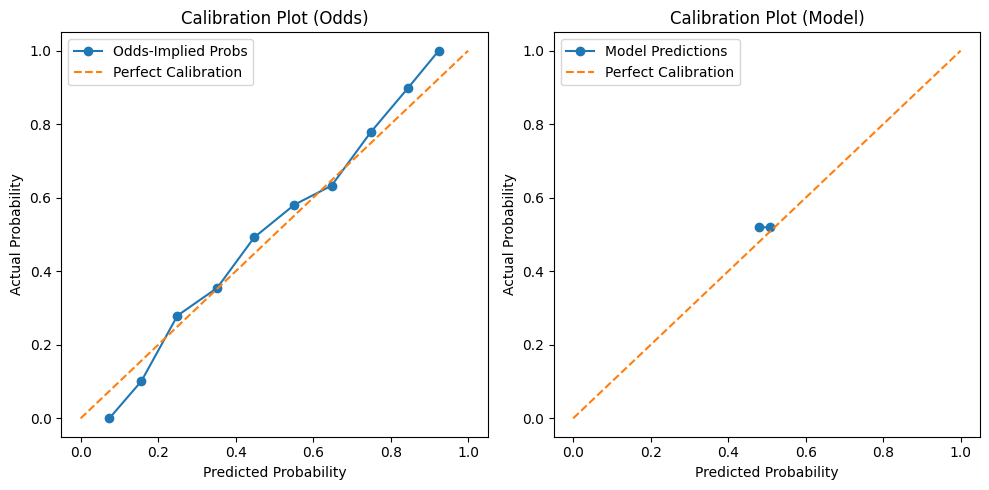

In [185]:

## ---- CONFIGURATION ----
# config = {
#     'batch_size': 32,
#     'dropout': np.float64(0.19),
#     'hidden_layer_sizes': [128, 64, 32, 16],
#     'learning_rate': np.float64(0.0009360972595363841),
#     'weight_decay': np.float64(3.735731579186841e-06),
#     'epochs': 50,
# }

#{'hidden_layers': 8, 'embedding_hidden_layers': 2, 'embedding_size': 16, 'dropout': 0.36826214072757374, 'lr': 5.975027999960295e-06, 'weight_decay': 2.1137059440645735e-05, 'batch_size': 512}
reset_seeds(42)

config = {
    'batch_size': 512,
    'dropout': np.float64(0.36826214072757374),
    'hidden_layer_sizes': [64, 32, 16],
    'learning_rate': np.float64(5.975027999960295e-06),
    'weight_decay': np.float64(2.1137059440645735e-05),
    'epochs': 50,
}

# ---- DATA PREPARATION ----
# train_dataset = TensorDataset(player1_train, player2_train, env_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True)
# 
# val_dataset = TensorDataset(
#     player1_val, player2_val, env_val, y_val, player1_bet_odds_val, player2_bet_odds_val, uncertainty_val
# )
# val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=False)
fold_4_train_data = train_data.loc[train_data["year"].isin([2018, 2019, 2020, 2021])]
fold_4_val_data   = train_data.loc[train_data["year"] == 2022]

train_loader, val_loader = prepare_dataloaders(
    fold_4_train_data, 
    fold_4_val_data,
    player1_cols, 
    player2_cols, 
    env_cols, 
    batch_size=512
)
print(len(val_loader.dataset))
# ---- MODEL INITIALIZATION ----
model = SymmetricNNWithEnvInteraction(
    player_feature_size=player1_train.shape[1],
    env_feature_size=env_train.shape[1],
    hidden_sizes=config['hidden_layer_sizes'],
    embedding_size=16,
    embedding_hidden_sizes=[32, 16],
    dropout=config['dropout']
)

# ---- INITIALIZATION ----
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(initialize_weights)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.4)

# ---- OPTIMIZER AND LOSS ----
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
criterion = nn.BCELoss()

# ---- TRAINING ----
best_val_brier = float('inf')
best_epoch = 0
for epoch in range(config['epochs']):
    # ---- TRAIN ----
    model.train()
    epoch_loss = 0.0
    for p1, p2, env, labels in train_loader:
        optimizer.zero_grad()
        predictions = model(p1, p2, env)
        loss = criterion(predictions, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    cpu_rng_state = torch.get_rng_state()

    # ---- VALIDATION ----
    model.eval()
    val_predictions, val_y_true, betting_probs, val_uncertainty = [], [], [], []

    with torch.no_grad():
        for p1, p2, env, labels, avgW, avgL, unc in val_loader:
            predictions = model(p1, p2, env)
            val_predictions.extend(predictions.tolist())
            val_y_true.extend(labels.tolist())
            val_uncertainty.extend(unc.tolist())

            # Betting probabilities
            probW = 1 / avgW
            probL = 1 / avgL
            total_prob = probW + probL
            probW /= total_prob
            betting_probs.extend(probW.tolist())

    # ---- VALIDATION METRICS ----
    betting_probs = np.array(betting_probs).ravel()
    val_y_true = np.array(val_y_true).ravel()
    val_predictions = np.array(val_predictions).ravel()

    # Validation Brier Score
    brier = brier_score_loss(val_y_true, val_predictions)
    print(f"Epoch {epoch + 1}: Validation Brier Score: {brier:.4f}")
    scheduler.step(brier)

    if brier < best_val_brier:
        best_val_brier = brier
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pth')
    torch.set_rng_state(cpu_rng_state)

print(f"Best epoch: {best_epoch + 1}, Best Validation Brier: {best_val_brier:.4f}")

# ---- TEST EVALUATION ----
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Prepare Test DataLoader
test_dataset = TensorDataset(
    player1_test, player2_test, env_test, y_test, player1_bet_odds_test, player2_bet_odds_test, uncertainty_test
)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=False)

# Evaluate on Test Set
test_predictions, test_y_true, test_avgW, test_avgL, test_uncertainty = [], [], [], [], []

with torch.no_grad():
    for p1, p2, env, labels, avgW, avgL, unc in test_loader:
        predictions = model(p1, p2, env)
        test_predictions.extend(predictions.tolist())
        test_y_true.extend(labels.tolist())
        test_avgW.extend(avgW.tolist())
        test_avgL.extend(avgL.tolist())
        test_uncertainty.extend(unc.tolist())

# ---- UNCERTAINTY FILTERING ----
test_predictions = np.array(test_predictions).ravel()
test_y_true = np.array(test_y_true).ravel()
test_uncertainty = np.array(test_uncertainty)

unc_threshold = np.percentile(test_uncertainty, 50)
mask = test_uncertainty <= unc_threshold

filtered_predictions = test_predictions[mask]
filtered_labels = test_y_true[mask]
filtered_avgW = np.array(test_avgW)[mask]
filtered_avgL = np.array(test_avgL)[mask]

filtered_probW = 1 / filtered_avgW
filtered_probL = 1 / filtered_avgL
filtered_total_prob = filtered_probW + filtered_probL
filtered_probW /= filtered_total_prob
filtered_probW = np.where(np.isnan(filtered_probW), 0.5, filtered_probW)

# ---- METRICS ----
filtered_brier_odds = brier_score_loss(filtered_labels, filtered_probW)
filtered_brier_model = brier_score_loss(filtered_labels, filtered_predictions)

print(f"Filtered Brier Score (Odds): {filtered_brier_odds:.4f}")
print(f"Filtered Brier Score (Model): {filtered_brier_model:.4f}")

# ---- CALIBRATION PLOTS ----
prob_true_odds, prob_pred_odds = calibration_curve(filtered_labels, filtered_probW, n_bins=10)
prob_true_model, prob_pred_model = calibration_curve(filtered_labels, filtered_predictions, n_bins=10)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(prob_pred_odds, prob_true_odds, marker='o', label='Odds-Implied Probs')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.title('Calibration Plot (Odds)')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Probability')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(prob_pred_model, prob_true_model, marker='o', label='Model Predictions')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.title('Calibration Plot (Model)')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Probability')
plt.legend()

plt.tight_layout()
plt.show()


## Optimization

In [217]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import brier_score_loss
from torch.optim.lr_scheduler import ReduceLROnPlateau

def reset_seeds(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

In [218]:
def year_based_cv(df, start_year, end_year, year_col="year"):
    """
    A generator that yields (train_idx, val_idx) for year-based folds,
    e.g. (Train up to 'year', Validate on 'year').
    
    Example:
        If start_year=2018, end_year=2022,
        it yields folds:
          Fold 1 -> Train=[2018],        Val=[2019]
          Fold 2 -> Train=[2018,2019],   Val=[2020]
          Fold 3 -> Train=[2018-2020],   Val=[2021]
          Fold 4 -> Train=[2018-2021],   Val=[2022]
    """
    all_years = sorted(df[year_col].unique())
    # Filter to years we care about
    all_years = [y for y in all_years if (y >= start_year and y <= end_year)]
    
    # We'll generate folds: train up to but not including current year, validate on current year
    for i in range(0, len(all_years) - 1):
        train_years = all_years[:i+1]
        val_year = all_years[i+1]
        
        train_idx = df.index[df[year_col].isin(train_years)]
        val_idx   = df.index[df[year_col] == val_year]
        
        yield (train_idx, val_idx)


In [280]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

def prepare_dataloaders(
    train_fold, 
    val_fold, 
    player1_cols, 
    player2_cols, 
    env_cols, 
    batch_size=64, 
    test_fold=None
):
    reset_seeds(42)
    
    # Scalers
    player_scaler = MinMaxScaler()
    env_scaler = MinMaxScaler()

    # Split out columns for train
    p1_train = train_fold[player1_cols].values
    p2_train = train_fold[player2_cols].values
    env_train = train_fold[env_cols].values
    y_train = train_fold["target"].values

    # Split out columns for val
    p1_val = val_fold[player1_cols].values
    p2_val = val_fold[player2_cols].values
    env_val = val_fold[env_cols].values
    y_val = val_fold["target"].values
    unc_val = val_fold['CO_uncertainty'].values

    # Fit scalers on the training set only
    p1_train = player_scaler.fit_transform(p1_train)
    p2_train = player_scaler.transform(p2_train)
    env_train = env_scaler.fit_transform(env_train)

    # Transform validation set
    p1_val = player_scaler.transform(p1_val)
    p2_val = player_scaler.transform(p2_val)
    env_val = env_scaler.transform(env_val)

    # Build datasets
    train_dataset = TensorDataset(
        torch.tensor(p1_train, dtype=torch.float32),
        torch.tensor(p2_train, dtype=torch.float32),
        torch.tensor(env_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1),
    )
    val_dataset = TensorDataset(
        torch.tensor(p1_val, dtype=torch.float32),
        torch.tensor(p2_val, dtype=torch.float32),
        torch.tensor(env_val, dtype=torch.float32),
        torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1),
        torch.tensor(unc_val, dtype=torch.float32),
    )

    # Build loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    if test_fold is not None:
        p1_test = test_fold[player1_cols].values
        p2_test = test_fold[player2_cols].values
        env_test = test_fold[env_cols].values
        y_test = test_fold["target"].values
        unc_test = test_fold['CO_uncertainty'].values
        player1_bet_odds_test = test_fold['player1_bet_odds'].values
        player2_bet_odds_test = test_fold['player2_bet_odds'].values
        match_id_test = test_fold["match_id"].values
        match_id_test_key = np.arange(len(test_fold))

        # Transform test set with the same scalers fitted on train
        p1_test = player_scaler.transform(p1_test)
        p2_test = player_scaler.transform(p2_test)
        env_test = env_scaler.transform(env_test)

        test_dataset = TensorDataset(
            torch.tensor(p1_test, dtype=torch.float32),
            torch.tensor(p2_test, dtype=torch.float32),
            torch.tensor(env_test, dtype=torch.float32),
            torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1),
            torch.tensor(unc_test, dtype=torch.float32),
            torch.tensor(player1_bet_odds_test, dtype=torch.float32),
            torch.tensor(player2_bet_odds_test, dtype=torch.float32),
            torch.tensor(match_id_test_key, dtype=torch.int32),
        )
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

        return train_loader, val_loader, test_loader, match_id_test

    return train_loader, val_loader


In [236]:
from copy import deepcopy
def train_and_evaluate(
    train_data,
    val_data,
    player1_cols, 
    player2_cols, 
    env_cols,
    hidden_sizes,
    embedding_size,
    embedding_hidden_sizes,
    dropout,
    lr,
    weight_decay,
    batch_size,
    epochs=50,
):
    # Reset seeds so we get consistent runs
    reset_seeds(42)

    # Build loaders
    train_loader, val_loader = prepare_dataloaders(
        train_data, val_data,
        player1_cols, player2_cols, env_cols,
        batch_size=batch_size,
    )

    # Build model
    model = SymmetricNNWithEnvInteraction(
        player_feature_size=len(player1_cols),
        env_feature_size=len(env_cols),
        hidden_sizes=hidden_sizes,
        embedding_size=embedding_size,
        embedding_hidden_sizes=embedding_hidden_sizes,
        dropout=dropout
    )
    model.apply(initialize_weights)

    # Optimizer, scheduler, etc.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.4)
    criterion = nn.BCELoss()

    best_score = float('inf')
    best_model_state = None
    for epoch in range(epochs):
        # Train
        model.train()
        for p1, p2, env, labels in train_loader:
            optimizer.zero_grad()
            preds = model(p1, p2, env)
            loss = criterion(preds, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        cpu_rng_state = torch.get_rng_state()
        # Validate
        model.eval()
        val_preds, val_truth = [], []
        with torch.no_grad():
            for p1, p2, env, labels, unc in val_loader:
                preds = model(p1, p2, env)
                val_preds.extend(preds.squeeze().tolist())
                val_truth.extend(labels.squeeze().tolist())

        brier = brier_score_loss(np.array(val_truth), np.array(val_preds))
        scheduler.step(brier)
        if brier < best_score:
            best_score = brier
            best_model_state = deepcopy(model.state_dict())
        torch.set_rng_state(cpu_rng_state)
        
    best_model = SymmetricNNWithEnvInteraction(
        player_feature_size=len(player1_cols),
        env_feature_size=len(env_cols),
        hidden_sizes=hidden_sizes,
        embedding_size=embedding_size,
        embedding_hidden_sizes=embedding_hidden_sizes,
        dropout=dropout
    )    
    best_model.load_state_dict(best_model_state)
    return best_score, best_model

In [254]:
from copy import deepcopy
def train_and_evaluate_no_embedding(
    train_data,
    val_data,
    player1_cols, 
    player2_cols, 
    env_cols,
    hidden_sizes,
    dropout,
    lr,
    weight_decay,
    batch_size,
    epochs=50,
):
    # Reset seeds so we get consistent runs
    reset_seeds(42)

    # Build loaders
    train_loader, val_loader = prepare_dataloaders(
        train_data, val_data,
        player1_cols, player2_cols, env_cols,
        batch_size=batch_size,
    )

    # Build model
    model = SymmetricNNWithoutEmbeddings(
        player_feature_size=len(player1_cols),
        env_feature_size=len(env_cols),
        hidden_sizes=hidden_sizes,
        dropout=dropout
    )
    model.apply(initialize_weights)

    # Optimizer, scheduler, etc.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.4)
    criterion = nn.BCELoss()

    best_score = float('inf')
    best_model_state = None
    for epoch in range(epochs):
        # Train
        model.train()
        for p1, p2, env, labels in train_loader:
            optimizer.zero_grad()
            preds = model(p1, p2, env)
            loss = criterion(preds, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        cpu_rng_state = torch.get_rng_state()
        # Validate
        model.eval()
        val_preds, val_truth = [], []
        with torch.no_grad():
            for p1, p2, env, labels, unc in val_loader:
                preds = model(p1, p2, env)
                val_preds.extend(preds.squeeze().tolist())
                val_truth.extend(labels.squeeze().tolist())

        brier = brier_score_loss(np.array(val_truth), np.array(val_preds))
        scheduler.step(brier)
        if brier < best_score:
            best_score = brier
            best_model_state = deepcopy(model.state_dict())
        torch.set_rng_state(cpu_rng_state)
        
    best_model = SymmetricNNWithoutEmbeddings(
        player_feature_size=len(player1_cols),
        env_feature_size=len(env_cols),
        hidden_sizes=hidden_sizes,
        dropout=dropout
    )    
    best_model.load_state_dict(best_model_state)
    return best_score, best_model

In [281]:
def train_val_test(
    train_data,
    val_data,
    test_data,
    with_embedding=True, **hyperparams
):
    """
    1) Train a model on (train_data, val_data) using `train_and_evaluate`.
    2) Evaluate on test_data with multiple metrics.
    3) Compare model predictions to bet-odds predictions.
    """

    # ---- 1) Train on (train_data, val_data) ----
    if with_embedding:
        best_val_score, model = train_and_evaluate(
            train_data=train_data,
            val_data=val_data,
            **hyperparams
        )
    else: 
         best_val_score, model = train_and_evaluate_no_embedding(
            train_data=train_data,
            val_data=val_data,
            **hyperparams
        )
    print(f"[train_val_test] Best Validation Score: {best_val_score:.4f}")

    # ---- 2) Prepare a test loader with your `test_fold` ----
    #    We'll only use the test_loader from prepare_dataloaders (with test_fold)
    #    The train and val folds can be placeholders, e.g. train_data, val_data again,
    #    since we won't reuse those loaders; we only need test_loader now.
    #    Because your function returns (train_loader, val_loader, test_loader) if test_fold != None

    # Dummy: we just pass the same train_data/val_data, plus test_data in `test_fold`
    # We'll only actually use the test_loader
    _, _, test_loader, match_ids = prepare_dataloaders(
        train_data, # or any placeholders, since we're not using them here
        val_data,
        player1_cols,
        player2_cols,
        env_cols,
        batch_size=hyperparams['batch_size'],
        test_fold=test_data  # <--- Here's our real test fold
    )

    # ---- 3) Evaluate on the test set ----
    model.eval()
    with torch.no_grad():
        test_preds = []
        test_labels = []
        odds1_list = []
        odds2_list = []
        test_uncs = []
        match_id_keys = []
    
        for p1, p2, env, labels, unc, odds1, odds2, match_id_key in test_loader:
            # Model predictions
            preds = model(p1, p2, env).squeeze(-1).tolist()
            test_preds.extend(preds)
    
            # True labels
            test_labels.extend(labels.squeeze(-1).tolist())
    
            # Bet odds
            odds1_list.extend(odds1.tolist())
            odds2_list.extend(odds2.tolist())
    
            # Uncertainty
            test_uncs.extend(unc.tolist())
            
            match_id_keys.extend(match_id_key.tolist())
    match_ids = [match_ids[i] for i in match_id_keys]
    # Convert to NumPy
    test_preds = np.array(test_preds)
    test_labels = np.array(test_labels)
    odds1_list  = np.array(odds1_list)
    odds2_list  = np.array(odds2_list)
    test_uncs   = np.array(test_uncs)
    match_ids   = np.array(match_ids)
    
    ##############################################################################
    # 1) Compute overall Brier scores (no filtering)
    ##############################################################################
    # (a) Model’s Brier
    overall_model_brier = brier_score_loss(test_labels, test_preds)
    
    # (b) Odds-based probability
    probW = 1.0 / odds1_list
    probL = 1.0 / odds2_list
    total_prob = probW + probL
    # Handle division by zero => 0.5
    probW = np.divide(probW, total_prob, out=np.full_like(probW, 0.5), where=(total_prob != 0))
    # Replace any NaN with 0.5
    probW = np.where(np.isnan(probW), 0.5, probW)
    
    overall_odds_brier = brier_score_loss(test_labels, probW)
    
    print(f"Overall Test Brier (Model): {overall_model_brier:.4f}")
    print(f"Overall Test Brier (Odds):  {overall_odds_brier:.4f}")
    
    ##############################################################################
    # 2) Uncertainty Filtering
    ##############################################################################
    # Example: keep only the bottom 50% in terms of uncertainty
    unc_threshold = np.percentile(test_uncs, 50)  # e.g. 50th percentile
    is_uncertain = test_uncs > unc_threshold  # Mask for rows > 50% uncertainty
    results_df = pd.DataFrame({
        "match_id": match_ids,
        "true_label": test_labels,
        "model_prediction": test_preds,
        "odds_prediction": probW,
        "uncertain": is_uncertain  # True if in top 50% uncertainty
    })
    
    mask = test_uncs <= unc_threshold
    
    # Filter arrays
    filtered_preds   = test_preds[mask]
    filtered_labels  = test_labels[mask]
    filtered_odds1   = odds1_list[mask]
    filtered_odds2   = odds2_list[mask]
    
    ##############################################################################
    # 3) Compute Brier scores on the filtered set
    ##############################################################################
    # (a) Model’s Brier on filtered set
    filtered_model_brier = brier_score_loss(filtered_labels, filtered_preds)
    
    # (b) Odds-based probability on filtered set
    f_probW = 1.0 / filtered_odds1
    f_probL = 1.0 / filtered_odds2
    f_total = f_probW + f_probL
    f_probW = np.divide(f_probW, f_total, out=np.full_like(f_probW, 0.5), where=(f_total != 0))
    f_probW = np.where(np.isnan(f_probW), 0.5, f_probW)
    
    filtered_odds_brier = brier_score_loss(filtered_labels, f_probW)
    
    print(f"Filtered Test Brier (Model, uncertainty ≤ {unc_threshold:.3f}): {filtered_model_brier:.4f}")
    print(f"Filtered Test Brier (Odds,  uncertainty ≤ {unc_threshold:.3f}): {filtered_odds_brier:.4f}")
    
    
    # Return them if needed
    return model,  {
        "best_val_score": best_val_score,
        "test_model_brier": filtered_model_brier,
        "test_odds_brier": filtered_odds_brier,
        # You could also return `model` if you want to use it later
    }, results_df


In [245]:
results = train_val_test(
    train_data=train_matches,
    val_data=val_matches,
    test_data=test_matches,
    player1_cols=player1_cols,
    player2_cols=player2_cols,
    env_cols=env_cols,
    hidden_sizes=[128, 64],
    embedding_size=8,
    embedding_hidden_sizes=[],
    dropout=0.2,
    lr=1e-4,
    weight_decay=1e-6,
    batch_size=64,
    epochs=50
)

print(results)

[train_val_test] Best Validation Score: 0.2105
Overall Test Brier (Model): 0.2152
Overall Test Brier (Odds):  0.2038
Filtered Test Brier (Model, uncertainty ≤ 0.041): 0.2090
Filtered Test Brier (Odds,  uncertainty ≤ 0.041): 0.1993
{'best_val_score': np.float64(0.21046613064692796), 'test_model_brier': np.float64(0.2090339507903058), 'test_odds_brier': np.float64(0.1993313787181954)}


In [256]:
def run_cv(train_data, start_year=2018, end_year=2022,  with_embedding=True, **hyperparams):
    scores = []
    for fold, (train_idx, val_idx) in enumerate(year_based_cv(train_data, start_year, end_year), 1):
        print(f"Fold {fold}")
        reset_seeds(42)
        train_fold = train_data.iloc[train_idx]
        val_fold   = train_data.iloc[val_idx]
        if with_embedding:
            fold_score, _ = train_and_evaluate(train_fold, val_fold, **hyperparams)
        else:
            fold_score, _ = train_and_evaluate_no_embedding(train_fold, val_fold, **hyperparams)
        print(f"Fold {fold} best brier: {fold_score:.4f}")
        scores.append(fold_score)
    return np.mean(scores)

In [257]:
# {'hidden_layers': 9, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.3319666033007586, 'lr': 0.0008865455568460776, 'weight_decay': 1.402258931419471e-05, 'batch_size': 32}
hyperparams = {
    "player1_cols": player1_cols,    
    "player2_cols": player2_cols,  
    "env_cols": env_cols,
    "hidden_sizes": [128, 64],
    "embedding_size": 8,
    "embedding_hidden_sizes": [],
    "dropout": 0.3319666033007586,
    "lr": 0.0008865455568460776,
    "weight_decay": 1.402258931419471e-05,
    "batch_size": 32,
    "epochs": 50,
}

# CROSS-VAL with year-based folds:
cv_score = run_cv(matches, 2018, 2022, **hyperparams)
print(f"Average CV score: {cv_score:.4f}")

# SINGLE FOLD (like fold 4):
fold_4_train_data = matches.loc[matches["year"].isin([2018, 2019, 2020, 2021])]
fold_4_val_data   = matches.loc[matches["year"] == 2022]
fold_4_score = train_and_evaluate(fold_4_train_data, fold_4_val_data, **hyperparams)
print(f"Fold 4 single-run score: {fold_4_score:.4f}")

Fold 1


KeyboardInterrupt: 

In [213]:
import optuna
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import brier_score_loss
from optuna.samplers import TPESampler
sampler = TPESampler(seed=42)  # Fix the seed here
# Set random seed for reproducibility
reset_seeds(42)
hidden_layer_options = {
    0: [1024],
    1: [512, 256],
    2: [1024, 512],
    3: [512, 256, 128],
    4: [128, 64, 32],
    5: [512],
    6: [256],
    7: [128],
    8: [64, 32, 16],
    9: [128, 64],
}
embedding_layer_options = {
    0: [],
    1: [16],
    2: [32, 16],
    3: [64, 32, 16]
}
# Objective function for Optuna optimization
def objective(trial):
    reset_seeds(42)


    # Hyperparameters to optimize
    hidden_layer_key = trial.suggest_categorical("hidden_layers", [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    embedding_hidden_key = trial.suggest_categorical("embedding_hidden_layers", [0, 1, 2, 3])
    embedding_size = trial.suggest_categorical("embedding_size", [8, 16, 32])
    dropout = trial.suggest_float("dropout", 0.05, 0.4)
    lr = trial.suggest_float("lr", 1e-6, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256, 512, 1024])
    
    hidden_layers = hidden_layer_options[hidden_layer_key]
    embedding_hidden_sizes = embedding_layer_options[embedding_hidden_key]
    hyperparams = dict(
        player1_cols=player1_cols,
        player2_cols=player2_cols,
        env_cols=env_cols,
        hidden_sizes=hidden_layers,
        embedding_size=embedding_size,
        embedding_hidden_sizes=embedding_hidden_sizes,
        dropout=dropout,
        lr=lr,
        weight_decay=weight_decay,
        batch_size=batch_size,
        epochs=50,
    )
    
    # Run CV
    score = run_cv(train_data, 2018, 2022, **hyperparams)
    return score
    

# Optuna optimization
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=100, n_jobs=1)

# Print best parameters
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)


[I 2024-12-31 15:47:17,528] A new study created in memory with name: no-name-047362d3-06ab-4ce9-858f-b7b365e4209d


Fold 1
Fold 1 best brier: 0.2320
Fold 2
Fold 2 best brier: 0.2190
Fold 3
Fold 3 best brier: 0.2208
Fold 4


[I 2024-12-31 15:47:46,705] Trial 0 finished with value: 0.222020139913016 and parameters: {'hidden_layers': 1, 'embedding_hidden_layers': 1, 'embedding_size': 32, 'dropout': 0.23366475107128326, 'lr': 1.9762189340280066e-05, 'weight_decay': 3.823475224675187e-06, 'batch_size': 1024}. Best is trial 0 with value: 0.222020139913016.


Fold 4 best brier: 0.2164
Fold 1
Fold 1 best brier: 0.2501
Fold 2
Fold 2 best brier: 0.2510
Fold 3
Fold 3 best brier: 0.2523
Fold 4


[I 2024-12-31 15:48:13,396] Trial 1 finished with value: 0.2517448855251101 and parameters: {'hidden_layers': 8, 'embedding_hidden_layers': 2, 'embedding_size': 16, 'dropout': 0.36826214072757374, 'lr': 5.975027999960295e-06, 'weight_decay': 2.1137059440645735e-05, 'batch_size': 512}. Best is trial 0 with value: 0.222020139913016.


Fold 4 best brier: 0.2536
Fold 1
Fold 1 best brier: 0.2222
Fold 2
Fold 2 best brier: 0.2160
Fold 3
Fold 3 best brier: 0.2162
Fold 4


[I 2024-12-31 15:49:18,576] Trial 2 finished with value: 0.21622345545071114 and parameters: {'hidden_layers': 0, 'embedding_hidden_layers': 0, 'embedding_size': 16, 'dropout': 0.3954104278101811, 'lr': 0.00020736445177905034, 'weight_decay': 2.4970737145052737e-06, 'batch_size': 64}. Best is trial 2 with value: 0.21622345545071114.


Fold 4 best brier: 0.2105
Fold 1
Fold 1 best brier: 0.2288
Fold 2
Fold 2 best brier: 0.2228
Fold 3
Fold 3 best brier: 0.2204
Fold 4


[I 2024-12-31 15:50:04,977] Trial 3 finished with value: 0.22191875943048203 and parameters: {'hidden_layers': 2, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.22282845872753676, 'lr': 3.69997243146381e-05, 'weight_decay': 7.1627869998973385e-06, 'batch_size': 256}. Best is trial 2 with value: 0.21622345545071114.


Fold 4 best brier: 0.2157
Fold 1
Fold 1 best brier: 0.2509
Fold 2
Fold 2 best brier: 0.2497
Fold 3
Fold 3 best brier: 0.2468
Fold 4


[I 2024-12-31 15:50:35,309] Trial 4 finished with value: 0.2482277914784334 and parameters: {'hidden_layers': 8, 'embedding_hidden_layers': 1, 'embedding_size': 8, 'dropout': 0.36363195497322265, 'lr': 8.995191735587168e-06, 'weight_decay': 1.6599837974449216e-06, 'batch_size': 256}. Best is trial 2 with value: 0.21622345545071114.


Fold 4 best brier: 0.2454
Fold 1
Fold 1 best brier: 0.2573
Fold 2
Fold 2 best brier: 0.2649
Fold 3
Fold 3 best brier: 0.2674
Fold 4


[I 2024-12-31 15:51:00,642] Trial 5 finished with value: 0.2667750249908366 and parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.22593765813010153, 'lr': 1.4270403521460851e-06, 'weight_decay': 3.608219327363785e-06, 'batch_size': 512}. Best is trial 2 with value: 0.21622345545071114.


Fold 4 best brier: 0.2775
Fold 1
Fold 1 best brier: 0.2262
Fold 2
Fold 2 best brier: 0.2188
Fold 3
Fold 3 best brier: 0.2173
Fold 4


[I 2024-12-31 15:51:53,518] Trial 6 finished with value: 0.21853359992688115 and parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 3, 'embedding_size': 8, 'dropout': 0.1292735213192783, 'lr': 8.62022042601805e-05, 'weight_decay': 2.232198736690156e-06, 'batch_size': 128}. Best is trial 2 with value: 0.21622345545071114.


Fold 4 best brier: 0.2118
Fold 1
Fold 1 best brier: 0.2235
Fold 2
Fold 2 best brier: 0.2182
Fold 3
Fold 3 best brier: 0.2170
Fold 4


[I 2024-12-31 15:52:57,507] Trial 7 finished with value: 0.2175708079134424 and parameters: {'hidden_layers': 0, 'embedding_hidden_layers': 0, 'embedding_size': 16, 'dropout': 0.32295644105016835, 'lr': 8.435191341743051e-05, 'weight_decay': 1.4732618059500207e-06, 'batch_size': 64}. Best is trial 2 with value: 0.21622345545071114.


Fold 4 best brier: 0.2116
Fold 1
Fold 1 best brier: 0.2244
Fold 2
Fold 2 best brier: 0.2132
Fold 3
Fold 3 best brier: 0.2153
Fold 4


[I 2024-12-31 15:54:42,388] Trial 8 finished with value: 0.21566031848157535 and parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 1, 'embedding_size': 16, 'dropout': 0.13539637518267927, 'lr': 0.000829911273846603, 'weight_decay': 6.112170343513629e-06, 'batch_size': 32}. Best is trial 8 with value: 0.21566031848157535.


Fold 4 best brier: 0.2097
Fold 1
Fold 1 best brier: 0.2243
Fold 2
Fold 2 best brier: 0.2151
Fold 3
Fold 3 best brier: 0.2165
Fold 4


[I 2024-12-31 15:55:32,372] Trial 9 finished with value: 0.21687861066916989 and parameters: {'hidden_layers': 7, 'embedding_hidden_layers': 3, 'embedding_size': 8, 'dropout': 0.18478420501067383, 'lr': 0.0003576102963485506, 'weight_decay': 4.3037200191432535e-06, 'batch_size': 128}. Best is trial 8 with value: 0.21566031848157535.


Fold 4 best brier: 0.2116
Fold 1
Fold 1 best brier: 0.2250
Fold 2
Fold 2 best brier: 0.2160
Fold 3
Fold 3 best brier: 0.2169
Fold 4


[I 2024-12-31 15:57:11,936] Trial 10 finished with value: 0.21707282798136218 and parameters: {'hidden_layers': 5, 'embedding_hidden_layers': 1, 'embedding_size': 16, 'dropout': 0.056286656465186935, 'lr': 0.000894703269722955, 'weight_decay': 6.53626408296574e-05, 'batch_size': 32}. Best is trial 8 with value: 0.21566031848157535.


Fold 4 best brier: 0.2105
Fold 1
Fold 1 best brier: 0.2255
Fold 2
Fold 2 best brier: 0.2163
Fold 3
Fold 3 best brier: 0.2157
Fold 4


[I 2024-12-31 15:58:39,391] Trial 11 finished with value: 0.21694907812659175 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 2, 'embedding_size': 16, 'dropout': 0.10959971138644763, 'lr': 0.0003706502924198885, 'weight_decay': 1.3639181085838567e-05, 'batch_size': 64}. Best is trial 8 with value: 0.21566031848157535.


Fold 4 best brier: 0.2103
Fold 1
Fold 1 best brier: 0.2230
Fold 2
Fold 2 best brier: 0.2144
Fold 3
Fold 3 best brier: 0.2138
Fold 4


[I 2024-12-31 16:00:25,394] Trial 12 finished with value: 0.21519767249516775 and parameters: {'hidden_layers': 0, 'embedding_hidden_layers': 0, 'embedding_size': 16, 'dropout': 0.2991466182529934, 'lr': 0.0007834801032000996, 'weight_decay': 8.9151538710839e-06, 'batch_size': 32}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2095
Fold 1
Fold 1 best brier: 0.2241
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2146
Fold 4


[I 2024-12-31 16:02:02,402] Trial 13 finished with value: 0.21552426048551415 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 1, 'embedding_size': 16, 'dropout': 0.295406908387816, 'lr': 0.000936070387289329, 'weight_decay': 3.4983170563822195e-05, 'batch_size': 32}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2100
Fold 1
Fold 1 best brier: 0.2234
Fold 2
Fold 2 best brier: 0.2162
Fold 3
Fold 3 best brier: 0.2149
Fold 4


[I 2024-12-31 16:03:39,484] Trial 14 finished with value: 0.21607507130600737 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 0, 'embedding_size': 16, 'dropout': 0.2905336357640964, 'lr': 0.0001467291585840846, 'weight_decay': 3.736357409411897e-05, 'batch_size': 32}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2097
Fold 1
Fold 1 best brier: 0.2240
Fold 2
Fold 2 best brier: 0.2136
Fold 3
Fold 3 best brier: 0.2145
Fold 4


[I 2024-12-31 16:05:16,037] Trial 15 finished with value: 0.21557479533415258 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 1, 'embedding_size': 16, 'dropout': 0.29435287253808406, 'lr': 0.0009728613904848122, 'weight_decay': 9.941525048856901e-05, 'batch_size': 32}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2102
Fold 1
Fold 1 best brier: 0.2242
Fold 2
Fold 2 best brier: 0.2166
Fold 3
Fold 3 best brier: 0.2149
Fold 4


[I 2024-12-31 16:07:32,205] Trial 16 finished with value: 0.2166719141073545 and parameters: {'hidden_layers': 4, 'embedding_hidden_layers': 2, 'embedding_size': 16, 'dropout': 0.27529860097027814, 'lr': 0.00035075078168853886, 'weight_decay': 1.7534782840050463e-05, 'batch_size': 32}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2110
Fold 1
Fold 1 best brier: 0.2506
Fold 2
Fold 2 best brier: 0.2400
Fold 3
Fold 3 best brier: 0.2346
Fold 4


[I 2024-12-31 16:07:57,312] Trial 17 finished with value: 0.2386822343770244 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 3, 'embedding_size': 16, 'dropout': 0.3303667881560347, 'lr': 5.373935439512798e-05, 'weight_decay': 3.20978646748549e-05, 'batch_size': 1024}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2294
Fold 1
Fold 1 best brier: 0.2398
Fold 2
Fold 2 best brier: 0.2315
Fold 3
Fold 3 best brier: 0.2312
Fold 4


[I 2024-12-31 16:09:42,453] Trial 18 finished with value: 0.23211710488728837 and parameters: {'hidden_layers': 0, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.2529438724945269, 'lr': 1.4988999119924206e-06, 'weight_decay': 8.96274738448301e-06, 'batch_size': 32}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2259
Fold 1
Fold 1 best brier: 0.2283
Fold 2
Fold 2 best brier: 0.2154
Fold 3
Fold 3 best brier: 0.2166
Fold 4


[I 2024-12-31 16:12:07,129] Trial 19 finished with value: 0.21735706264129662 and parameters: {'hidden_layers': 2, 'embedding_hidden_layers': 1, 'embedding_size': 32, 'dropout': 0.18277874165977298, 'lr': 0.0005082351228183987, 'weight_decay': 3.906203701366756e-05, 'batch_size': 32}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2091
Fold 1
Fold 1 best brier: 0.2416
Fold 2
Fold 2 best brier: 0.2292
Fold 3
Fold 3 best brier: 0.2261
Fold 4


[I 2024-12-31 16:14:00,489] Trial 20 finished with value: 0.2294372438147911 and parameters: {'hidden_layers': 4, 'embedding_hidden_layers': 0, 'embedding_size': 16, 'dropout': 0.32855371666275063, 'lr': 1.3520349315366544e-05, 'weight_decay': 1.2857021543316096e-05, 'batch_size': 32}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2208
Fold 1
Fold 1 best brier: 0.2240
Fold 2
Fold 2 best brier: 0.2137
Fold 3
Fold 3 best brier: 0.2144
Fold 4


[I 2024-12-31 16:15:37,429] Trial 21 finished with value: 0.2155926559385048 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 1, 'embedding_size': 16, 'dropout': 0.29796820054072437, 'lr': 0.0009827570654138938, 'weight_decay': 9.661343343128735e-05, 'batch_size': 32}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2102
Fold 1
Fold 1 best brier: 0.2253
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2149
Fold 4


[I 2024-12-31 16:17:13,727] Trial 22 finished with value: 0.2156900286095145 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 1, 'embedding_size': 16, 'dropout': 0.27142063746681155, 'lr': 0.000540137054317132, 'weight_decay': 9.625062590650338e-05, 'batch_size': 32}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2097
Fold 1
Fold 1 best brier: 0.2247
Fold 2
Fold 2 best brier: 0.2143
Fold 3
Fold 3 best brier: 0.2161
Fold 4


[I 2024-12-31 16:18:50,797] Trial 23 finished with value: 0.21634177233367374 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 1, 'embedding_size': 16, 'dropout': 0.30761449839824695, 'lr': 0.00021006087331417112, 'weight_decay': 5.65486242220066e-05, 'batch_size': 32}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2103
Fold 1
Fold 1 best brier: 0.2241
Fold 2
Fold 2 best brier: 0.2184
Fold 3
Fold 3 best brier: 0.2166
Fold 4


[I 2024-12-31 16:20:46,549] Trial 24 finished with value: 0.21785403031829192 and parameters: {'hidden_layers': 1, 'embedding_hidden_layers': 1, 'embedding_size': 16, 'dropout': 0.35695843607015004, 'lr': 0.00018185669648457188, 'weight_decay': 2.5152181976519186e-05, 'batch_size': 32}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2123
Fold 1
Fold 1 best brier: 0.2295
Fold 2
Fold 2 best brier: 0.2172
Fold 3
Fold 3 best brier: 0.2179
Fold 4


[I 2024-12-31 16:21:08,673] Trial 25 finished with value: 0.21917148751260376 and parameters: {'hidden_layers': 7, 'embedding_hidden_layers': 1, 'embedding_size': 16, 'dropout': 0.2536406888119547, 'lr': 0.0006044152594602945, 'weight_decay': 6.982034548040004e-05, 'batch_size': 1024}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2120
Fold 1
Fold 1 best brier: 0.2260
Fold 2
Fold 2 best brier: 0.2178
Fold 3
Fold 3 best brier: 0.2165
Fold 4


[I 2024-12-31 16:21:48,727] Trial 26 finished with value: 0.21803535853565487 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 2, 'embedding_size': 16, 'dropout': 0.19133947578337443, 'lr': 0.0003058123302358863, 'weight_decay': 4.701876286319596e-05, 'batch_size': 256}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2119
Fold 1
Fold 1 best brier: 0.2494
Fold 2
Fold 2 best brier: 0.2470
Fold 3
Fold 3 best brier: 0.2470
Fold 4


[I 2024-12-31 16:22:41,278] Trial 27 finished with value: 0.24732725233635897 and parameters: {'hidden_layers': 5, 'embedding_hidden_layers': 3, 'embedding_size': 16, 'dropout': 0.34119727485567286, 'lr': 2.8976713527133056e-06, 'weight_decay': 2.457730942604494e-05, 'batch_size': 128}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2458
Fold 1
Fold 1 best brier: 0.2373
Fold 2
Fold 2 best brier: 0.2293
Fold 3
Fold 3 best brier: 0.2252
Fold 4


[I 2024-12-31 16:23:10,451] Trial 28 finished with value: 0.22772798132888739 and parameters: {'hidden_layers': 0, 'embedding_hidden_layers': 1, 'embedding_size': 8, 'dropout': 0.39329633691767263, 'lr': 0.00011508720428481345, 'weight_decay': 1.1977008753598021e-05, 'batch_size': 512}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2191
Fold 1
Fold 1 best brier: 0.2310
Fold 2
Fold 2 best brier: 0.2185
Fold 3
Fold 3 best brier: 0.2208
Fold 4


[I 2024-12-31 16:23:37,559] Trial 29 finished with value: 0.22154677349071175 and parameters: {'hidden_layers': 1, 'embedding_hidden_layers': 1, 'embedding_size': 32, 'dropout': 0.2413748732970369, 'lr': 2.6487473652554717e-05, 'weight_decay': 5.0414706180345275e-06, 'batch_size': 1024}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2159
Fold 1
Fold 1 best brier: 0.2243
Fold 2
Fold 2 best brier: 0.2124
Fold 3
Fold 3 best brier: 0.2149
Fold 4


[I 2024-12-31 16:25:15,861] Trial 30 finished with value: 0.21527687265554096 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.2786888736872922, 'lr': 0.0006380278671823644, 'weight_decay': 1.001207800575386e-06, 'batch_size': 32}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2095
Fold 1
Fold 1 best brier: 0.2242
Fold 2
Fold 2 best brier: 0.2125
Fold 3
Fold 3 best brier: 0.2149
Fold 4


[I 2024-12-31 16:26:53,182] Trial 31 finished with value: 0.2152389450666206 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.2836021532612714, 'lr': 0.0006243060524937675, 'weight_decay': 2.9794917553967632e-06, 'batch_size': 32}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2094
Fold 1
Fold 1 best brier: 0.2240
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2151
Fold 4


[I 2024-12-31 16:28:31,278] Trial 32 finished with value: 0.21533496511398514 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.2624961543085118, 'lr': 0.000551014561935624, 'weight_decay': 1.2052678855209411e-06, 'batch_size': 32}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2095
Fold 1
Fold 1 best brier: 0.2248
Fold 2
Fold 2 best brier: 0.2121
Fold 3
Fold 3 best brier: 0.2155
Fold 4


[I 2024-12-31 16:30:09,295] Trial 33 finished with value: 0.21559515197208354 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.21241717544225774, 'lr': 0.0005264521346623434, 'weight_decay': 1.054683218386871e-06, 'batch_size': 32}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2100
Fold 1
Fold 1 best brier: 0.2274
Fold 2
Fold 2 best brier: 0.2187
Fold 3
Fold 3 best brier: 0.2156
Fold 4


[I 2024-12-31 16:30:34,598] Trial 34 finished with value: 0.21834754836068884 and parameters: {'hidden_layers': 8, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.2688012963761103, 'lr': 0.0002609757044009819, 'weight_decay': 1.125302974298024e-06, 'batch_size': 512}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2117
Fold 1
Fold 1 best brier: 0.2239
Fold 2
Fold 2 best brier: 0.2152
Fold 3
Fold 3 best brier: 0.2150
Fold 4


[I 2024-12-31 16:32:22,636] Trial 35 finished with value: 0.2158767598046468 and parameters: {'hidden_layers': 0, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.3142444321562778, 'lr': 0.0005440589273080081, 'weight_decay': 2.915496756814024e-06, 'batch_size': 32}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2094
Fold 1
Fold 1 best brier: 0.2250
Fold 2
Fold 2 best brier: 0.2146
Fold 3
Fold 3 best brier: 0.2160
Fold 4


[I 2024-12-31 16:32:52,603] Trial 36 finished with value: 0.21663015536980113 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.20515031391958422, 'lr': 0.00024287160203861094, 'weight_decay': 1.5755996260501712e-06, 'batch_size': 256}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2109
Fold 1
Fold 1 best brier: 0.2288
Fold 2
Fold 2 best brier: 0.2198
Fold 3
Fold 3 best brier: 0.2171
Fold 4


[I 2024-12-31 16:34:21,681] Trial 37 finished with value: 0.21985261151795693 and parameters: {'hidden_layers': 2, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.23821675721152355, 'lr': 5.693250118301697e-05, 'weight_decay': 2.169729822548098e-06, 'batch_size': 64}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2137
Fold 1
Fold 1 best brier: 0.2233
Fold 2
Fold 2 best brier: 0.2170
Fold 3
Fold 3 best brier: 0.2155
Fold 4


[I 2024-12-31 16:36:14,073] Trial 38 finished with value: 0.21666745040068916 and parameters: {'hidden_layers': 8, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.2782001480226892, 'lr': 0.00013974878329044943, 'weight_decay': 3.1312800623420415e-06, 'batch_size': 32}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2108
Fold 1
Fold 1 best brier: 0.2247
Fold 2
Fold 2 best brier: 0.2166
Fold 3
Fold 3 best brier: 0.2148
Fold 4


[I 2024-12-31 16:36:58,853] Trial 39 finished with value: 0.21645088842077093 and parameters: {'hidden_layers': 0, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.34627216568566066, 'lr': 0.0006174542714239706, 'weight_decay': 1.1588435092126734e-06, 'batch_size': 128}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2097
Fold 1
Fold 1 best brier: 0.2581
Fold 2
Fold 2 best brier: 0.2676
Fold 3
Fold 3 best brier: 0.2622
Fold 4


[I 2024-12-31 16:37:23,714] Trial 40 finished with value: 0.26289543685352446 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.25456009669352847, 'lr': 5.377044905569485e-06, 'weight_decay': 1.8020166229175658e-06, 'batch_size': 512}. Best is trial 12 with value: 0.21519767249516775.


Fold 4 best brier: 0.2637
Fold 1
Fold 1 best brier: 0.2239
Fold 2
Fold 2 best brier: 0.2123
Fold 3
Fold 3 best brier: 0.2147
Fold 4


[I 2024-12-31 16:39:01,890] Trial 41 finished with value: 0.21501750209838602 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.29199393857422523, 'lr': 0.0007340794891795364, 'weight_decay': 8.228989640942884e-06, 'batch_size': 32}. Best is trial 41 with value: 0.21501750209838602.


Fold 4 best brier: 0.2091
Fold 1
Fold 1 best brier: 0.2239
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2151
Fold 4


[I 2024-12-31 16:40:40,946] Trial 42 finished with value: 0.2153006647012925 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.31294603359440215, 'lr': 0.0004119951045635186, 'weight_decay': 6.771539437465298e-06, 'batch_size': 32}. Best is trial 41 with value: 0.21501750209838602.


Fold 4 best brier: 0.2095
Fold 1
Fold 1 best brier: 0.2237
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2151
Fold 4


[I 2024-12-31 16:42:19,104] Trial 43 finished with value: 0.21527494251746815 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.3137415135584443, 'lr': 0.00039104019225784555, 'weight_decay': 7.43763016490329e-06, 'batch_size': 32}. Best is trial 41 with value: 0.21501750209838602.


Fold 4 best brier: 0.2095
Fold 1
Fold 1 best brier: 0.2240
Fold 2
Fold 2 best brier: 0.2148
Fold 3
Fold 3 best brier: 0.2148
Fold 4


[I 2024-12-31 16:44:05,188] Trial 44 finished with value: 0.2157048141472826 and parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.38072415839810536, 'lr': 0.0006952912161327381, 'weight_decay': 8.853296948458388e-06, 'batch_size': 32}. Best is trial 41 with value: 0.21501750209838602.


Fold 4 best brier: 0.2092
Fold 1
Fold 1 best brier: 0.2237
Fold 2
Fold 2 best brier: 0.2148
Fold 3
Fold 3 best brier: 0.2161
Fold 4


[I 2024-12-31 16:45:02,527] Trial 45 finished with value: 0.21586975188777313 and parameters: {'hidden_layers': 7, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.28443437365508156, 'lr': 0.0004247283731335614, 'weight_decay': 5.321132547302552e-06, 'batch_size': 64}. Best is trial 41 with value: 0.21501750209838602.


Fold 4 best brier: 0.2089
Fold 1
Fold 1 best brier: 0.2249
Fold 2
Fold 2 best brier: 0.2141
Fold 3
Fold 3 best brier: 0.2148
Fold 4


[I 2024-12-31 16:45:33,784] Trial 46 finished with value: 0.21603609201264223 and parameters: {'hidden_layers': 5, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.3643367905429032, 'lr': 0.0007200245894940643, 'weight_decay': 3.7557856165953435e-06, 'batch_size': 256}. Best is trial 41 with value: 0.21501750209838602.


Fold 4 best brier: 0.2103
Fold 1
Fold 1 best brier: 0.2237
Fold 2
Fold 2 best brier: 0.2143
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2024-12-31 16:47:42,979] Trial 47 finished with value: 0.2155217479304555 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.3405882926802291, 'lr': 0.00029479282082051756, 'weight_decay': 7.668632731311915e-06, 'batch_size': 32}. Best is trial 41 with value: 0.21501750209838602.


Fold 4 best brier: 0.2100
Fold 1
Fold 1 best brier: 0.2237
Fold 2
Fold 2 best brier: 0.2156
Fold 3
Fold 3 best brier: 0.2157
Fold 4


[I 2024-12-31 16:49:42,700] Trial 48 finished with value: 0.21620149486130505 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 2, 'embedding_size': 8, 'dropout': 0.3054876448321284, 'lr': 0.0007741913297648402, 'weight_decay': 1.81470043645876e-05, 'batch_size': 32}. Best is trial 41 with value: 0.21501750209838602.


Fold 4 best brier: 0.2099
Fold 1
Fold 1 best brier: 0.2232
Fold 2
Fold 2 best brier: 0.2155
Fold 3
Fold 3 best brier: 0.2149
Fold 4


[I 2024-12-31 16:51:37,151] Trial 49 finished with value: 0.2160948369641412 and parameters: {'hidden_layers': 4, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.31800342676053484, 'lr': 9.801307426955081e-05, 'weight_decay': 1.1178556238688058e-05, 'batch_size': 32}. Best is trial 41 with value: 0.21501750209838602.


Fold 4 best brier: 0.2109
Fold 1
Fold 1 best brier: 0.2332
Fold 2
Fold 2 best brier: 0.2230
Fold 3
Fold 3 best brier: 0.2219
Fold 4


[I 2024-12-31 16:52:02,477] Trial 50 finished with value: 0.22346276462290504 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 3, 'embedding_size': 32, 'dropout': 0.288254273567386, 'lr': 0.00040873483046455374, 'weight_decay': 5.25169276726207e-06, 'batch_size': 1024}. Best is trial 41 with value: 0.21501750209838602.


Fold 4 best brier: 0.2157
Fold 1
Fold 1 best brier: 0.2237
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2150
Fold 4


[I 2024-12-31 16:53:40,440] Trial 51 finished with value: 0.21525565101209945 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.320718608587115, 'lr': 0.0003891135621091613, 'weight_decay': 7.527905789899509e-06, 'batch_size': 32}. Best is trial 41 with value: 0.21501750209838602.


Fold 4 best brier: 0.2095
Fold 1
Fold 1 best brier: 0.2237
Fold 2
Fold 2 best brier: 0.2137
Fold 3
Fold 3 best brier: 0.2154
Fold 4


[I 2024-12-31 16:55:19,073] Trial 52 finished with value: 0.21562069594415445 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.3250341477525475, 'lr': 0.00018933765932714044, 'weight_decay': 8.008141100892416e-06, 'batch_size': 32}. Best is trial 41 with value: 0.21501750209838602.


Fold 4 best brier: 0.2096
Fold 1
Fold 1 best brier: 0.2236
Fold 2
Fold 2 best brier: 0.2123
Fold 3
Fold 3 best brier: 0.2149
Fold 4


[I 2024-12-31 16:56:57,717] Trial 53 finished with value: 0.21507262553890566 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.3025485316994913, 'lr': 0.0007446070834131852, 'weight_decay': 4.249625302517742e-06, 'batch_size': 32}. Best is trial 41 with value: 0.21501750209838602.


Fold 4 best brier: 0.2095
Fold 1
Fold 1 best brier: 0.2239
Fold 2
Fold 2 best brier: 0.2143
Fold 3
Fold 3 best brier: 0.2149
Fold 4


[I 2024-12-31 16:58:45,783] Trial 54 finished with value: 0.21557511821107947 and parameters: {'hidden_layers': 0, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.29985803827485696, 'lr': 0.0007982053572565556, 'weight_decay': 4.114036090561052e-06, 'batch_size': 32}. Best is trial 41 with value: 0.21501750209838602.


Fold 4 best brier: 0.2092
Fold 1
Fold 1 best brier: 0.2242
Fold 2
Fold 2 best brier: 0.2137
Fold 3
Fold 3 best brier: 0.2156
Fold 4


[I 2024-12-31 16:59:26,002] Trial 55 finished with value: 0.21582001450645574 and parameters: {'hidden_layers': 6, 'embedding_hidden_layers': 0, 'embedding_size': 32, 'dropout': 0.35135533265236224, 'lr': 0.0003367393870025977, 'weight_decay': 6.173357435265344e-06, 'batch_size': 128}. Best is trial 41 with value: 0.21501750209838602.


Fold 4 best brier: 0.2097
Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2147
Fold 3
Fold 3 best brier: 0.2136
Fold 4


[I 2024-12-31 17:01:11,278] Trial 56 finished with value: 0.21466274233614652 and parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.3319666033007586, 'lr': 0.0008865455568460776, 'weight_decay': 1.402258931419471e-05, 'batch_size': 32}. Best is trial 56 with value: 0.21466274233614652.


Fold 4 best brier: 0.2096
Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2150
Fold 3
Fold 3 best brier: 0.2137
Fold 4


[I 2024-12-31 17:02:56,907] Trial 57 finished with value: 0.21483169367398622 and parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.37702587898545586, 'lr': 0.0009576542666051224, 'weight_decay': 2.982766980711819e-06, 'batch_size': 32}. Best is trial 56 with value: 0.21466274233614652.


Fold 4 best brier: 0.2098
Fold 1
Fold 1 best brier: 0.2239
Fold 2
Fold 2 best brier: 0.2155
Fold 3
Fold 3 best brier: 0.2148
Fold 4


[I 2024-12-31 17:04:09,987] Trial 58 finished with value: 0.21600755582939804 and parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 2, 'embedding_size': 8, 'dropout': 0.3777744983114589, 'lr': 0.0009796250117075703, 'weight_decay': 2.497968963069964e-06, 'batch_size': 64}. Best is trial 56 with value: 0.21466274233614652.


Fold 4 best brier: 0.2098
Fold 1
Fold 1 best brier: 0.2227
Fold 2
Fold 2 best brier: 0.2157
Fold 3
Fold 3 best brier: 0.2148
Fold 4


[I 2024-12-31 17:06:39,876] Trial 59 finished with value: 0.21568098272890956 and parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 3, 'embedding_size': 8, 'dropout': 0.39793093762446047, 'lr': 0.0007810058203160691, 'weight_decay': 1.471898333042624e-05, 'batch_size': 32}. Best is trial 56 with value: 0.21466274233614652.


Fold 4 best brier: 0.2096
Fold 1
Fold 1 best brier: 0.2210
Fold 2
Fold 2 best brier: 0.2146
Fold 3
Fold 3 best brier: 0.2138
Fold 4


[I 2024-12-31 17:08:24,887] Trial 60 finished with value: 0.2147458523184872 and parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.340084695983819, 'lr': 0.000967282389424307, 'weight_decay': 3.2463518477080707e-06, 'batch_size': 32}. Best is trial 56 with value: 0.21466274233614652.


Fold 4 best brier: 0.2096
Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2152
Fold 3
Fold 3 best brier: 0.2140
Fold 4


[I 2024-12-31 17:10:10,103] Trial 61 finished with value: 0.21496017110702492 and parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.37428888479969236, 'lr': 0.0009902912705748316, 'weight_decay': 3.1528823990136776e-06, 'batch_size': 32}. Best is trial 56 with value: 0.21466274233614652.


Fold 4 best brier: 0.2097
Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2149
Fold 3
Fold 3 best brier: 0.2138
Fold 4


[I 2024-12-31 17:11:55,657] Trial 62 finished with value: 0.2148731772800592 and parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.3771901299668247, 'lr': 0.0009735029604990682, 'weight_decay': 3.314564322741068e-06, 'batch_size': 32}. Best is trial 56 with value: 0.21466274233614652.


Fold 4 best brier: 0.2098
Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2151
Fold 3
Fold 3 best brier: 0.2138
Fold 4


[I 2024-12-31 17:13:41,510] Trial 63 finished with value: 0.21486496241593367 and parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.37830999246603353, 'lr': 0.0008924579082836995, 'weight_decay': 4.663260581873445e-06, 'batch_size': 32}. Best is trial 56 with value: 0.21466274233614652.


Fold 4 best brier: 0.2098
Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2150
Fold 3
Fold 3 best brier: 0.2138
Fold 4


[I 2024-12-31 17:15:27,126] Trial 64 finished with value: 0.21489254588427367 and parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.37617878845567726, 'lr': 0.0009588311618637175, 'weight_decay': 3.5801456631399806e-06, 'batch_size': 32}. Best is trial 56 with value: 0.21466274233614652.


Fold 4 best brier: 0.2098
Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2150
Fold 3
Fold 3 best brier: 0.2138
Fold 4


[I 2024-12-31 17:17:13,685] Trial 65 finished with value: 0.2149064688409293 and parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.37753863305974844, 'lr': 0.0009688023962614592, 'weight_decay': 2.2754029416931074e-06, 'batch_size': 32}. Best is trial 56 with value: 0.21466274233614652.


Fold 4 best brier: 0.2098
Fold 1
Fold 1 best brier: 0.2215
Fold 2
Fold 2 best brier: 0.2149
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2024-12-31 17:18:59,104] Trial 66 finished with value: 0.2151318181876321 and parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.3886287347358848, 'lr': 0.00046658168737908994, 'weight_decay': 1.9394467446012504e-06, 'batch_size': 32}. Best is trial 56 with value: 0.21466274233614652.


Fold 4 best brier: 0.2101
Fold 1
Fold 1 best brier: 0.2215
Fold 2
Fold 2 best brier: 0.2156
Fold 3
Fold 3 best brier: 0.2145
Fold 4


[I 2024-12-31 17:19:30,550] Trial 67 finished with value: 0.21541614436782092 and parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.36154560509866207, 'lr': 0.0009066747138959835, 'weight_decay': 2.46967794295356e-06, 'batch_size': 256}. Best is trial 56 with value: 0.21466274233614652.


Fold 4 best brier: 0.2100
Fold 1
Fold 1 best brier: 0.2212
Fold 2
Fold 2 best brier: 0.2152
Fold 3
Fold 3 best brier: 0.2139
Fold 4


[I 2024-12-31 17:21:17,142] Trial 68 finished with value: 0.21511476336400867 and parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.370357018599768, 'lr': 0.0004920459059493402, 'weight_decay': 3.4276195060720595e-06, 'batch_size': 32}. Best is trial 56 with value: 0.21466274233614652.


Fold 4 best brier: 0.2100
Fold 1
Fold 1 best brier: 0.2260
Fold 2
Fold 2 best brier: 0.2165
Fold 3
Fold 3 best brier: 0.2163
Fold 4


[I 2024-12-31 17:21:43,897] Trial 69 finished with value: 0.21732346324905363 and parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 2, 'embedding_size': 8, 'dropout': 0.3338303220130504, 'lr': 0.0006390717527494992, 'weight_decay': 2.515753895272017e-06, 'batch_size': 512}. Best is trial 56 with value: 0.21466274233614652.


Fold 4 best brier: 0.2106
Fold 1
Fold 1 best brier: 0.2495
Fold 2
Fold 2 best brier: 0.2487
Fold 3
Fold 3 best brier: 0.2476
Fold 4


[I 2024-12-31 17:22:09,019] Trial 70 finished with value: 0.24811626791652308 and parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 3, 'embedding_size': 8, 'dropout': 0.38266827396378267, 'lr': 1.109311724172345e-05, 'weight_decay': 1.394374657942304e-06, 'batch_size': 1024}. Best is trial 56 with value: 0.21466274233614652.


Fold 4 best brier: 0.2466
Fold 1
Fold 1 best brier: 0.2210
Fold 2
Fold 2 best brier: 0.2149
Fold 3


[W 2024-12-31 17:22:46,545] Trial 71 failed with parameters: {'hidden_layers': 9, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.373058783227964, 'lr': 0.0009862264464650103, 'weight_decay': 3.3993480387701793e-06, 'batch_size': 32} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "E:\Pawel\Studia\Inzynierka_Git\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Pawel\AppData\Local\Temp\ipykernel_14436\2774591119.py", line 59, in objective
    score = run_cv(train_data, 2018, 2022, **hyperparams)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Pawel\AppData\Local\Temp\ipykernel_14436\3697821016.py", line 8, in run_cv
    fold_score = train_and_evaluate(train_fold, val_fold, **hyperparams)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Pawel\AppDat

KeyboardInterrupt: 

In [258]:
import optuna
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import brier_score_loss
from optuna.samplers import TPESampler
sampler = TPESampler(seed=42)  # Fix the seed here
# Set random seed for reproducibility
reset_seeds(42)
hidden_layer_options = {
    0: [1024],
    1: [512, 256],
    2: [1024, 512],
    3: [512, 256, 128],
    4: [128, 64, 32],
    5: [512],
    6: [256],
    7: [128],
    8: [64, 32, 16],
    9: [128, 64],
}

# Objective function for Optuna optimization
def objective(trial):
    reset_seeds(42)


    # Hyperparameters to optimize
    hidden_layer_key = trial.suggest_categorical("hidden_layers", [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  
    dropout = trial.suggest_float("dropout", 0.05, 0.4)
    lr = trial.suggest_float("lr", 1e-6, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256, 512, 1024])
    
    hidden_layers = hidden_layer_options[hidden_layer_key]
    hyperparams = dict(
        player1_cols=player1_cols,
        player2_cols=player2_cols,
        env_cols=env_cols,
        hidden_sizes=hidden_layers,
        dropout=dropout,
        lr=lr,
        weight_decay=weight_decay,
        batch_size=batch_size,
        epochs=50,
    )
    
    # Run CV
    score = run_cv(train_data, 2018, 2022, with_embedding=False, **hyperparams)
    return score
    

# Optuna optimization
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=100, n_jobs=1)

# Print best parameters
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)


[I 2025-01-01 15:19:42,157] A new study created in memory with name: no-name-0b1bcb69-11ac-4c06-8af4-23b8194a3bda


Fold 1
Fold 1 best brier: 0.2210
Fold 2
Fold 2 best brier: 0.2136
Fold 3
Fold 3 best brier: 0.2143
Fold 4


[I 2025-01-01 15:20:15,866] Trial 0 finished with value: 0.21412483420536577 and parameters: {'hidden_layers': 1, 'dropout': 0.05720457300353086, 'lr': 0.0008123245085588687, 'weight_decay': 4.6225890010208326e-05, 'batch_size': 512}. Best is trial 0 with value: 0.21412483420536577.


Fold 4 best brier: 0.2076
Fold 1
Fold 1 best brier: 0.2227
Fold 2
Fold 2 best brier: 0.2141
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 15:20:50,669] Trial 1 finished with value: 0.21463604173794348 and parameters: {'hidden_layers': 6, 'dropout': 0.0662576444519992, 'lr': 6.647135865318028e-05, 'weight_decay': 2.1930485556643695e-06, 'batch_size': 128}. Best is trial 0 with value: 0.21412483420536577.


Fold 4 best brier: 0.2077
Fold 1
Fold 1 best brier: 0.2373
Fold 2
Fold 2 best brier: 0.2267
Fold 3
Fold 3 best brier: 0.2251
Fold 4


[I 2025-01-01 15:21:40,384] Trial 2 finished with value: 0.22690155347558605 and parameters: {'hidden_layers': 5, 'dropout': 0.2413485977701479, 'lr': 3.5856126103453987e-06, 'weight_decay': 8.692991511139554e-05, 'batch_size': 64}. Best is trial 0 with value: 0.21412483420536577.


Fold 4 best brier: 0.2185
Fold 1
Fold 1 best brier: 0.2486
Fold 2
Fold 2 best brier: 0.2452
Fold 3
Fold 3 best brier: 0.2441
Fold 4


[I 2025-01-01 15:22:12,755] Trial 3 finished with value: 0.24458511427504187 and parameters: {'hidden_layers': 5, 'dropout': 0.3307689432639139, 'lr': 1.6736010167825795e-06, 'weight_decay': 9.413993046829939e-05, 'batch_size': 256}. Best is trial 0 with value: 0.21412483420536577.


Fold 4 best brier: 0.2405
Fold 1
Fold 1 best brier: 0.2429
Fold 2
Fold 2 best brier: 0.2235
Fold 3
Fold 3 best brier: 0.2227
Fold 4


[I 2025-01-01 15:22:42,898] Trial 4 finished with value: 0.2262003622974796 and parameters: {'hidden_layers': 4, 'dropout': 0.3053621624183224, 'lr': 8.178476574339548e-05, 'weight_decay': 5.948746813219775e-05, 'batch_size': 1024}. Best is trial 0 with value: 0.21412483420536577.


Fold 4 best brier: 0.2157
Fold 1
Fold 1 best brier: 0.2458
Fold 2
Fold 2 best brier: 0.2339
Fold 3
Fold 3 best brier: 0.2306
Fold 4


[I 2025-01-01 15:23:12,217] Trial 5 finished with value: 0.23299148139179654 and parameters: {'hidden_layers': 9, 'dropout': 0.13725228020210622, 'lr': 1.7027416886764403e-05, 'weight_decay': 3.244160088734163e-05, 'batch_size': 512}. Best is trial 0 with value: 0.21412483420536577.


Fold 4 best brier: 0.2217
Fold 1
Fold 1 best brier: 0.2261
Fold 2
Fold 2 best brier: 0.2176
Fold 3
Fold 3 best brier: 0.2169
Fold 4


[I 2025-01-01 15:24:23,176] Trial 6 finished with value: 0.21757454249994068 and parameters: {'hidden_layers': 7, 'dropout': 0.1297773068896796, 'lr': 1.9112758217777896e-05, 'weight_decay': 4.325432427964558e-05, 'batch_size': 32}. Best is trial 0 with value: 0.21412483420536577.


Fold 4 best brier: 0.2097
Fold 1
Fold 1 best brier: 0.2441
Fold 2
Fold 2 best brier: 0.2369
Fold 3
Fold 3 best brier: 0.2351
Fold 4


[I 2025-01-01 15:24:51,594] Trial 7 finished with value: 0.23656088241693746 and parameters: {'hidden_layers': 6, 'dropout': 0.15530740843586938, 'lr': 7.153547794693157e-06, 'weight_decay': 1.1851515660043111e-06, 'batch_size': 512}. Best is trial 0 with value: 0.21412483420536577.


Fold 4 best brier: 0.2302
Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2141
Fold 3
Fold 3 best brier: 0.2149
Fold 4


[I 2025-01-01 15:27:22,019] Trial 8 finished with value: 0.21447368637307515 and parameters: {'hidden_layers': 2, 'dropout': 0.2717353987663132, 'lr': 4.0487788181534125e-05, 'weight_decay': 1.5155823539597624e-06, 'batch_size': 32}. Best is trial 0 with value: 0.21412483420536577.


Fold 4 best brier: 0.2080
Fold 1
Fold 1 best brier: 0.2220
Fold 2
Fold 2 best brier: 0.2131
Fold 3
Fold 3 best brier: 0.2145
Fold 4


[I 2025-01-01 15:27:56,894] Trial 9 finished with value: 0.21422288180807614 and parameters: {'hidden_layers': 7, 'dropout': 0.08971573243420619, 'lr': 0.000594402811341093, 'weight_decay': 5.684322462212269e-05, 'batch_size': 128}. Best is trial 0 with value: 0.21412483420536577.


Fold 4 best brier: 0.2074
Fold 1
Fold 1 best brier: 0.2214
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2143
Fold 4


[I 2025-01-01 15:28:34,173] Trial 10 finished with value: 0.2141082276945365 and parameters: {'hidden_layers': 1, 'dropout': 0.1939218948449123, 'lr': 0.0008102356207766662, 'weight_decay': 1.2764937047792502e-05, 'batch_size': 512}. Best is trial 10 with value: 0.2141082276945365.


Fold 4 best brier: 0.2075
Fold 1
Fold 1 best brier: 0.2214
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2143
Fold 4


[I 2025-01-01 15:29:11,754] Trial 11 finished with value: 0.21416184031845809 and parameters: {'hidden_layers': 1, 'dropout': 0.1943739172642003, 'lr': 0.0009116925308189677, 'weight_decay': 1.2448484478535584e-05, 'batch_size': 512}. Best is trial 10 with value: 0.2141082276945365.


Fold 4 best brier: 0.2076
Fold 1
Fold 1 best brier: 0.2222
Fold 2
Fold 2 best brier: 0.2147
Fold 3
Fold 3 best brier: 0.2148
Fold 4


[I 2025-01-01 15:29:49,116] Trial 12 finished with value: 0.21492348825338306 and parameters: {'hidden_layers': 1, 'dropout': 0.3810334019907997, 'lr': 0.000248207624495199, 'weight_decay': 1.4203230104639787e-05, 'batch_size': 512}. Best is trial 10 with value: 0.2141082276945365.


Fold 4 best brier: 0.2079
Fold 1
Fold 1 best brier: 0.2217
Fold 2
Fold 2 best brier: 0.2142
Fold 3
Fold 3 best brier: 0.2146
Fold 4


[I 2025-01-01 15:30:26,083] Trial 13 finished with value: 0.2145610963733646 and parameters: {'hidden_layers': 1, 'dropout': 0.19948930697166625, 'lr': 0.0002435732268403394, 'weight_decay': 5.313968463015593e-06, 'batch_size': 512}. Best is trial 10 with value: 0.2141082276945365.


Fold 4 best brier: 0.2078
Fold 1
Fold 1 best brier: 0.2230
Fold 2
Fold 2 best brier: 0.2131
Fold 3
Fold 3 best brier: 0.2148
Fold 4


[I 2025-01-01 15:31:11,055] Trial 14 finished with value: 0.2147248296827271 and parameters: {'hidden_layers': 3, 'dropout': 0.05922882954203276, 'lr': 0.00029830787961612266, 'weight_decay': 2.2575434418905864e-05, 'batch_size': 256}. Best is trial 10 with value: 0.2141082276945365.


Fold 4 best brier: 0.2080
Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2142
Fold 4


[I 2025-01-01 15:32:12,825] Trial 15 finished with value: 0.21406832217934807 and parameters: {'hidden_layers': 8, 'dropout': 0.10881270376896622, 'lr': 0.0009728583151931058, 'weight_decay': 5.6159039369789445e-06, 'batch_size': 64}. Best is trial 15 with value: 0.21406832217934807.


Fold 4 best brier: 0.2082
Fold 1
Fold 1 best brier: 0.2230
Fold 2
Fold 2 best brier: 0.2139
Fold 3
Fold 3 best brier: 0.2151
Fold 4


[I 2025-01-01 15:33:15,089] Trial 16 finished with value: 0.2151012986020327 and parameters: {'hidden_layers': 8, 'dropout': 0.17847092161515832, 'lr': 0.0001251029039832999, 'weight_decay': 5.3683961487441796e-06, 'batch_size': 64}. Best is trial 15 with value: 0.21406832217934807.


Fold 4 best brier: 0.2084
Fold 1
Fold 1 best brier: 0.2212
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2140
Fold 4


[I 2025-01-01 15:34:12,794] Trial 17 finished with value: 0.2138372128893467 and parameters: {'hidden_layers': 0, 'dropout': 0.10513206111071964, 'lr': 0.00039299747539677893, 'weight_decay': 5.1705664782091424e-06, 'batch_size': 64}. Best is trial 17 with value: 0.2138372128893467.


Fold 4 best brier: 0.2074
Fold 1
Fold 1 best brier: 0.2213
Fold 2
Fold 2 best brier: 0.2127
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 15:35:10,433] Trial 18 finished with value: 0.213876107175858 and parameters: {'hidden_layers': 0, 'dropout': 0.10687217178067655, 'lr': 0.00036191394844919456, 'weight_decay': 3.876887518805544e-06, 'batch_size': 64}. Best is trial 17 with value: 0.2138372128893467.


Fold 4 best brier: 0.2074
Fold 1
Fold 1 best brier: 0.2217
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 15:36:08,173] Trial 19 finished with value: 0.2140759725426835 and parameters: {'hidden_layers': 0, 'dropout': 0.09201841102439184, 'lr': 0.00013740910336985351, 'weight_decay': 2.953188075612386e-06, 'batch_size': 64}. Best is trial 17 with value: 0.2138372128893467.


Fold 4 best brier: 0.2075
Fold 1
Fold 1 best brier: 0.2212
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 15:37:05,994] Trial 20 finished with value: 0.213863032764953 and parameters: {'hidden_layers': 0, 'dropout': 0.23628279422777798, 'lr': 0.0003817384884151911, 'weight_decay': 2.9123615575093726e-06, 'batch_size': 64}. Best is trial 17 with value: 0.2138372128893467.


Fold 4 best brier: 0.2072
Fold 1
Fold 1 best brier: 0.2215
Fold 2
Fold 2 best brier: 0.2129
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 15:38:03,070] Trial 21 finished with value: 0.2139292592672232 and parameters: {'hidden_layers': 0, 'dropout': 0.22748849694937667, 'lr': 0.0003222689353441303, 'weight_decay': 3.3503471674212935e-06, 'batch_size': 64}. Best is trial 17 with value: 0.2138372128893467.


Fold 4 best brier: 0.2073
Fold 1
Fold 1 best brier: 0.2211
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2142
Fold 4


[I 2025-01-01 15:39:00,208] Trial 22 finished with value: 0.21384481235599098 and parameters: {'hidden_layers': 0, 'dropout': 0.2556956035840184, 'lr': 0.0003956216776441832, 'weight_decay': 7.736009954118323e-06, 'batch_size': 64}. Best is trial 17 with value: 0.2138372128893467.


Fold 4 best brier: 0.2071
Fold 1
Fold 1 best brier: 0.2216
Fold 2
Fold 2 best brier: 0.2131
Fold 3
Fold 3 best brier: 0.2142
Fold 4


[I 2025-01-01 15:39:57,827] Trial 23 finished with value: 0.21406391329484048 and parameters: {'hidden_layers': 0, 'dropout': 0.26329865023711935, 'lr': 0.00015754372345404155, 'weight_decay': 7.4507444359013794e-06, 'batch_size': 64}. Best is trial 17 with value: 0.2138372128893467.


Fold 4 best brier: 0.2074
Fold 1
Fold 1 best brier: 0.2226
Fold 2
Fold 2 best brier: 0.2131
Fold 3
Fold 3 best brier: 0.2142
Fold 4


[I 2025-01-01 15:40:35,335] Trial 24 finished with value: 0.2143505020603183 and parameters: {'hidden_layers': 0, 'dropout': 0.2849654389407698, 'lr': 0.00041946462124573946, 'weight_decay': 2.0845697283841902e-06, 'batch_size': 1024}. Best is trial 17 with value: 0.2138372128893467.


Fold 4 best brier: 0.2076
Fold 1
Fold 1 best brier: 0.2219
Fold 2
Fold 2 best brier: 0.2134
Fold 3
Fold 3 best brier: 0.2142
Fold 4


[I 2025-01-01 15:41:32,991] Trial 25 finished with value: 0.214260254550094 and parameters: {'hidden_layers': 0, 'dropout': 0.3366735816820755, 'lr': 5.9504938816844053e-05, 'weight_decay': 8.708955722884695e-06, 'batch_size': 64}. Best is trial 17 with value: 0.2138372128893467.


Fold 4 best brier: 0.2075
Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 15:42:30,657] Trial 26 finished with value: 0.21374386307918658 and parameters: {'hidden_layers': 0, 'dropout': 0.24383160212375823, 'lr': 0.0004953301919934254, 'weight_decay': 2.221740896347903e-05, 'batch_size': 64}. Best is trial 26 with value: 0.21374386307918658.


Fold 4 best brier: 0.2072
Fold 1
Fold 1 best brier: 0.2224
Fold 2
Fold 2 best brier: 0.2135
Fold 3
Fold 3 best brier: 0.2152
Fold 4


[I 2025-01-01 15:43:25,936] Trial 27 finished with value: 0.21490590046836494 and parameters: {'hidden_layers': 9, 'dropout': 0.31362781492311065, 'lr': 0.00012703546698681592, 'weight_decay': 1.9298826820903926e-05, 'batch_size': 64}. Best is trial 26 with value: 0.21374386307918658.


Fold 4 best brier: 0.2086
Fold 1
Fold 1 best brier: 0.2221
Fold 2
Fold 2 best brier: 0.2136
Fold 3
Fold 3 best brier: 0.2151
Fold 4


[I 2025-01-01 15:44:29,639] Trial 28 finished with value: 0.21470017839549632 and parameters: {'hidden_layers': 4, 'dropout': 0.3685757453376813, 'lr': 0.0005002367420711535, 'weight_decay': 2.8515075469995505e-05, 'batch_size': 64}. Best is trial 26 with value: 0.21374386307918658.


Fold 4 best brier: 0.2079
Fold 1
Fold 1 best brier: 0.2217
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2147
Fold 4


[I 2025-01-01 15:46:38,267] Trial 29 finished with value: 0.21439975108061296 and parameters: {'hidden_layers': 3, 'dropout': 0.1618091318221634, 'lr': 0.00018582256262157553, 'weight_decay': 7.81263483349868e-06, 'batch_size': 32}. Best is trial 26 with value: 0.21374386307918658.


Fold 4 best brier: 0.2079
Fold 1
Fold 1 best brier: 0.2284
Fold 2
Fold 2 best brier: 0.2175
Fold 3
Fold 3 best brier: 0.2163
Fold 4


[I 2025-01-01 15:47:36,026] Trial 30 finished with value: 0.21790423190168406 and parameters: {'hidden_layers': 2, 'dropout': 0.2589656362638041, 'lr': 2.9407880593658378e-05, 'weight_decay': 1.983402122004225e-05, 'batch_size': 1024}. Best is trial 26 with value: 0.21374386307918658.


Fold 4 best brier: 0.2095
Fold 1
Fold 1 best brier: 0.2202
Fold 2
Fold 2 best brier: 0.2131
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 15:48:33,479] Trial 31 finished with value: 0.2136616088617343 and parameters: {'hidden_layers': 0, 'dropout': 0.22172861233312066, 'lr': 0.0006727899805282252, 'weight_decay': 4.622033892985009e-06, 'batch_size': 64}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2073
Fold 1
Fold 1 best brier: 0.2214
Fold 2
Fold 2 best brier: 0.2126
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 15:49:18,142] Trial 32 finished with value: 0.21382442898638904 and parameters: {'hidden_layers': 0, 'dropout': 0.21099745205336576, 'lr': 0.0005512174763672069, 'weight_decay': 4.4328346127199915e-06, 'batch_size': 128}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2072
Fold 1
Fold 1 best brier: 0.2218
Fold 2
Fold 2 best brier: 0.2125
Fold 3
Fold 3 best brier: 0.2140
Fold 4


[I 2025-01-01 15:50:02,604] Trial 33 finished with value: 0.21389395408746714 and parameters: {'hidden_layers': 0, 'dropout': 0.2143139211516205, 'lr': 0.0006182341216234237, 'weight_decay': 4.1231817880765635e-06, 'batch_size': 128}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2072
Fold 1
Fold 1 best brier: 0.2218
Fold 2
Fold 2 best brier: 0.2127
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 15:50:47,449] Trial 34 finished with value: 0.21398105901317996 and parameters: {'hidden_layers': 0, 'dropout': 0.21743005882525984, 'lr': 0.0006531940848829498, 'weight_decay': 2.124437746090589e-06, 'batch_size': 128}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2073
Fold 1
Fold 1 best brier: 0.2481
Fold 2
Fold 2 best brier: 0.2440
Fold 3
Fold 3 best brier: 0.2427
Fold 4


[I 2025-01-01 15:51:27,073] Trial 35 finished with value: 0.24331995546166255 and parameters: {'hidden_layers': 5, 'dropout': 0.2875258378681544, 'lr': 1.144313716072826e-06, 'weight_decay': 6.0170490736791025e-06, 'batch_size': 128}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2385
Fold 1
Fold 1 best brier: 0.2219
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2140
Fold 4


[I 2025-01-01 15:52:04,625] Trial 36 finished with value: 0.21407311808139268 and parameters: {'hidden_layers': 0, 'dropout': 0.17146347223975755, 'lr': 0.00020651089364772724, 'weight_decay': 4.10064326487158e-06, 'batch_size': 256}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2074
Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2131
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 15:52:42,183] Trial 37 finished with value: 0.21394273482952283 and parameters: {'hidden_layers': 6, 'dropout': 0.13025243358666097, 'lr': 0.0005420064319907679, 'weight_decay': 1.0466593048608949e-05, 'batch_size': 128}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2077
Fold 1
Fold 1 best brier: 0.2218
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 15:53:29,715] Trial 38 finished with value: 0.2141697495935612 and parameters: {'hidden_layers': 0, 'dropout': 0.24750008700290604, 'lr': 9.165431458653614e-05, 'weight_decay': 2.5997285282865847e-06, 'batch_size': 128}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2075
Fold 1
Fold 1 best brier: 0.2486
Fold 2
Fold 2 best brier: 0.2438
Fold 3
Fold 3 best brier: 0.2422
Fold 4


[I 2025-01-01 15:54:05,110] Trial 39 finished with value: 0.24315522258287747 and parameters: {'hidden_layers': 4, 'dropout': 0.1425194228881359, 'lr': 4.306717583743576e-06, 'weight_decay': 1.5120631751765114e-05, 'batch_size': 256}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2380
Fold 1
Fold 1 best brier: 0.2332
Fold 2
Fold 2 best brier: 0.2223
Fold 3
Fold 3 best brier: 0.2208
Fold 4


[I 2025-01-01 15:55:01,499] Trial 40 finished with value: 0.22260879830741248 and parameters: {'hidden_layers': 9, 'dropout': 0.21335028970130007, 'lr': 1.183808101308875e-05, 'weight_decay': 1.7507681143573695e-06, 'batch_size': 64}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2141
Fold 1
Fold 1 best brier: 0.2210
Fold 2
Fold 2 best brier: 0.2127
Fold 3
Fold 3 best brier: 0.2142
Fold 4


[I 2025-01-01 15:55:59,371] Trial 41 finished with value: 0.21376057197956772 and parameters: {'hidden_layers': 0, 'dropout': 0.24189440033017437, 'lr': 0.00045358518690182757, 'weight_decay': 6.9606988822347705e-06, 'batch_size': 64}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2071
Fold 1
Fold 1 best brier: 0.2218
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2148
Fold 4


[I 2025-01-01 15:56:46,853] Trial 42 finished with value: 0.2141655578108812 and parameters: {'hidden_layers': 7, 'dropout': 0.24426583171271526, 'lr': 0.0007929400665129516, 'weight_decay': 6.538653033395418e-06, 'batch_size': 64}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2074
Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2142
Fold 4


[I 2025-01-01 15:58:13,878] Trial 43 finished with value: 0.2137830890248774 and parameters: {'hidden_layers': 0, 'dropout': 0.28103163763222283, 'lr': 0.0005090659109142451, 'weight_decay': 9.983146979243454e-06, 'batch_size': 32}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2074
Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2143
Fold 4


[I 2025-01-01 15:59:34,165] Trial 44 finished with value: 0.2138812129360396 and parameters: {'hidden_layers': 0, 'dropout': 0.2817372538014038, 'lr': 0.000695250188335576, 'weight_decay': 1.0924381886103543e-05, 'batch_size': 32}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2074
Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2144
Fold 4


[I 2025-01-01 16:00:47,309] Trial 45 finished with value: 0.21387123225525764 and parameters: {'hidden_layers': 5, 'dropout': 0.2996680357288074, 'lr': 0.000517914619370844, 'weight_decay': 3.235699514487835e-05, 'batch_size': 32}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2075
Fold 1
Fold 1 best brier: 0.2211
Fold 2
Fold 2 best brier: 0.2127
Fold 3
Fold 3 best brier: 0.2140
Fold 4


[I 2025-01-01 16:03:21,942] Trial 46 finished with value: 0.21387458752101107 and parameters: {'hidden_layers': 2, 'dropout': 0.32646715997134235, 'lr': 0.00024326594797553143, 'weight_decay': 4.6219010300467015e-05, 'batch_size': 32}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2077
Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 16:04:36,212] Trial 47 finished with value: 0.21383879748163837 and parameters: {'hidden_layers': 6, 'dropout': 0.2315519849987348, 'lr': 0.0008623921281257607, 'weight_decay': 1.6400973994074418e-05, 'batch_size': 32}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2075
Fold 1
Fold 1 best brier: 0.2268
Fold 2
Fold 2 best brier: 0.2174
Fold 3
Fold 3 best brier: 0.2160
Fold 4


[I 2025-01-01 16:05:14,703] Trial 48 finished with value: 0.2173913608380475 and parameters: {'hidden_layers': 0, 'dropout': 0.270862177747447, 'lr': 8.711559732424612e-05, 'weight_decay': 4.6144541850784824e-06, 'batch_size': 1024}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2093
Fold 1
Fold 1 best brier: 0.2286
Fold 2
Fold 2 best brier: 0.2196
Fold 3
Fold 3 best brier: 0.2187
Fold 4


[I 2025-01-01 16:05:58,898] Trial 49 finished with value: 0.21962092644274805 and parameters: {'hidden_layers': 8, 'dropout': 0.1890089252161722, 'lr': 5.903470929636183e-05, 'weight_decay': 6.752340639334515e-05, 'batch_size': 128}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2115
Fold 1
Fold 1 best brier: 0.2214
Fold 2
Fold 2 best brier: 0.2132
Fold 3
Fold 3 best brier: 0.2149
Fold 4


[I 2025-01-01 16:08:07,421] Trial 50 finished with value: 0.2142502227284529 and parameters: {'hidden_layers': 3, 'dropout': 0.20687620972579457, 'lr': 0.0002629764766483225, 'weight_decay': 1.0094669758162125e-05, 'batch_size': 32}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2075
Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2132
Fold 3
Fold 3 best brier: 0.2139
Fold 4


[I 2025-01-01 16:09:05,229] Trial 51 finished with value: 0.21378169137916586 and parameters: {'hidden_layers': 0, 'dropout': 0.05065927706105511, 'lr': 0.0004585405318678459, 'weight_decay': 6.6497786025021765e-06, 'batch_size': 64}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2073
Fold 1
Fold 1 best brier: 0.2210
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 16:10:02,796] Trial 52 finished with value: 0.21383618420376427 and parameters: {'hidden_layers': 0, 'dropout': 0.30020982358534876, 'lr': 0.00048796012811139515, 'weight_decay': 6.6778997052951615e-06, 'batch_size': 64}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2072
Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2131
Fold 3
Fold 3 best brier: 0.2139
Fold 4


[I 2025-01-01 16:10:59,818] Trial 53 finished with value: 0.21372549461210438 and parameters: {'hidden_layers': 0, 'dropout': 0.07298722797637311, 'lr': 0.0009837262460109018, 'weight_decay': 9.042310303716694e-06, 'batch_size': 64}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2072
Fold 1
Fold 1 best brier: 0.2217
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2147
Fold 4


[I 2025-01-01 16:11:46,814] Trial 54 finished with value: 0.21416433523006484 and parameters: {'hidden_layers': 7, 'dropout': 0.09376753862118999, 'lr': 0.0009714086805193142, 'weight_decay': 1.206598766753261e-05, 'batch_size': 64}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2073
Fold 1
Fold 1 best brier: 0.2207
Fold 2
Fold 2 best brier: 0.2132
Fold 3
Fold 3 best brier: 0.2138
Fold 4


[I 2025-01-01 16:12:45,074] Trial 55 finished with value: 0.21373707405778705 and parameters: {'hidden_layers': 0, 'dropout': 0.07155127308058201, 'lr': 0.0007097296951736423, 'weight_decay': 8.793219708995584e-06, 'batch_size': 64}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2073
Fold 1
Fold 1 best brier: 0.2210
Fold 2
Fold 2 best brier: 0.2129
Fold 3
Fold 3 best brier: 0.2139
Fold 4


[I 2025-01-01 16:13:42,284] Trial 56 finished with value: 0.2137569774652381 and parameters: {'hidden_layers': 0, 'dropout': 0.05168692505167288, 'lr': 0.0007014957216683916, 'weight_decay': 9.290692075048394e-06, 'batch_size': 64}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2072
Fold 1
Fold 1 best brier: 0.2223
Fold 2
Fold 2 best brier: 0.2143
Fold 3
Fold 3 best brier: 0.2140
Fold 4


[I 2025-01-01 16:14:51,742] Trial 57 finished with value: 0.2147062522825328 and parameters: {'hidden_layers': 1, 'dropout': 0.0657161486392971, 'lr': 0.000700992998443978, 'weight_decay': 8.998210239539834e-06, 'batch_size': 64}. Best is trial 31 with value: 0.2136616088617343.


Fold 4 best brier: 0.2082
Fold 1
Fold 1 best brier: 0.2206
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2138
Fold 4


[I 2025-01-01 16:15:49,958] Trial 58 finished with value: 0.21362356028064075 and parameters: {'hidden_layers': 0, 'dropout': 0.07997978017277393, 'lr': 0.000997875388307868, 'weight_decay': 1.3509641198685617e-05, 'batch_size': 64}. Best is trial 58 with value: 0.21362356028064075.


Fold 4 best brier: 0.2073
Fold 1
Fold 1 best brier: 0.2205
Fold 2
Fold 2 best brier: 0.2127
Fold 3
Fold 3 best brier: 0.2138
Fold 4


[I 2025-01-01 16:16:47,451] Trial 59 finished with value: 0.21356347678059193 and parameters: {'hidden_layers': 0, 'dropout': 0.07459996744764164, 'lr': 0.0009727711127729786, 'weight_decay': 2.5116005038679507e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2072
Fold 1
Fold 1 best brier: 0.2222
Fold 2
Fold 2 best brier: 0.2125
Fold 3
Fold 3 best brier: 0.2152
Fold 4


[I 2025-01-01 16:17:50,280] Trial 60 finished with value: 0.2144312314290014 and parameters: {'hidden_layers': 8, 'dropout': 0.07776803706538582, 'lr': 0.0009879442264161635, 'weight_decay': 1.817006646863466e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2079
Fold 1
Fold 1 best brier: 0.2206
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2137
Fold 4


[I 2025-01-01 16:18:48,961] Trial 61 finished with value: 0.21362977191169313 and parameters: {'hidden_layers': 0, 'dropout': 0.07309609567953823, 'lr': 0.0007523960193201516, 'weight_decay': 2.4048945739901432e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2072
Fold 1
Fold 1 best brier: 0.2205
Fold 2
Fold 2 best brier: 0.2129
Fold 3
Fold 3 best brier: 0.2137
Fold 4


[I 2025-01-01 16:19:46,578] Trial 62 finished with value: 0.21360012168552187 and parameters: {'hidden_layers': 0, 'dropout': 0.08044722392095743, 'lr': 0.0007955613850072101, 'weight_decay': 2.3657881107366343e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2073
Fold 1
Fold 1 best brier: 0.2213
Fold 2
Fold 2 best brier: 0.2127
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 16:20:44,176] Trial 63 finished with value: 0.21385916348407952 and parameters: {'hidden_layers': 0, 'dropout': 0.07534252493924634, 'lr': 0.00032564818259107523, 'weight_decay': 2.700002357374022e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2074
Fold 1
Fold 1 best brier: 0.2206
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 16:21:42,158] Trial 64 finished with value: 0.21373728429464653 and parameters: {'hidden_layers': 0, 'dropout': 0.11788669705568586, 'lr': 0.0007929051073698696, 'weight_decay': 2.5815172674204395e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2073
Fold 1
Fold 1 best brier: 0.2228
Fold 2
Fold 2 best brier: 0.2115
Fold 3
Fold 3 best brier: 0.2146
Fold 4


[I 2025-01-01 16:22:13,301] Trial 65 finished with value: 0.21423697832921668 and parameters: {'hidden_layers': 9, 'dropout': 0.07986029592836459, 'lr': 0.0009499849537255436, 'weight_decay': 3.932794829854463e-05, 'batch_size': 512}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2080
Fold 1
Fold 1 best brier: 0.2207
Fold 2
Fold 2 best brier: 0.2141
Fold 3
Fold 3 best brier: 0.2145
Fold 4


[I 2025-01-01 16:23:17,202] Trial 66 finished with value: 0.214326360256532 and parameters: {'hidden_layers': 4, 'dropout': 0.11828475408044198, 'lr': 0.000722250862390698, 'weight_decay': 1.3455834649162333e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2079
Fold 1
Fold 1 best brier: 0.2213
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2140
Fold 4


[I 2025-01-01 16:24:14,741] Trial 67 finished with value: 0.21388448028177764 and parameters: {'hidden_layers': 0, 'dropout': 0.09405630135462395, 'lr': 0.0003422314202277664, 'weight_decay': 3.572364785760695e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2074
Fold 1
Fold 1 best brier: 0.2225
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2147
Fold 4


[I 2025-01-01 16:25:56,310] Trial 68 finished with value: 0.21446442042355818 and parameters: {'hidden_layers': 2, 'dropout': 0.06647421554651199, 'lr': 0.0006000795446815289, 'weight_decay': 2.3479918575279788e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2077
Fold 1
Fold 1 best brier: 0.2203
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2139
Fold 4


[I 2025-01-01 16:26:53,746] Trial 69 finished with value: 0.2135709891784012 and parameters: {'hidden_layers': 0, 'dropout': 0.0856775141918457, 'lr': 0.0008029500185684657, 'weight_decay': 1.9660927733324362e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2073
Fold 1
Fold 1 best brier: 0.2213
Fold 2
Fold 2 best brier: 0.2125
Fold 3
Fold 3 best brier: 0.2140
Fold 4


[I 2025-01-01 16:27:28,174] Trial 70 finished with value: 0.21380235364479805 and parameters: {'hidden_layers': 5, 'dropout': 0.08860516083791141, 'lr': 0.0009832193020759923, 'weight_decay': 5.303338370604916e-05, 'batch_size': 256}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2074
Fold 1
Fold 1 best brier: 0.2206
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2139
Fold 4


[I 2025-01-01 16:28:26,326] Trial 71 finished with value: 0.2136499691707423 and parameters: {'hidden_layers': 0, 'dropout': 0.06385560920558404, 'lr': 0.0007912116375426774, 'weight_decay': 1.745581825585412e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2071
Fold 1
Fold 1 best brier: 0.2206
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2138
Fold 4


[I 2025-01-01 16:29:24,778] Trial 72 finished with value: 0.21364957529575387 and parameters: {'hidden_layers': 0, 'dropout': 0.10108531001636165, 'lr': 0.0008191037885450514, 'weight_decay': 1.6990268724847504e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2073
Fold 1
Fold 1 best brier: 0.2207
Fold 2
Fold 2 best brier: 0.2133
Fold 3
Fold 3 best brier: 0.2139
Fold 4


[I 2025-01-01 16:30:23,272] Trial 73 finished with value: 0.21379720139170294 and parameters: {'hidden_layers': 0, 'dropout': 0.10267608222935831, 'lr': 0.0006077063270017334, 'weight_decay': 1.706353823638619e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2073
Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2129
Fold 3
Fold 3 best brier: 0.2138
Fold 4


[I 2025-01-01 16:31:20,927] Trial 74 finished with value: 0.21370325451885064 and parameters: {'hidden_layers': 0, 'dropout': 0.06168078002918323, 'lr': 0.0008082946274346244, 'weight_decay': 2.0946500118412333e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2073
Fold 1
Fold 1 best brier: 0.2213
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2144
Fold 4


[I 2025-01-01 16:32:42,119] Trial 75 finished with value: 0.21403715087917663 and parameters: {'hidden_layers': 3, 'dropout': 0.11697196843534811, 'lr': 0.0004116355841944789, 'weight_decay': 3.122151245457297e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2075
Fold 1
Fold 1 best brier: 0.2233
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 16:33:11,755] Trial 76 finished with value: 0.21440012604797679 and parameters: {'hidden_layers': 6, 'dropout': 0.08237142955417467, 'lr': 0.0006042801131659951, 'weight_decay': 1.537479142001497e-05, 'batch_size': 1024}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2075
Fold 1
Fold 1 best brier: 0.2444
Fold 2
Fold 2 best brier: 0.2395
Fold 3
Fold 3 best brier: 0.2388
Fold 4


[I 2025-01-01 16:33:48,674] Trial 77 finished with value: 0.23925535227403377 and parameters: {'hidden_layers': 0, 'dropout': 0.10040264121086184, 'lr': 2.5963880566980027e-06, 'weight_decay': 2.335929557087334e-05, 'batch_size': 512}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2343
Fold 1
Fold 1 best brier: 0.2214
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2142
Fold 4


[I 2025-01-01 16:34:46,451] Trial 78 finished with value: 0.21392944776191342 and parameters: {'hidden_layers': 0, 'dropout': 0.14539966308508606, 'lr': 0.0002869631569092743, 'weight_decay': 1.8181825267085898e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2073
Fold 1
Fold 1 best brier: 0.2219
Fold 2
Fold 2 best brier: 0.2135
Fold 3
Fold 3 best brier: 0.2137
Fold 4


[I 2025-01-01 16:35:55,667] Trial 79 finished with value: 0.21432128198189798 and parameters: {'hidden_layers': 1, 'dropout': 0.05896740073345756, 'lr': 0.0007876091671634294, 'weight_decay': 1.222713373705967e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2082
Fold 1
Fold 1 best brier: 0.2212
Fold 2
Fold 2 best brier: 0.2131
Fold 3
Fold 3 best brier: 0.2139
Fold 4


[I 2025-01-01 16:36:54,329] Trial 80 finished with value: 0.21388199624062482 and parameters: {'hidden_layers': 0, 'dropout': 0.08694609701719799, 'lr': 0.0003959809987934026, 'weight_decay': 1.428979120095218e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2073
Fold 1
Fold 1 best brier: 0.2208
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2138
Fold 4


[I 2025-01-01 16:37:52,077] Trial 81 finished with value: 0.21365491813664883 and parameters: {'hidden_layers': 0, 'dropout': 0.06274710044683958, 'lr': 0.0008054639274606047, 'weight_decay': 2.044657023582042e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2072
Fold 1
Fold 1 best brier: 0.2206
Fold 2
Fold 2 best brier: 0.2129
Fold 3
Fold 3 best brier: 0.2140
Fold 4


[I 2025-01-01 16:38:49,996] Trial 82 finished with value: 0.21366903057802283 and parameters: {'hidden_layers': 0, 'dropout': 0.12777415412426948, 'lr': 0.0008230886021383577, 'weight_decay': 2.1002247222016736e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2072
Fold 1
Fold 1 best brier: 0.2209
Fold 2
Fold 2 best brier: 0.2127
Fold 3
Fold 3 best brier: 0.2139
Fold 4


[I 2025-01-01 16:39:47,694] Trial 83 finished with value: 0.21366468930867827 and parameters: {'hidden_layers': 0, 'dropout': 0.06804935590202367, 'lr': 0.0006120213632577307, 'weight_decay': 2.657610109852891e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2072
Fold 1
Fold 1 best brier: 0.2217
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2145
Fold 4


[I 2025-01-01 16:40:34,738] Trial 84 finished with value: 0.21409069758337143 and parameters: {'hidden_layers': 7, 'dropout': 0.09800711863583014, 'lr': 0.0005696505289279246, 'weight_decay': 2.4084036345387974e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2072
Fold 1
Fold 1 best brier: 0.2205
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2138
Fold 4


[I 2025-01-01 16:41:31,688] Trial 85 finished with value: 0.21377632501905697 and parameters: {'hidden_layers': 0, 'dropout': 0.057190375277732554, 'lr': 0.000822969648027905, 'weight_decay': 2.8580764555842848e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2077
Fold 1
Fold 1 best brier: 0.2217
Fold 2
Fold 2 best brier: 0.2126
Fold 3
Fold 3 best brier: 0.2140
Fold 4


[I 2025-01-01 16:42:10,916] Trial 86 finished with value: 0.2139385679653587 and parameters: {'hidden_layers': 0, 'dropout': 0.11093769126941089, 'lr': 0.0004459643294848302, 'weight_decay': 3.6835556195345194e-05, 'batch_size': 256}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2074
Fold 1
Fold 1 best brier: 0.2204
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2139
Fold 4


[I 2025-01-01 16:43:05,519] Trial 87 finished with value: 0.21361027443927944 and parameters: {'hidden_layers': 0, 'dropout': 0.08588940848060153, 'lr': 0.0006774483989847781, 'weight_decay': 1.919893896175043e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2073
Fold 1
Fold 1 best brier: 0.2260
Fold 2
Fold 2 best brier: 0.2173
Fold 3
Fold 3 best brier: 0.2161
Fold 4


[I 2025-01-01 16:44:04,377] Trial 88 finished with value: 0.21710842301156102 and parameters: {'hidden_layers': 4, 'dropout': 0.08333797708026731, 'lr': 1.9732092605920826e-05, 'weight_decay': 1.944801599182434e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2090
Fold 1
Fold 1 best brier: 0.2216
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 16:44:56,437] Trial 89 finished with value: 0.2140278846497806 and parameters: {'hidden_layers': 0, 'dropout': 0.05096276825273497, 'lr': 0.00021848308294013076, 'weight_decay': 1.566282856936153e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2074
Fold 1
Fold 1 best brier: 0.2244
Fold 2
Fold 2 best brier: 0.2124
Fold 3
Fold 3 best brier: 0.2147
Fold 4


[I 2025-01-01 16:45:22,067] Trial 90 finished with value: 0.21495733174108558 and parameters: {'hidden_layers': 9, 'dropout': 0.10906995108539125, 'lr': 0.0005250099450555724, 'weight_decay': 1.712729795283722e-05, 'batch_size': 1024}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2084
Fold 1
Fold 1 best brier: 0.2204
Fold 2
Fold 2 best brier: 0.2129
Fold 3
Fold 3 best brier: 0.2139
Fold 4


[I 2025-01-01 16:46:14,349] Trial 91 finished with value: 0.2136608500415489 and parameters: {'hidden_layers': 0, 'dropout': 0.08755935016754479, 'lr': 0.0007274678789385003, 'weight_decay': 1.3655636309025599e-05, 'batch_size': 64}. Best is trial 59 with value: 0.21356347678059193.


Fold 4 best brier: 0.2074
Fold 1
Fold 1 best brier: 0.2203
Fold 2
Fold 2 best brier: 0.2127
Fold 3
Fold 3 best brier: 0.2138
Fold 4


[I 2025-01-01 16:47:05,793] Trial 92 finished with value: 0.21354843116456035 and parameters: {'hidden_layers': 0, 'dropout': 0.08895897011795562, 'lr': 0.0008076791227240453, 'weight_decay': 1.4271795151982121e-05, 'batch_size': 64}. Best is trial 92 with value: 0.21354843116456035.


Fold 4 best brier: 0.2074
Fold 1
Fold 1 best brier: 0.2205
Fold 2
Fold 2 best brier: 0.2130
Fold 3
Fold 3 best brier: 0.2139
Fold 4


[I 2025-01-01 16:47:57,352] Trial 93 finished with value: 0.2136406358844639 and parameters: {'hidden_layers': 0, 'dropout': 0.07482605715947654, 'lr': 0.0008697598991437097, 'weight_decay': 1.1354552791752023e-05, 'batch_size': 64}. Best is trial 92 with value: 0.21354843116456035.


Fold 4 best brier: 0.2072
Fold 1
Fold 1 best brier: 0.2205
Fold 2
Fold 2 best brier: 0.2129
Fold 3
Fold 3 best brier: 0.2139
Fold 4


[I 2025-01-01 16:48:49,154] Trial 94 finished with value: 0.21363834810580518 and parameters: {'hidden_layers': 0, 'dropout': 0.07392528747725252, 'lr': 0.0008830599378327179, 'weight_decay': 1.2312756339581607e-05, 'batch_size': 64}. Best is trial 92 with value: 0.21354843116456035.


Fold 4 best brier: 0.2072
Fold 1
Fold 1 best brier: 0.2218
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2147
Fold 4


[I 2025-01-01 16:49:44,950] Trial 95 finished with value: 0.21424415460164672 and parameters: {'hidden_layers': 8, 'dropout': 0.0758122986678349, 'lr': 0.0009860472711000698, 'weight_decay': 1.0676450581115526e-05, 'batch_size': 64}. Best is trial 92 with value: 0.21354843116456035.


Fold 4 best brier: 0.2078
Fold 1
Fold 1 best brier: 0.2205
Fold 2
Fold 2 best brier: 0.2127
Fold 3
Fold 3 best brier: 0.2139
Fold 4


[I 2025-01-01 16:50:36,704] Trial 96 finished with value: 0.21357501865744222 and parameters: {'hidden_layers': 0, 'dropout': 0.12613389647380635, 'lr': 0.0006470418642757042, 'weight_decay': 1.2016072253288605e-05, 'batch_size': 64}. Best is trial 92 with value: 0.21354843116456035.


Fold 4 best brier: 0.2072
Fold 1
Fold 1 best brier: 0.2218
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 16:52:08,024] Trial 97 finished with value: 0.21417952187876138 and parameters: {'hidden_layers': 2, 'dropout': 0.12916838958625865, 'lr': 0.0006331899589203266, 'weight_decay': 1.2495493370133435e-05, 'batch_size': 64}. Best is trial 92 with value: 0.21354843116456035.


Fold 4 best brier: 0.2080
Fold 1
Fold 1 best brier: 0.2224
Fold 2
Fold 2 best brier: 0.2131
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 16:52:40,557] Trial 98 finished with value: 0.2142639074983566 and parameters: {'hidden_layers': 0, 'dropout': 0.09313972264004353, 'lr': 0.0003730190249636675, 'weight_decay': 1.1896830021824734e-05, 'batch_size': 512}. Best is trial 92 with value: 0.21354843116456035.


Fold 4 best brier: 0.2074
Fold 1
Fold 1 best brier: 0.2211
Fold 2
Fold 2 best brier: 0.2128
Fold 3
Fold 3 best brier: 0.2141
Fold 4


[I 2025-01-01 16:53:27,016] Trial 99 finished with value: 0.21382713738408626 and parameters: {'hidden_layers': 5, 'dropout': 0.08132466383227027, 'lr': 0.0004859321608825783, 'weight_decay': 7.945343651787271e-06, 'batch_size': 64}. Best is trial 92 with value: 0.21354843116456035.


Fold 4 best brier: 0.2074
Best parameters: {'hidden_layers': 0, 'dropout': 0.08895897011795562, 'lr': 0.0008076791227240453, 'weight_decay': 1.4271795151982121e-05, 'batch_size': 64}
Best score: 0.21354843116456035


In [282]:
# Best parameters: {'hidden_layers': 0, 'dropout': 0.08895897011795562, 'lr': 0.0008076791227240453, 'weight_decay': 1.4271795151982121e-05, 'batch_size': 64}
# Best score: 0.21354843116456035
import json
config = {
    "player1_cols": player1_cols,   
    "player2_cols": player2_cols, 
    "env_cols": env_cols,          
    "hidden_sizes": [1024],
    "dropout": 0.08895897011795562,
    "lr": 0.0008076791227240453,
    "weight_decay": 1.4271795151982121e-05,
    "batch_size": 64,
    "epochs": 50,
    "with_embedding": False
}
model, results, match_predictions_df = train_val_test(
    train_data=train_matches,
    val_data=val_matches,
    test_data=test_matches,
    **config
)
with open("best_models/currently_best_model_config.json", "w") as f:
    json.dump(config, f, indent=4)

torch.save(model.state_dict(), "best_models/currently_best_model_weights.pth")
match_predictions_df.to_csv("best_models/currently_best_model_match_predictions.csv", index=False)
print(results)

[train_val_test] Best Validation Score: 0.2074
Overall Test Brier (Model): 0.2162
Overall Test Brier (Odds):  0.2038
Filtered Test Brier (Model, uncertainty ≤ 0.041): 0.2090
Filtered Test Brier (Odds,  uncertainty ≤ 0.041): 0.1993
{'best_val_score': np.float64(0.2073827068944531), 'test_model_brier': np.float64(0.2089634555405384), 'test_odds_brier': np.float64(0.1993313787181954)}


In [85]:
import optuna
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import brier_score_loss

# Set random seed for reproducibility
set_seed(42)
tscv = TimeSeriesSplit(n_splits=4)
hidden_layer_options = {
    0: [128, 64, 32],
    1: [128, 96, 48],
    2: [256, 128, 64],
    3: [64, 32, 16],
    4: [128, 64, 32, 16]
}

# Embedding hidden layers
embedding_layer_options = {
    0: [32, 16],
    1: [64, 32],
    2: [16, 8],
    3: [64, 32, 16]
}
# Objective function for Optuna optimization
def objective(trial):
    brier_scores = 0

    # Hyperparameters to optimize
    hidden_layer_key = trial.suggest_categorical("hidden_layers", [0, 1, 2, 3, 4])
    embedding_hidden_key = trial.suggest_categorical("embedding_hidden_layers", [0, 1, 2, 3])
    embedding_size = trial.suggest_categorical("embedding_size", [4, 8, 16])
    dropout = trial.suggest_float("dropout", 0.1, 0.25, step=0.01)
    lr = trial.suggest_float("lr", 5e-4, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    
    hidden_layers = hidden_layer_options[hidden_layer_key]
    embedding_hidden_sizes = embedding_layer_options[embedding_hidden_key]
    for fold, (train_idx, val_idx) in enumerate(tscv.split(train_data)):
        print(f"Fold {fold + 1}")

        # Data splitting
        train_fold = train_data.iloc[train_idx]
        val_fold = train_data.iloc[val_idx]

        train_loader, val_loader = prepare_dataloaders(
            train_fold, val_fold, player1_cols, player2_cols, env_cols, batch_size=batch_size
        )

        # Model
        model = SymmetricNNWithEnvInteraction(
            player_feature_size=player1_train.shape[1],
            env_feature_size=env_train.shape[1],
            hidden_sizes=hidden_layers,
            embedding_size=embedding_size,
            embedding_hidden_sizes=embedding_hidden_sizes,
            dropout=dropout
        )

        def initialize_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
        model.apply(initialize_weights)

        # Optimizer and Scheduler
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.4)
        criterion = nn.BCELoss()

        # Training loop with early stopping
        best_epoch_brier_score = float('inf')
        for epoch in range(50):
            model.train()
            for p1, p2, env, labels in train_loader:
                optimizer.zero_grad()
                predictions = model(p1, p2, env)
                loss = criterion(predictions, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            cpu_rng_state = torch.get_rng_state()
            # Validation loop
            model.eval()
            val_predictions = []
            val_y_true = []

            with torch.no_grad():
                for p1, p2, env, labels in val_loader:
                    predictions = model(p1, p2, env)
                    val_predictions.extend(predictions.tolist())
                    val_y_true.extend(labels.tolist())

            # Calculate Brier Score
            val_predictions = np.array(val_predictions).reshape(-1, 1)
            val_y_true = np.array(val_y_true).ravel()
            brier_score = brier_score_loss(val_y_true, val_predictions)
            scheduler.step(brier_score)

            # Update best score
            if brier_score < best_epoch_brier_score:
                best_epoch_brier_score = brier_score
            
            torch.set_rng_state(cpu_rng_state)

        print(f"Best BS for fold {fold + 1}: {best_epoch_brier_score:.4f}")
        brier_scores += best_epoch_brier_score

    avg_brier_score = brier_scores / 4
    print(f"Avg BS: {avg_brier_score:.4f}")
    return avg_brier_score

# Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print best parameters
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)


[I 2024-12-30 22:10:43,258] A new study created in memory with name: no-name-a0c6cbcf-6cbf-430a-b186-70256548ba5f


Fold 1
Best BS for fold 1: 0.2215
Fold 2
Best BS for fold 2: 0.2183
Fold 3
Best BS for fold 3: 0.2148
Fold 4


[I 2024-12-30 22:13:33,938] Trial 0 finished with value: 0.21621173009110925 and parameters: {'hidden_layers': 2, 'embedding_hidden_layers': 0, 'embedding_size': 4, 'dropout': 0.24000000000000002, 'lr': 0.0006122445277558095, 'weight_decay': 3.4334690739896582e-06, 'batch_size': 32}. Best is trial 0 with value: 0.21621173009110925.


Best BS for fold 4: 0.2102
Avg BS: 0.2162
Fold 1
Best BS for fold 1: 0.2298
Fold 2
Best BS for fold 2: 0.2196
Fold 3
Best BS for fold 3: 0.2151
Fold 4


[I 2024-12-30 22:14:35,666] Trial 1 finished with value: 0.2190180635288662 and parameters: {'hidden_layers': 1, 'embedding_hidden_layers': 2, 'embedding_size': 4, 'dropout': 0.12000000000000001, 'lr': 0.0005009546963103982, 'weight_decay': 2.917909270878227e-06, 'batch_size': 128}. Best is trial 0 with value: 0.21621173009110925.


Best BS for fold 4: 0.2116
Avg BS: 0.2190
Fold 1
Best BS for fold 1: 0.2231
Fold 2
Best BS for fold 2: 0.2201
Fold 3
Best BS for fold 3: 0.2164
Fold 4


[I 2024-12-30 22:16:11,891] Trial 2 finished with value: 0.21727984557266772 and parameters: {'hidden_layers': 1, 'embedding_hidden_layers': 1, 'embedding_size': 4, 'dropout': 0.11, 'lr': 0.0005976039836016815, 'weight_decay': 2.1135029923440716e-06, 'batch_size': 64}. Best is trial 0 with value: 0.21621173009110925.


Best BS for fold 4: 0.2096
Avg BS: 0.2173
Fold 1
Best BS for fold 1: 0.2246
Fold 2
Best BS for fold 2: 0.2185
Fold 3
Best BS for fold 3: 0.2170
Fold 4


[I 2024-12-30 22:17:11,472] Trial 3 finished with value: 0.21785950797778092 and parameters: {'hidden_layers': 0, 'embedding_hidden_layers': 2, 'embedding_size': 8, 'dropout': 0.2, 'lr': 0.0005523580050955156, 'weight_decay': 4.001924427494514e-06, 'batch_size': 128}. Best is trial 0 with value: 0.21621173009110925.


Best BS for fold 4: 0.2114
Avg BS: 0.2179
Fold 1
Best BS for fold 1: 0.2235
Fold 2
Best BS for fold 2: 0.2190
Fold 3
Best BS for fold 3: 0.2156
Fold 4


[I 2024-12-30 22:18:10,591] Trial 4 finished with value: 0.21673174211170637 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 0, 'embedding_size': 4, 'dropout': 0.11, 'lr': 0.000605712614361517, 'weight_decay': 1.1667499221441923e-06, 'batch_size': 128}. Best is trial 0 with value: 0.21621173009110925.


Best BS for fold 4: 0.2089
Avg BS: 0.2167
Fold 1
Best BS for fold 1: 0.2239
Fold 2
Best BS for fold 2: 0.2192
Fold 3
Best BS for fold 3: 0.2150
Fold 4


[I 2024-12-30 22:20:56,940] Trial 5 finished with value: 0.2169376254438563 and parameters: {'hidden_layers': 1, 'embedding_hidden_layers': 0, 'embedding_size': 16, 'dropout': 0.14, 'lr': 0.000538977178454208, 'weight_decay': 8.839265640551225e-06, 'batch_size': 32}. Best is trial 0 with value: 0.21621173009110925.


Best BS for fold 4: 0.2097
Avg BS: 0.2169
Fold 1
Best BS for fold 1: 0.2224
Fold 2
Best BS for fold 2: 0.2191
Fold 3
Best BS for fold 3: 0.2156
Fold 4


[I 2024-12-30 22:23:47,447] Trial 6 finished with value: 0.21685262858177015 and parameters: {'hidden_layers': 2, 'embedding_hidden_layers': 2, 'embedding_size': 8, 'dropout': 0.25, 'lr': 0.0006158277353190926, 'weight_decay': 1.7154389781256252e-06, 'batch_size': 32}. Best is trial 0 with value: 0.21621173009110925.


Best BS for fold 4: 0.2103
Avg BS: 0.2169
Fold 1
Best BS for fold 1: 0.2234
Fold 2
Best BS for fold 2: 0.2186
Fold 3
Best BS for fold 3: 0.2143
Fold 4


[I 2024-12-30 22:24:58,393] Trial 7 finished with value: 0.21653566150629106 and parameters: {'hidden_layers': 2, 'embedding_hidden_layers': 3, 'embedding_size': 8, 'dropout': 0.14, 'lr': 0.0006613408129135133, 'weight_decay': 6.072620241149256e-06, 'batch_size': 128}. Best is trial 0 with value: 0.21621173009110925.


Best BS for fold 4: 0.2099
Avg BS: 0.2165
Fold 1
Best BS for fold 1: 0.2223
Fold 2
Best BS for fold 2: 0.2162
Fold 3
Best BS for fold 3: 0.2151
Fold 4


[I 2024-12-30 22:26:37,082] Trial 8 finished with value: 0.2155281490240044 and parameters: {'hidden_layers': 4, 'embedding_hidden_layers': 0, 'embedding_size': 4, 'dropout': 0.18, 'lr': 0.0008468594072233984, 'weight_decay': 3.3597480701703293e-06, 'batch_size': 64}. Best is trial 8 with value: 0.2155281490240044.


Best BS for fold 4: 0.2085
Avg BS: 0.2155
Fold 1
Best BS for fold 1: 0.2222
Fold 2
Best BS for fold 2: 0.2181
Fold 3
Best BS for fold 3: 0.2155
Fold 4


[I 2024-12-30 22:28:29,749] Trial 9 finished with value: 0.21640922856960762 and parameters: {'hidden_layers': 2, 'embedding_hidden_layers': 3, 'embedding_size': 4, 'dropout': 0.23, 'lr': 0.0007702390996667567, 'weight_decay': 8.916317612355794e-06, 'batch_size': 64}. Best is trial 8 with value: 0.2155281490240044.


Best BS for fold 4: 0.2099
Avg BS: 0.2164
Fold 1
Best BS for fold 1: 0.2215
Fold 2
Best BS for fold 2: 0.2162
Fold 3
Best BS for fold 3: 0.2145
Fold 4


[I 2024-12-30 22:30:10,359] Trial 10 finished with value: 0.2156753913731615 and parameters: {'hidden_layers': 4, 'embedding_hidden_layers': 1, 'embedding_size': 16, 'dropout': 0.18, 'lr': 0.0009897132582230414, 'weight_decay': 5.560377087716058e-06, 'batch_size': 64}. Best is trial 8 with value: 0.2155281490240044.


Best BS for fold 4: 0.2106
Avg BS: 0.2157
Fold 1
Best BS for fold 1: 0.2225
Fold 2
Best BS for fold 2: 0.2168
Fold 3
Best BS for fold 3: 0.2141
Fold 4


[I 2024-12-30 22:31:51,259] Trial 11 finished with value: 0.21567956271541075 and parameters: {'hidden_layers': 4, 'embedding_hidden_layers': 1, 'embedding_size': 16, 'dropout': 0.18, 'lr': 0.0009929559282793915, 'weight_decay': 5.144911928248302e-06, 'batch_size': 64}. Best is trial 8 with value: 0.2155281490240044.


Best BS for fold 4: 0.2094
Avg BS: 0.2157
Fold 1
Best BS for fold 1: 0.2237
Fold 2
Best BS for fold 2: 0.2182
Fold 3
Best BS for fold 3: 0.2143
Fold 4


[I 2024-12-30 22:33:31,639] Trial 12 finished with value: 0.21668412961091105 and parameters: {'hidden_layers': 4, 'embedding_hidden_layers': 1, 'embedding_size': 16, 'dropout': 0.19, 'lr': 0.0009602946229349841, 'weight_decay': 5.1801869495145e-06, 'batch_size': 64}. Best is trial 8 with value: 0.2155281490240044.


Best BS for fold 4: 0.2106
Avg BS: 0.2167
Fold 1
Best BS for fold 1: 0.2241
Fold 2
Best BS for fold 2: 0.2183
Fold 3
Best BS for fold 3: 0.2142
Fold 4


[I 2024-12-30 22:35:11,283] Trial 13 finished with value: 0.2166408829053956 and parameters: {'hidden_layers': 4, 'embedding_hidden_layers': 0, 'embedding_size': 16, 'dropout': 0.16, 'lr': 0.0008292700417764694, 'weight_decay': 2.3444119976083786e-06, 'batch_size': 64}. Best is trial 8 with value: 0.2155281490240044.


Best BS for fold 4: 0.2100
Avg BS: 0.2166
Fold 1
Best BS for fold 1: 0.2213
Fold 2
Best BS for fold 2: 0.2178
Fold 3
Best BS for fold 3: 0.2154
Fold 4


[I 2024-12-30 22:36:53,791] Trial 14 finished with value: 0.2160819596310304 and parameters: {'hidden_layers': 4, 'embedding_hidden_layers': 1, 'embedding_size': 16, 'dropout': 0.21000000000000002, 'lr': 0.000875059392155932, 'weight_decay': 6.648895924909537e-06, 'batch_size': 64}. Best is trial 8 with value: 0.2155281490240044.


Best BS for fold 4: 0.2098
Avg BS: 0.2161
Fold 1
Best BS for fold 1: 0.2218
Fold 2
Best BS for fold 2: 0.2176
Fold 3
Best BS for fold 3: 0.2155
Fold 4


[I 2024-12-30 22:38:32,331] Trial 15 finished with value: 0.21612646328867882 and parameters: {'hidden_layers': 4, 'embedding_hidden_layers': 0, 'embedding_size': 4, 'dropout': 0.16, 'lr': 0.0008839308928891816, 'weight_decay': 4.2861349230627085e-06, 'batch_size': 64}. Best is trial 8 with value: 0.2155281490240044.


Best BS for fold 4: 0.2096
Avg BS: 0.2161
Fold 1
Best BS for fold 1: 0.2220
Fold 2
Best BS for fold 2: 0.2182
Fold 3
Best BS for fold 3: 0.2152
Fold 4


[I 2024-12-30 22:40:05,627] Trial 16 finished with value: 0.2161117764077245 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 1, 'embedding_size': 16, 'dropout': 0.22, 'lr': 0.0007477597435292037, 'weight_decay': 2.881273279105139e-06, 'batch_size': 64}. Best is trial 8 with value: 0.2155281490240044.


Best BS for fold 4: 0.2091
Avg BS: 0.2161
Fold 1
Best BS for fold 1: 0.2218
Fold 2
Best BS for fold 2: 0.2184
Fold 3
Best BS for fold 3: 0.2157
Fold 4


[I 2024-12-30 22:41:44,484] Trial 17 finished with value: 0.21634281016526227 and parameters: {'hidden_layers': 0, 'embedding_hidden_layers': 3, 'embedding_size': 16, 'dropout': 0.17, 'lr': 0.0009145973725172488, 'weight_decay': 1.4645912482678078e-06, 'batch_size': 64}. Best is trial 8 with value: 0.2155281490240044.


Best BS for fold 4: 0.2094
Avg BS: 0.2163
Fold 1
Best BS for fold 1: 0.2217
Fold 2
Best BS for fold 2: 0.2182
Fold 3
Best BS for fold 3: 0.2154
Fold 4


[I 2024-12-30 22:43:11,360] Trial 18 finished with value: 0.21634528636150135 and parameters: {'hidden_layers': 4, 'embedding_hidden_layers': 1, 'embedding_size': 4, 'dropout': 0.14, 'lr': 0.0008083099696771003, 'weight_decay': 6.361209288763605e-06, 'batch_size': 64}. Best is trial 8 with value: 0.2155281490240044.


Best BS for fold 4: 0.2101
Avg BS: 0.2163
Fold 1
Best BS for fold 1: 0.2233
Fold 2
Best BS for fold 2: 0.2151
Fold 3
Best BS for fold 3: 0.2148
Fold 4


[I 2024-12-30 22:45:43,914] Trial 19 finished with value: 0.21560121299532298 and parameters: {'hidden_layers': 4, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.19, 'lr': 0.0009202492468342127, 'weight_decay': 3.7250333378441454e-06, 'batch_size': 32}. Best is trial 8 with value: 0.2155281490240044.


Best BS for fold 4: 0.2092
Avg BS: 0.2156
Fold 1
Best BS for fold 1: 0.2233
Fold 2
Best BS for fold 2: 0.2166
Fold 3
Best BS for fold 3: 0.2143
Fold 4


[I 2024-12-30 22:48:14,748] Trial 20 finished with value: 0.21594036569640812 and parameters: {'hidden_layers': 4, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.21000000000000002, 'lr': 0.00070894262831666, 'weight_decay': 2.39614622862359e-06, 'batch_size': 32}. Best is trial 8 with value: 0.2155281490240044.


Best BS for fold 4: 0.2097
Avg BS: 0.2159
Fold 1
Best BS for fold 1: 0.2211
Fold 2
Best BS for fold 2: 0.2159
Fold 3
Best BS for fold 3: 0.2142
Fold 4


[I 2024-12-30 22:50:45,285] Trial 21 finished with value: 0.21510485458991907 and parameters: {'hidden_layers': 4, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.19, 'lr': 0.0009360972595363841, 'weight_decay': 3.735731579186841e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2093
Avg BS: 0.2151
Fold 1
Best BS for fold 1: 0.2219
Fold 2
Best BS for fold 2: 0.2170
Fold 3
Best BS for fold 3: 0.2142
Fold 4


[I 2024-12-30 22:53:15,834] Trial 22 finished with value: 0.21569057212558673 and parameters: {'hidden_layers': 4, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.19, 'lr': 0.0009143412585868746, 'weight_decay': 3.7931644806896354e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2097
Avg BS: 0.2157
Fold 1
Best BS for fold 1: 0.2217
Fold 2
Best BS for fold 2: 0.2183
Fold 3
Best BS for fold 3: 0.2137
Fold 4


[I 2024-12-30 22:55:46,777] Trial 23 finished with value: 0.21588934428245227 and parameters: {'hidden_layers': 4, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.16, 'lr': 0.0008488421827547638, 'weight_decay': 3.0670612933263664e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2099
Avg BS: 0.2159
Fold 1
Best BS for fold 1: 0.2231
Fold 2
Best BS for fold 2: 0.2164
Fold 3
Best BS for fold 3: 0.2145
Fold 4


[I 2024-12-30 22:58:09,187] Trial 24 finished with value: 0.21571063931068118 and parameters: {'hidden_layers': 0, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.2, 'lr': 0.0009369034282762373, 'weight_decay': 4.449745159764316e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2087
Avg BS: 0.2157
Fold 1
Best BS for fold 1: 0.2204
Fold 2
Best BS for fold 2: 0.2173
Fold 3
Best BS for fold 3: 0.2152
Fold 4


[I 2024-12-30 23:00:29,185] Trial 25 finished with value: 0.21551854012105148 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.17, 'lr': 0.0007986061622209693, 'weight_decay': 2.5922032382879586e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2092
Avg BS: 0.2155
Fold 1
Best BS for fold 1: 0.2211
Fold 2
Best BS for fold 2: 0.2162
Fold 3
Best BS for fold 3: 0.2152
Fold 4


[I 2024-12-30 23:02:51,463] Trial 26 finished with value: 0.21557655002313758 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.17, 'lr': 0.0007847204020287304, 'weight_decay': 1.9543445205538153e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2099
Avg BS: 0.2156
Fold 1
Best BS for fold 1: 0.2224
Fold 2
Best BS for fold 2: 0.2161
Fold 3
Best BS for fold 3: 0.2152
Fold 4


[I 2024-12-30 23:05:13,647] Trial 27 finished with value: 0.21580459517844847 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.15000000000000002, 'lr': 0.0007297303339632213, 'weight_decay': 2.7227088967912176e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2095
Avg BS: 0.2158
Fold 1
Best BS for fold 1: 0.2210
Fold 2
Best BS for fold 2: 0.2179
Fold 3
Best BS for fold 3: 0.2150
Fold 4


[I 2024-12-30 23:07:33,724] Trial 28 finished with value: 0.21600075923431927 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.18, 'lr': 0.0008549803903333941, 'weight_decay': 2.497819896930106e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2101
Avg BS: 0.2160
Fold 1
Best BS for fold 1: 0.2208
Fold 2
Best BS for fold 2: 0.2177
Fold 3
Best BS for fold 3: 0.2140
Fold 4


[I 2024-12-30 23:09:53,566] Trial 29 finished with value: 0.21548950587896304 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 0, 'embedding_size': 4, 'dropout': 0.22, 'lr': 0.0006858776179079246, 'weight_decay': 3.328648374926123e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2094
Avg BS: 0.2155
Fold 1
Best BS for fold 1: 0.2219
Fold 2
Best BS for fold 2: 0.2158
Fold 3
Best BS for fold 3: 0.2151
Fold 4


[I 2024-12-30 23:12:13,369] Trial 30 finished with value: 0.21571129260001462 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 0, 'embedding_size': 4, 'dropout': 0.24000000000000002, 'lr': 0.0006751466848527329, 'weight_decay': 1.7979580428159168e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2100
Avg BS: 0.2157
Fold 1
Best BS for fold 1: 0.2214
Fold 2
Best BS for fold 2: 0.2168
Fold 3
Best BS for fold 3: 0.2154
Fold 4


[I 2024-12-30 23:14:33,048] Trial 31 finished with value: 0.21604157327371423 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 0, 'embedding_size': 4, 'dropout': 0.22, 'lr': 0.0006743874785266377, 'weight_decay': 3.3495208691021806e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2107
Avg BS: 0.2160
Fold 1
Best BS for fold 1: 0.2237
Fold 2
Best BS for fold 2: 0.2175
Fold 3
Best BS for fold 3: 0.2145
Fold 4


[I 2024-12-30 23:16:52,742] Trial 32 finished with value: 0.21631043180180845 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 0, 'embedding_size': 4, 'dropout': 0.2, 'lr': 0.0007878682295102051, 'weight_decay': 3.329185152098175e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2095
Avg BS: 0.2163
Fold 1
Best BS for fold 1: 0.2243
Fold 2
Best BS for fold 2: 0.2180
Fold 3
Best BS for fold 3: 0.2169
Fold 4


[I 2024-12-30 23:19:14,946] Trial 33 finished with value: 0.21734294822792943 and parameters: {'hidden_layers': 1, 'embedding_hidden_layers': 2, 'embedding_size': 4, 'dropout': 0.22, 'lr': 0.0007439221724835639, 'weight_decay': 4.508859220858368e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2103
Avg BS: 0.2173
Fold 1
Best BS for fold 1: 0.2223
Fold 2
Best BS for fold 2: 0.2161
Fold 3
Best BS for fold 3: 0.2139
Fold 4


[I 2024-12-30 23:20:06,270] Trial 34 finished with value: 0.21547535061167672 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 0, 'embedding_size': 4, 'dropout': 0.21000000000000002, 'lr': 0.0006337282106090038, 'weight_decay': 2.7529874777856086e-06, 'batch_size': 128}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2096
Avg BS: 0.2155
Fold 1
Best BS for fold 1: 0.2259
Fold 2
Best BS for fold 2: 0.2184
Fold 3
Best BS for fold 3: 0.2158
Fold 4


[I 2024-12-30 23:20:57,735] Trial 35 finished with value: 0.217714830921141 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 2, 'embedding_size': 4, 'dropout': 0.23, 'lr': 0.0006380985022863307, 'weight_decay': 2.223650998369197e-06, 'batch_size': 128}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2108
Avg BS: 0.2177
Fold 1
Best BS for fold 1: 0.2205
Fold 2
Best BS for fold 2: 0.2175
Fold 3
Best BS for fold 3: 0.2154
Fold 4


[I 2024-12-30 23:21:48,972] Trial 36 finished with value: 0.21584981675890574 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 0, 'embedding_size': 4, 'dropout': 0.21000000000000002, 'lr': 0.00058171563870144, 'weight_decay': 2.701073800129367e-06, 'batch_size': 128}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2100
Avg BS: 0.2158
Fold 1
Best BS for fold 1: 0.2218
Fold 2
Best BS for fold 2: 0.2182
Fold 3
Best BS for fold 3: 0.2156
Fold 4


[I 2024-12-30 23:22:46,960] Trial 37 finished with value: 0.21610896969035648 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 3, 'embedding_size': 8, 'dropout': 0.1, 'lr': 0.000700590626409974, 'weight_decay': 1.1964074998155012e-06, 'batch_size': 128}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2088
Avg BS: 0.2161
Fold 1
Best BS for fold 1: 0.2215
Fold 2
Best BS for fold 2: 0.2177
Fold 3
Best BS for fold 3: 0.2144
Fold 4


[I 2024-12-30 23:23:39,703] Trial 38 finished with value: 0.21594658401271466 and parameters: {'hidden_layers': 1, 'embedding_hidden_layers': 0, 'embedding_size': 4, 'dropout': 0.24000000000000002, 'lr': 0.0005670935179062757, 'weight_decay': 1.9712969761503324e-06, 'batch_size': 128}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2102
Avg BS: 0.2159
Fold 1
Best BS for fold 1: 0.2235
Fold 2
Best BS for fold 2: 0.2191
Fold 3
Best BS for fold 3: 0.2160
Fold 4


[I 2024-12-30 23:24:31,009] Trial 39 finished with value: 0.21747301623941412 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 2, 'embedding_size': 8, 'dropout': 0.25, 'lr': 0.0006320573877049771, 'weight_decay': 1.4832092287061695e-06, 'batch_size': 128}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2112
Avg BS: 0.2175
Fold 1
Best BS for fold 1: 0.2223
Fold 2
Best BS for fold 2: 0.2172
Fold 3
Best BS for fold 3: 0.2145
Fold 4


[I 2024-12-30 23:26:57,167] Trial 40 finished with value: 0.21584298862829607 and parameters: {'hidden_layers': 2, 'embedding_hidden_layers': 0, 'embedding_size': 4, 'dropout': 0.2, 'lr': 0.0005262120800518293, 'weight_decay': 3.7316390432817078e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2093
Avg BS: 0.2158
Fold 1
Best BS for fold 1: 0.2223
Fold 2
Best BS for fold 2: 0.2165
Fold 3
Best BS for fold 3: 0.2144
Fold 4


[I 2024-12-30 23:27:50,294] Trial 41 finished with value: 0.21582194092304738 and parameters: {'hidden_layers': 0, 'embedding_hidden_layers': 0, 'embedding_size': 4, 'dropout': 0.19, 'lr': 0.0008172322714020425, 'weight_decay': 3.1065721784842734e-06, 'batch_size': 128}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2101
Avg BS: 0.2158
Fold 1
Best BS for fold 1: 0.2218
Fold 2
Best BS for fold 2: 0.2153
Fold 3
Best BS for fold 3: 0.2143
Fold 4


[I 2024-12-30 23:30:09,593] Trial 42 finished with value: 0.2151232244761232 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 0, 'embedding_size': 4, 'dropout': 0.13, 'lr': 0.0006487524891917435, 'weight_decay': 2.73474692794811e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2090
Avg BS: 0.2151
Fold 1
Best BS for fold 1: 0.2249
Fold 2
Best BS for fold 2: 0.2167
Fold 3
Best BS for fold 3: 0.2147
Fold 4


[I 2024-12-30 23:32:28,978] Trial 43 finished with value: 0.2165074990490488 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 0, 'embedding_size': 4, 'dropout': 0.12000000000000001, 'lr': 0.0006249978326158534, 'weight_decay': 2.609376960231506e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2097
Avg BS: 0.2165
Fold 1
Best BS for fold 1: 0.2222
Fold 2
Best BS for fold 2: 0.2167
Fold 3
Best BS for fold 3: 0.2150
Fold 4


[I 2024-12-30 23:34:48,827] Trial 44 finished with value: 0.21589891646186254 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 0, 'embedding_size': 4, 'dropout': 0.13, 'lr': 0.0006519212342583542, 'weight_decay': 2.1343110422007266e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2097
Avg BS: 0.2159
Fold 1
Best BS for fold 1: 0.2212
Fold 2
Best BS for fold 2: 0.2175
Fold 3
Best BS for fold 3: 0.2160
Fold 4


[I 2024-12-30 23:37:33,110] Trial 45 finished with value: 0.21614889568288792 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 3, 'embedding_size': 4, 'dropout': 0.23, 'lr': 0.0005979088396598356, 'weight_decay': 3.0172432252325026e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2099
Avg BS: 0.2161
Fold 1
Best BS for fold 1: 0.2254
Fold 2
Best BS for fold 2: 0.2166
Fold 3
Best BS for fold 3: 0.2152
Fold 4


[I 2024-12-30 23:39:53,405] Trial 46 finished with value: 0.21683302767230264 and parameters: {'hidden_layers': 3, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.12000000000000001, 'lr': 0.0006854678951979883, 'weight_decay': 7.398785300833408e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2101
Avg BS: 0.2168
Fold 1
Best BS for fold 1: 0.2244
Fold 2
Best BS for fold 2: 0.2182
Fold 3
Best BS for fold 3: 0.2154
Fold 4


[I 2024-12-30 23:40:48,800] Trial 47 finished with value: 0.21710934622373113 and parameters: {'hidden_layers': 2, 'embedding_hidden_layers': 0, 'embedding_size': 4, 'dropout': 0.15000000000000002, 'lr': 0.0006532611218955716, 'weight_decay': 4.237138530517284e-06, 'batch_size': 128}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2105
Avg BS: 0.2171
Fold 1
Best BS for fold 1: 0.2218
Fold 2
Best BS for fold 2: 0.2171
Fold 3
Best BS for fold 3: 0.2138
Fold 4


[I 2024-12-30 23:43:12,639] Trial 48 finished with value: 0.21540038456205884 and parameters: {'hidden_layers': 1, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.21000000000000002, 'lr': 0.0007121110996305143, 'weight_decay': 3.6314580002098477e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2090
Avg BS: 0.2154
Fold 1
Best BS for fold 1: 0.2228
Fold 2
Best BS for fold 2: 0.2200
Fold 3
Best BS for fold 3: 0.2146
Fold 4


[I 2024-12-30 23:45:34,921] Trial 49 finished with value: 0.216934759180673 and parameters: {'hidden_layers': 1, 'embedding_hidden_layers': 2, 'embedding_size': 4, 'dropout': 0.21000000000000002, 'lr': 0.0005012311656273406, 'weight_decay': 4.917718968358673e-06, 'batch_size': 32}. Best is trial 21 with value: 0.21510485458991907.


Best BS for fold 4: 0.2104
Avg BS: 0.2169
Best parameters: {'hidden_layers': 4, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.19, 'lr': 0.0009360972595363841, 'weight_decay': 3.735731579186841e-06, 'batch_size': 32}
Best score: 0.21510485458991907


Epoch 1: Validation Brier Score: 0.2178
Epoch 2: Validation Brier Score: 0.2146
Epoch 3: Validation Brier Score: 0.2158
Epoch 4: Validation Brier Score: 0.2146
Epoch 5: Validation Brier Score: 0.2118
Epoch 6: Validation Brier Score: 0.2116
Epoch 7: Validation Brier Score: 0.2160
Epoch 8: Validation Brier Score: 0.2115
Epoch 9: Validation Brier Score: 0.2117
Epoch 10: Validation Brier Score: 0.2132
Epoch 11: Validation Brier Score: 0.2134
Epoch 12: Validation Brier Score: 0.2102
Epoch 13: Validation Brier Score: 0.2114
Epoch 14: Validation Brier Score: 0.2124
Epoch 15: Validation Brier Score: 0.2126
Epoch 16: Validation Brier Score: 0.2103
Epoch 17: Validation Brier Score: 0.2121
Epoch 18: Validation Brier Score: 0.2125
Epoch 19: Validation Brier Score: 0.2127
Epoch 20: Validation Brier Score: 0.2116
Epoch 21: Validation Brier Score: 0.2112
Epoch 22: Validation Brier Score: 0.2116
Epoch 23: Validation Brier Score: 0.2101
Epoch 24: Validation Brier Score: 0.2103
Epoch 25: Validation Brie

C:\Users\Pawel\AppData\Local\Temp\ipykernel_14436\3172502848.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


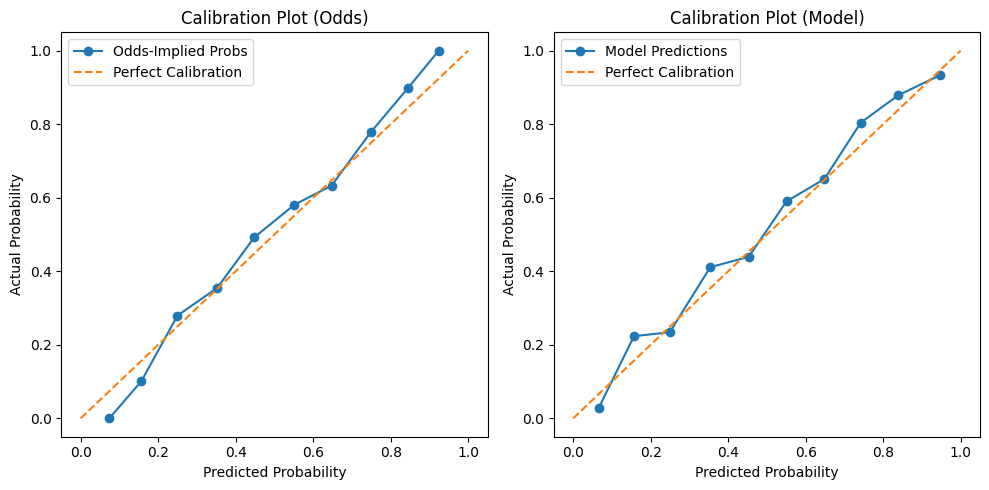

In [93]:
set_seed(42)

#{'hidden_layers': 4, 'embedding_hidden_layers': 0, 'embedding_size': 8, 'dropout': 0.19, 'lr': 0.0009360972595363841, 'weight_decay': 3.735731579186841e-06, 'batch_size': 32}

# ---- CONFIGURATION ----
config = {
    'batch_size': 32,
    'dropout': np.float64(0.19),
    'hidden_layer_sizes': [128, 64, 32, 16],
    'learning_rate': np.float64(0.0009360972595363841),
    'weight_decay': np.float64(3.735731579186841e-06),
    'epochs': 30,
}

# ---- DATA PREPARATION ----
train_dataset = TensorDataset(player1_train, player2_train, env_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True)

val_dataset = TensorDataset(
    player1_val, player2_val, env_val, y_val, player1_bet_odds_val, player2_bet_odds_val, uncertainty_val
)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=True)

# ---- MODEL INITIALIZATION ----
model = SymmetricNNWithEnvInteraction(
    player_feature_size=player1_train.shape[1],
    env_feature_size=env_train.shape[1],
    hidden_sizes=config['hidden_layer_sizes'],
    embedding_size=8,
    embedding_hidden_sizes=[32, 16],
    dropout=config['dropout']
)

# ---- INITIALIZATION ----
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(initialize_weights)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.4)

# ---- OPTIMIZER AND LOSS ----
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
criterion = nn.BCELoss()

# ---- TRAINING ----
best_val_brier = float('inf')
best_epoch = 0
for epoch in range(config['epochs']):
    # ---- TRAIN ----
    model.train()
    epoch_loss = 0.0
    for p1, p2, env, labels in train_loader:
        optimizer.zero_grad()
        predictions = model(p1, p2, env)
        loss = criterion(predictions, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    cpu_rng_state = torch.get_rng_state()

    # ---- VALIDATION ----
    model.eval()
    val_predictions, val_y_true, betting_probs, val_uncertainty = [], [], [], []

    with torch.no_grad():
        for p1, p2, env, labels, avgW, avgL, unc in val_loader:
            predictions = model(p1, p2, env)
            val_predictions.extend(predictions.tolist())
            val_y_true.extend(labels.tolist())
            val_uncertainty.extend(unc.tolist())

            # Betting probabilities
            probW = 1 / avgW
            probL = 1 / avgL
            total_prob = probW + probL
            probW /= total_prob
            betting_probs.append(probW)

    # ---- VALIDATION METRICS ----
    betting_probs = np.array(betting_probs).ravel()
    val_y_true = np.array(val_y_true).ravel()
    val_predictions = np.array(val_predictions).ravel()

    # Validation Brier Score
    brier = brier_score_loss(val_y_true, val_predictions)
    print(f"Epoch {epoch + 1}: Validation Brier Score: {brier:.4f}")
    scheduler.step(brier)

    if brier < best_val_brier:
        best_val_brier = brier
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pth')
    torch.set_rng_state(cpu_rng_state)

print(f"Best epoch: {best_epoch + 1}, Best Validation Brier: {best_val_brier:.4f}")

# ---- TEST EVALUATION ----
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Prepare Test DataLoader
test_dataset = TensorDataset(
    player1_test, player2_test, env_test, y_test, player1_bet_odds_test, player2_bet_odds_test, uncertainty_test
)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=False)

# Evaluate on Test Set
test_predictions, test_y_true, test_avgW, test_avgL, test_uncertainty = [], [], [], [], []

with torch.no_grad():
    for p1, p2, env, labels, avgW, avgL, unc in test_loader:
        predictions = model(p1, p2, env)
        test_predictions.extend(predictions.tolist())
        test_y_true.extend(labels.tolist())
        test_avgW.extend(avgW.tolist())
        test_avgL.extend(avgL.tolist())
        test_uncertainty.extend(unc.tolist())

# ---- UNCERTAINTY FILTERING ----
test_predictions = np.array(test_predictions).ravel()
test_y_true = np.array(test_y_true).ravel()
test_uncertainty = np.array(test_uncertainty)

unc_threshold = np.percentile(test_uncertainty, 50)
mask = test_uncertainty <= unc_threshold

filtered_predictions = test_predictions[mask]
filtered_labels = test_y_true[mask]
filtered_avgW = np.array(test_avgW)[mask]
filtered_avgL = np.array(test_avgL)[mask]

filtered_probW = 1 / filtered_avgW
filtered_probL = 1 / filtered_avgL
filtered_total_prob = filtered_probW + filtered_probL
filtered_probW /= filtered_total_prob
filtered_probW = np.where(np.isnan(filtered_probW), 0.5, filtered_probW)

# ---- METRICS ----
filtered_brier_odds = brier_score_loss(filtered_labels, filtered_probW)
filtered_brier_model = brier_score_loss(filtered_labels, filtered_predictions)

print(f"Filtered Brier Score (Odds): {filtered_brier_odds:.4f}")
print(f"Filtered Brier Score (Model): {filtered_brier_model:.4f}")

# ---- CALIBRATION PLOTS ----
prob_true_odds, prob_pred_odds = calibration_curve(filtered_labels, filtered_probW, n_bins=10)
prob_true_model, prob_pred_model = calibration_curve(filtered_labels, filtered_predictions, n_bins=10)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(prob_pred_odds, prob_true_odds, marker='o', label='Odds-Implied Probs')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.title('Calibration Plot (Odds)')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Probability')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(prob_pred_model, prob_true_model, marker='o', label='Model Predictions')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.title('Calibration Plot (Model)')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Probability')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_true contains true labels and y_pred contains model probabilities
# Filter probabilities where the true label is 1
true_positive_probs = np.concatenate([p for p, y in zip(val_features, val_labels) if y == 1])
print(brier_score_loss(val_labels, val_features))
# Plot the distribution
plt.figure(figsize=(8, 6))
plt.hist(true_positive_probs, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Model Probabilities for True Label = 1")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

true_positive_probs = np.concatenate([p for p, y in zip(val_features, val_labels) if y == 0])
print(brier_score_loss(val_labels, val_features))
# Plot the distribution
plt.figure(figsize=(8, 6))
plt.hist(true_positive_probs, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Model Probabilities for True Label = 0")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

NameError: name 'val_features' is not defined

PermutationExplainer explainer: 2591it [01:12, 33.73it/s]                          


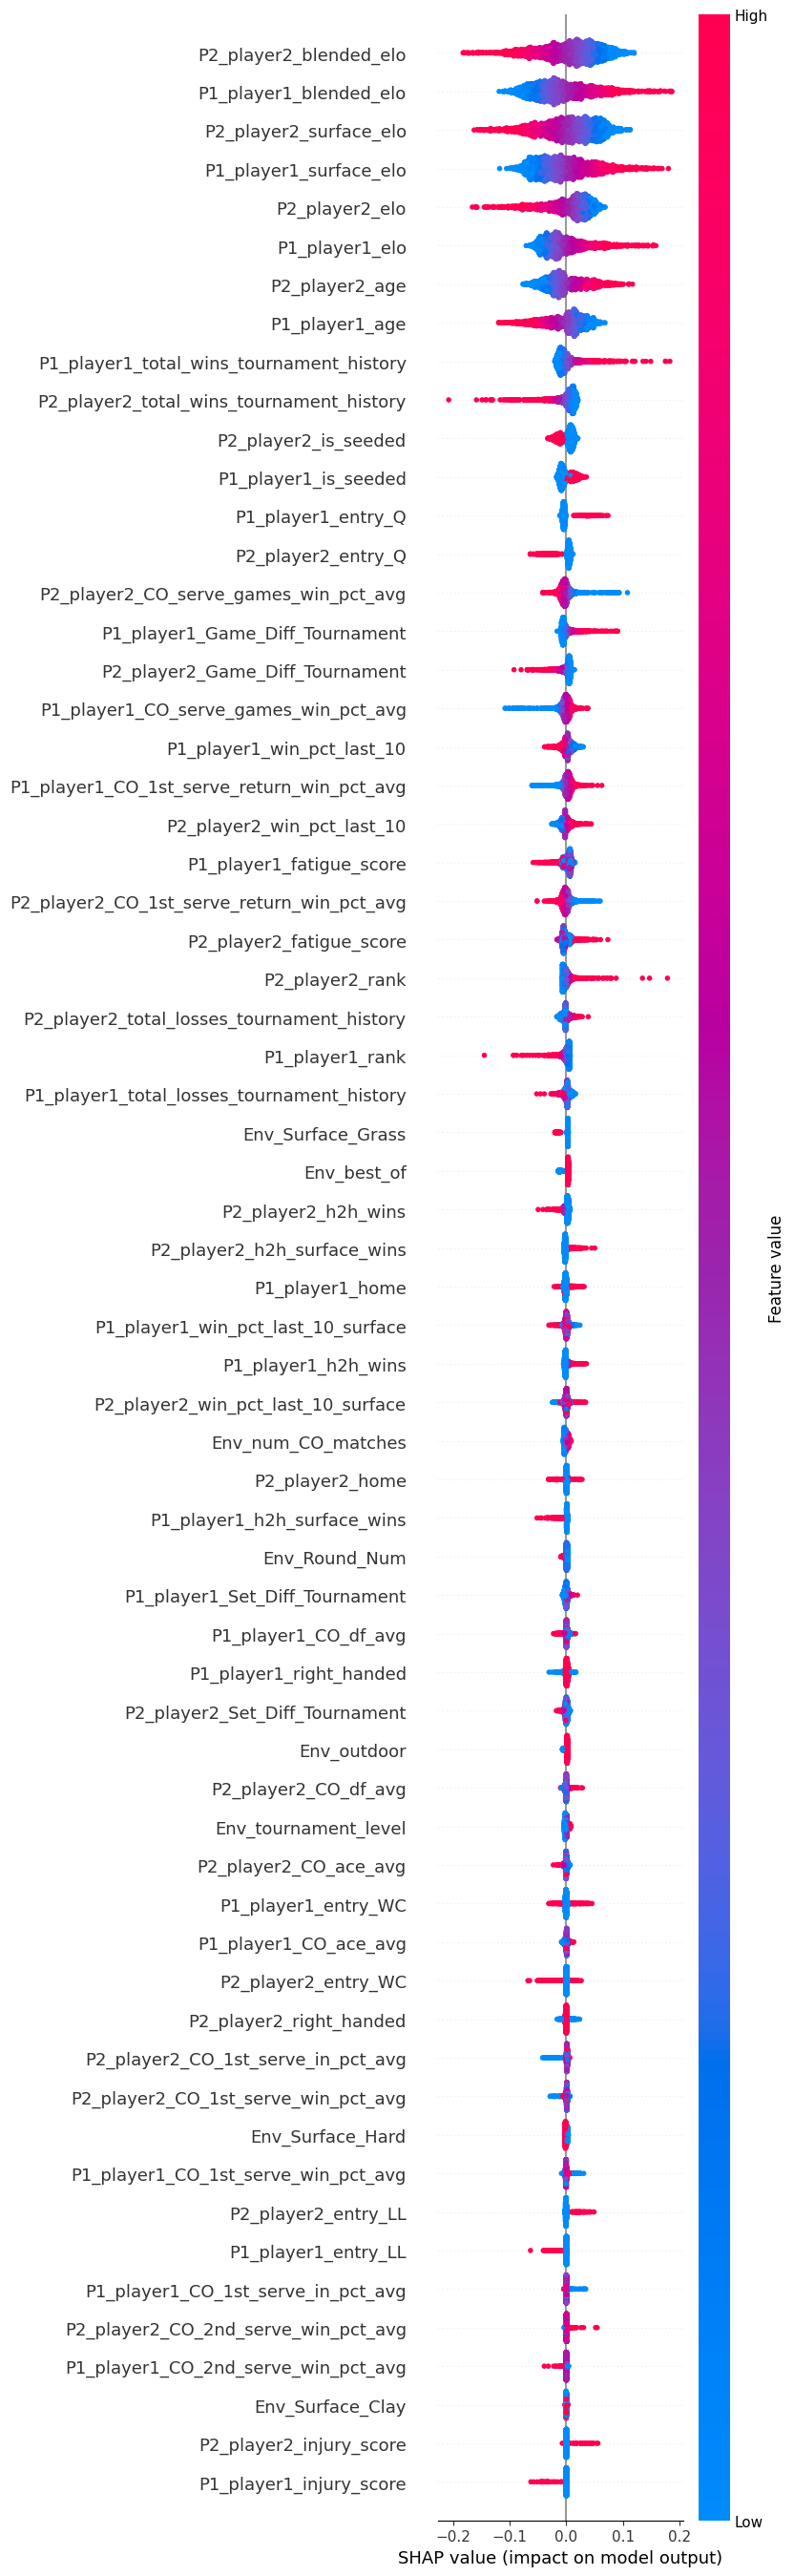

In [84]:
import shap
import torch
import torch.nn as nn

# Wrap the model to handle multiple inputs
class SHAPWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, X):
        # Convert NumPy array to PyTorch Tensor
        X = torch.tensor(X, dtype=torch.float32).to(next(self.model.parameters()).device)
        
        # Split input into required parts
        p1_size = player1_val.shape[1]
        p2_size = player2_val.shape[1]
        player1_features = X[:, :p1_size]
        player2_features = X[:, p1_size:p1_size + p2_size]
        env_features = X[:, p1_size + p2_size:]

        # Pass split features into the original model
        return self.model(player1_features, player2_features, env_features)

# Prepare inputs for SHAP
X_val = torch.cat([player1_val, player2_val, env_val], dim=1).cpu().numpy()

# Use the wrapped model
shap_model = SHAPWrapper(model)

# Create SHAP explainer
explainer = shap.Explainer(shap_model, X_val)

# Calculate SHAP values
shap_values = explainer(X_val)

# Feature names (replace with actual feature names)
feature_names = (
    [f"P1_{name}" for name in player1_cols] +  # Prefix Player 1 features
    [f"P2_{name}" for name in player2_cols] +  # Prefix Player 2 features
    [f"Env_{name}" for name in env_cols]  # Prefix Environment features
)

# Plot SHAP summary
shap.summary_plot(shap_values, X_val, feature_names=feature_names, max_display=100)


In [109]:
from sklearn.model_selection import ParameterSampler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
import scipy.stats as stats
import copy
import os

set_seed(42)

# Parameter grid for random search
param_grid = {
    'learning_rate': stats.loguniform(1e-5, 1e-2),
    'dropout': stats.uniform(0.1, 0.4),
    'hidden_layer_sizes': [
        [128], [256, 128], [256, 128, 64], [64], [32], [16, 8], [64, 32], [64, 64], [64, 32, 16], [64, 32, 32, 16], [256, 128, 64, 32], [256], [512], [1024],
    ],
    'batch_size': [32, 512, 5696],
    'weight_decay': stats.loguniform(1e-6, 1e-3),
    'optimizer': ['Adam'],
}

# Generate random hyperparameter samples
n_samples = 100
random_params = list(ParameterSampler(param_grid, n_iter=n_samples, random_state=42))


# Training and evaluation function
def train_and_evaluate(params):
    print(f"Testing configuration: {params}")
    
    # Extract parameters
    learning_rate = params['learning_rate']
    dropout = params['dropout']
    hidden_layer_sizes = params['hidden_layer_sizes']
    batch_size = params['batch_size']
    weight_decay = params['weight_decay']
    optimizer_choice = params['optimizer']
   
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Model
    model = SymmetricNNWithoutEmbeddings(
        player_feature_size=player1_train.shape[1],
        env_feature_size=env_train.shape[1],
        hidden_sizes=hidden_layer_sizes,
        dropout=dropout
    )
    
    # Initialize weights
    def initialize_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)
    model.apply(initialize_weights)

    # Optimizer
    if optimizer_choice == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_choice == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    elif optimizer_choice == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Loss function
    criterion = nn.BCELoss()
    
    best_epoch_brier_score = float('inf')
    best_model_state = None
    
    # Training loop with early stopping
    for epoch in range(60):
        model.train()
        for p1, p2, env, labels in train_loader:
            optimizer.zero_grad()
            predictions = model(p1, p2, env)
            loss = criterion(predictions, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        # Validation loop (collect predictions for calibration)
        model.eval()
        val_predictions = []
        val_y_true = []

        with torch.no_grad():
            for p1, p2, env, labels, avgW, avgL in val_loader:
                predictions = model(p1, p2, env)
                val_predictions.extend(predictions.tolist())
                val_y_true.extend(labels.tolist())

        # Reshape predictions and labels
        val_predictions = np.array(val_predictions).reshape(-1, 1)
        val_y_true = np.array(val_y_true)
        val_y_true = np.ravel(val_y_true)  # Reshape labels to 1D
        # Calibration
        calibrator = CalibratedClassifierCV(estimator=LogisticRegression(), method='isotonic', cv=5)        
        calibrator.fit(val_predictions, val_y_true)
        calibrated_probs = calibrator.predict_proba(val_predictions)[:, 1]

        # Brier score with calibrated probabilities
        brier_score = brier_score_loss(val_y_true, calibrated_probs)


        # Save best model based on calibrated Brier score
        if brier_score < best_epoch_brier_score:
            best_epoch_brier_score = brier_score
            best_model_state = copy.deepcopy(model.state_dict())
        
    print(f"Best BS for this config: Calibrated Brier Score: {best_epoch_brier_score:.4f}")
    return best_epoch_brier_score, best_model_state


# Run random search
best_params = None
best_val_brier_score = float('inf')  # Start with infinity
best_model_state = None

for params in random_params:
    val_brier_score, model_state = train_and_evaluate(params)
    if val_brier_score < best_val_brier_score:  # Minimize Brier score
        best_val_brier_score = val_brier_score
        best_params = params
        best_model_state = model_state

# Save the best model weights and configuration
if best_model_state is not None:
    os.makedirs("best_models", exist_ok=True)
    torch.save(best_model_state, os.path.join("best_models", "best_model_weights.pth"))
    with open(os.path.join("best_models", "best_config.txt"), "w") as f:
        f.write(f"Best Configuration:\n{best_params}\n")
        f.write(f"Best Validation Brier Score: {best_val_brier_score:.4f}\n")

print(f"Best Configuration: {best_params}")
print(f"Best Validation Brier Score: {best_val_brier_score:.4f}")


Testing configuration: {'batch_size': 5696, 'dropout': np.float64(0.4186171947440932), 'hidden_layer_sizes': [256, 128, 64, 32], 'learning_rate': np.float64(0.0021830968390524606), 'optimizer': 'Adam', 'weight_decay': np.float64(6.173770394704566e-05)}
Best BS for this config: Calibrated Brier Score: 0.2145
Testing configuration: {'batch_size': 512, 'dropout': np.float64(0.16239780813448107), 'hidden_layer_sizes': [256, 128, 64, 32], 'learning_rate': np.float64(0.00023864188780056055), 'optimizer': 'Adam', 'weight_decay': np.float64(1.0025956902289558e-05)}
Best BS for this config: Calibrated Brier Score: 0.2153
Testing configuration: {'batch_size': 5696, 'dropout': np.float64(0.10823379771832098), 'hidden_layer_sizes': [256, 128], 'learning_rate': np.float64(0.0014655354118727707), 'optimizer': 'Adam', 'weight_decay': np.float64(0.0006541210527692731)}
Best BS for this config: Calibrated Brier Score: 0.2144
Testing configuration: {'batch_size': 512, 'dropout': np.float64(0.17272998688

KeyboardInterrupt: 

### Porównanie dwóch sposobów symetryczności modelu

In [85]:
from sklearn.model_selection import ParameterSampler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
import scipy.stats as stats
import copy
import os

set_seed(42)

# Parameter grid for random search
param_grid = {
    'learning_rate': stats.loguniform(1e-5, 1e-2),
    'dropout': stats.uniform(0.1, 0.4),
    'hidden_layer_sizes': [
       [256], [512], [256,256], [128,128], [128,64], [128], [256, 128], [256, 128, 64], [64], [32], [16, 8], [64, 32], [64, 64], [64, 32, 16], [64, 32, 32, 16], [256, 128, 64, 32], [512, 256, 128, 64]
    ],
    'batch_size': [32, 64, 128],
    'embedding_sizes': [4,8,16,32],
    'embedding_hidden_sizes': [[32], [16], [64], [128], [32,16], [64,32]],
    'weight_decay': stats.loguniform(1e-6, 1e-3),
    'optimizer': ['Adam'],
}

# Generate random hyperparameter samples
n_samples = 150
random_params = list(ParameterSampler(param_grid, n_iter=n_samples, random_state=42))


# Training and evaluation function
def train_and_evaluate(params):
    print(f"Testing configuration: {params}")
    
    # Extract parameters
    learning_rate = params['learning_rate']
    dropout = params['dropout']
    hidden_layer_sizes = params['hidden_layer_sizes']
    batch_size = params['batch_size']
    weight_decay = params['weight_decay']
    optimizer_choice = params['optimizer']
    embedding_sizes = params['embedding_sizes']
    embedding_hidden_layers = params['embedding_hidden_sizes']
   
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Model
    model = SymmetricNNWithEnvInteraction(
        player_feature_size=player1_train.shape[1],
        env_feature_size=env_train.shape[1],
        embedding_size=embedding_sizes,
        embedding_hidden_sizes=embedding_hidden_layers,
        hidden_sizes=hidden_layer_sizes,
        dropout=dropout
    )
    
    # Initialize weights
    def initialize_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)
    model.apply(initialize_weights)

    # Optimizer
    if optimizer_choice == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_choice == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    elif optimizer_choice == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Loss function
    criterion = nn.BCELoss()
    
    best_epoch_brier_score = float('inf')
    best_model_state = None
    
    # Training loop with early stopping
    for epoch in range(40):
        model.train()
        for p1, p2, env, labels in train_loader:
            optimizer.zero_grad()
            predictions = model(p1, p2, env)
            loss = criterion(predictions, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        # Validation loop (collect predictions for calibration)
        model.eval()
        val_predictions = []
        val_y_true = []

        with torch.no_grad():
            for p1, p2, env, labels, avgW, avgL in val_loader:
                predictions = model(p1, p2, env)
                val_predictions.extend(predictions.tolist())
                val_y_true.extend(labels.tolist())

        # Reshape predictions and labels
        val_predictions = np.array(val_predictions).reshape(-1, 1)
        val_y_true = np.array(val_y_true)
        val_y_true = np.ravel(val_y_true)  # Reshape labels to 1D
        # Calibration
        calibrator = CalibratedClassifierCV(estimator=LogisticRegression(), method='isotonic', cv=5)        
        calibrator.fit(val_predictions, val_y_true)
        calibrated_probs = calibrator.predict_proba(val_predictions)[:, 1]

        # Brier score with calibrated probabilities
        brier_score = brier_score_loss(val_y_true, calibrated_probs)


        # Save best model based on calibrated Brier score
        if brier_score < best_epoch_brier_score:
            best_epoch_brier_score = brier_score
            best_model_state = copy.deepcopy(model.state_dict())
        
    print(f"Best BS for this config: Calibrated Brier Score: {best_epoch_brier_score:.4f}")
    return best_epoch_brier_score, best_model_state


# Run random search
best_params = None
best_val_brier_score = float('inf')  # Start with infinity
best_model_state = None

for params in random_params:
    val_brier_score, model_state = train_and_evaluate(params)
    if val_brier_score < best_val_brier_score:  # Minimize Brier score
        best_val_brier_score = val_brier_score
        best_params = params
        best_model_state = model_state

# Save the best model weights and configuration
if best_model_state is not None:
    os.makedirs("best_models", exist_ok=True)
    torch.save(best_model_state, os.path.join("best_models", "embedding_best_model_weights.pth"))
    with open(os.path.join("best_models", "embedding_best_config.txt"), "w") as f:
        f.write(f"Best Configuration:\n{best_params}\n")
        f.write(f"Best Validation Brier Score: {best_val_brier_score:.4f}\n")

print(f"Best Configuration: {best_params}")
print(f"Best Validation Brier Score: {best_val_brier_score:.4f}")


Testing configuration: {'batch_size': 128, 'dropout': np.float64(0.4186171947440932), 'embedding_hidden_sizes': [64], 'embedding_sizes': 32, 'hidden_layer_sizes': [256, 128], 'learning_rate': np.float64(0.00021751953118777652), 'optimizer': 'Adam', 'weight_decay': np.float64(1.994916615063394e-06)}


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 64])

In [86]:
from sklearn.model_selection import ParameterSampler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
import scipy.stats as stats
import copy
import os

set_seed(42)

# Parameter grid for random search
param_grid = {
    'learning_rate': stats.loguniform(1e-5, 1e-2),
    'dropout': stats.uniform(0.1, 0.4),
    'hidden_layer_sizes': [
       [256], [512], [256,256], [128,128], [128,64], [128], [256, 128], [256, 128, 64], [64], [32], [16, 8], [64, 32], [64, 64], [64, 32, 16], [64, 32, 32, 16], [256, 128, 64, 32], [512, 256, 128, 64]
    ],
    'batch_size': [32, 64, 128],
    'weight_decay': stats.loguniform(1e-6, 1e-3),
    'optimizer': ['Adam'],
}

# Generate random hyperparameter samples
n_samples = 150
random_params = list(ParameterSampler(param_grid, n_iter=n_samples, random_state=42))


# Training and evaluation function
def train_and_evaluate(params):
    print(f"Testing configuration: {params}")
    
    # Extract parameters
    learning_rate = params['learning_rate']
    dropout = params['dropout']
    hidden_layer_sizes = params['hidden_layer_sizes']
    batch_size = params['batch_size']
    weight_decay = params['weight_decay']
    optimizer_choice = params['optimizer']
   
   
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Model
    model = SymmetricNNWithoutEmbeddings(
        player_feature_size=player1_train.shape[1],
        env_feature_size=env_train.shape[1],
        hidden_sizes=hidden_layer_sizes,
        dropout=dropout
    )
    # Initialize weights
    def initialize_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)
    model.apply(initialize_weights)

    # Optimizer
    if optimizer_choice == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_choice == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    elif optimizer_choice == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Loss function
    criterion = nn.BCELoss()
    
    best_epoch_brier_score = float('inf')
    best_model_state = None
    
    # Training loop with early stopping
    for epoch in range(40):
        model.train()
        for p1, p2, env, labels in train_loader:
            optimizer.zero_grad()
            predictions = model(p1, p2, env)
            loss = criterion(predictions, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        # Validation loop (collect predictions for calibration)
        model.eval()
        val_predictions = []
        val_y_true = []

        with torch.no_grad():
            for p1, p2, env, labels, avgW, avgL in val_loader:
                predictions = model(p1, p2, env)
                val_predictions.extend(predictions.tolist())
                val_y_true.extend(labels.tolist())

        # Reshape predictions and labels
        val_predictions = np.array(val_predictions).reshape(-1, 1)
        val_y_true = np.array(val_y_true)
        val_y_true = np.ravel(val_y_true)  # Reshape labels to 1D
        # Calibration
        calibrator = CalibratedClassifierCV(estimator=LogisticRegression(), method='isotonic', cv=5)        
        calibrator.fit(val_predictions, val_y_true)
        calibrated_probs = calibrator.predict_proba(val_predictions)[:, 1]

        # Brier score with calibrated probabilities
        brier_score = brier_score_loss(val_y_true, calibrated_probs)


        # Save best model based on calibrated Brier score
        if brier_score < best_epoch_brier_score:
            best_epoch_brier_score = brier_score
            best_model_state = copy.deepcopy(model.state_dict())
        
    print(f"Best BS for this config: Calibrated Brier Score: {best_epoch_brier_score:.4f}")
    return best_epoch_brier_score, best_model_state


# Run random search
best_params = None
best_val_brier_score = float('inf')  # Start with infinity
best_model_state = None

for params in random_params:
    val_brier_score, model_state = train_and_evaluate(params)
    if val_brier_score < best_val_brier_score:  # Minimize Brier score
        best_val_brier_score = val_brier_score
        best_params = params
        best_model_state = model_state

# Save the best model weights and configuration
if best_model_state is not None:
    os.makedirs("best_models", exist_ok=True)
    torch.save(best_model_state, os.path.join("best_models", "no_embedding_best_model_weights.pth"))
    with open(os.path.join("best_models", "no_embedding_best_config.txt"), "w") as f:
        f.write(f"Best Configuration:\n{best_params}\n")
        f.write(f"Best Validation Brier Score: {best_val_brier_score:.4f}\n")

print(f"Best Configuration: {best_params}")
print(f"Best Validation Brier Score: {best_val_brier_score:.4f}")


Testing configuration: {'batch_size': 128, 'dropout': np.float64(0.4186171947440932), 'hidden_layer_sizes': [64, 32, 32, 16], 'learning_rate': np.float64(0.001570297088405539), 'optimizer': 'Adam', 'weight_decay': np.float64(6.251373574521755e-05)}
Best BS for this config: Calibrated Brier Score: 0.2063
Testing configuration: {'batch_size': 128, 'dropout': np.float64(0.2783331011414365), 'hidden_layer_sizes': [16, 8], 'learning_rate': np.float64(0.00023864188780056055), 'optimizer': 'Adam', 'weight_decay': np.float64(1.0025956902289558e-05)}
Best BS for this config: Calibrated Brier Score: 0.2098
Testing configuration: {'batch_size': 128, 'dropout': np.float64(0.10823379771832098), 'hidden_layer_sizes': [512], 'learning_rate': np.float64(0.0014655354118727707), 'optimizer': 'Adam', 'weight_decay': np.float64(0.0006541210527692731)}
Best BS for this config: Calibrated Brier Score: 0.2052
Testing configuration: {'batch_size': 64, 'dropout': np.float64(0.17272998688284025), 'hidden_layer_

### Koniec porównania

In [89]:
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import brier_score_loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_model = SymmetricNNWithoutEmbeddings(
    player_feature_size=player1_train.shape[1],
    env_feature_size=env_train.shape[1],
    hidden_sizes=[64, 32, 32, 16],
    dropout=np.float64(0.35998494949080172),  
)

model_path = "best_models/no_embedding_best_model_weights.pth"
state_dict = torch.load(model_path, map_location=torch.device('cpu'))

best_model.load_state_dict(state_dict)
best_model.eval()

val_predictions = []
val_y_true = []

with torch.no_grad():
    for p1, p2, env, labels, avgW, avgL in val_loader:
        predictions = best_model(p1, p2, env)
        val_predictions.extend(predictions.tolist())
        val_y_true.extend(labels.tolist())
val_predictions = np.array(val_predictions).reshape(-1, 1)
val_y_true = np.array(val_y_true)
val_y_true = np.ravel(val_y_true)  # Reshape labels to 1D
# Calibration
calibrator = CalibratedClassifierCV(estimator=LogisticRegression(), method='isotonic', cv=5)        
calibrator.fit(val_predictions, val_y_true)
calibrated_probs = calibrator.predict_proba(val_predictions)[:, 1]
# Calculate Log Loss for this epoch
calibrated_probs = torch.tensor(calibrated_probs)
val_y_true = torch.tensor(val_y_true)
logloss = F.binary_cross_entropy(calibrated_probs, val_y_true).item()
print("Log Loss: ",  logloss)
# 
# # ROI Calculation
# val_predictions = []
# val_y_true = []
# val_avgW = []
# val_avgL = []
# with torch.no_grad():
#     for p1, p2, env, labels, avgW, avgL in val_loader:
# 
#         predictions = best_model(p1, p2, env)
#         val_predictions.extend(predictions.tolist())
#         val_y_true.extend(labels.tolist())
#         val_avgW.extend(avgW.tolist())
#         val_avgL.extend(avgL.tolist())
# val_predictions = np.array(val_predictions).reshape(-1, 1)
# val_y_true = np.array(val_y_true)
# val_y_true = np.ravel(val_y_true)  # Reshape labels to 1D
# Calibration
calibrator = CalibratedClassifierCV(estimator=LogisticRegression(), method='isotonic', cv=5)        
calibrator.fit(val_predictions, val_y_true)
calibrated_probs = calibrator.predict_proba(val_predictions)[:, 1]
# roi = calculate_roi(calibrated_probs, val_avgW, val_avgL, val_y_true, max_bet=1.0)
# print(f"Validation ROI for this configuration: {roi:.4%}")
# 2. Brier Score

brier_score = brier_score_loss(val_y_true, calibrated_probs)
print(f"Brier Score: {brier_score:.4f}")
# Accuracy Calculation
correct = 0
total = 0
with torch.no_grad():
    for p1, p2, env, labels, a, b in val_loader:
        p1, p2, env = p1.to(device), p2.to(device), env.to(device)
        labels = labels.to(device)

        predictions = best_model(p1, p2, env)
        predicted = predictions.round()  # Cleaner prediction rounding
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

val_accuracy = correct / total
print(f"Validation Accuracy: {val_accuracy:.2%}")

Log Loss:  0.592925895836147
Brier Score: 0.2048
Validation Accuracy: 66.80%


C:\Users\Pawel\AppData\Local\Temp\ipykernel_11820\3450374363.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.devi

In [124]:
test_dataset = TensorDataset(player1_test, player2_test, env_test, y_test, player1_bet_odds_test, player2_bet_odds_test)
test_loader = DataLoader(test_dataset, batch_size=5696, shuffle=False)

In [210]:
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import brier_score_loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_model = SymmetricNNWithoutEmbeddings(
    player_feature_size=player1_train.shape[1],
    env_feature_size=env_train.shape[1],
    hidden_sizes=[64, 32, 32, 16],
    dropout=np.float64(0.35998494949080172),  
)

model_path = "best_models/no_embedding_best_model_weights.pth"
state_dict = torch.load(model_path, map_location=torch.device('cpu'))

best_model.load_state_dict(state_dict)
best_model.eval()

val_predictions = []
val_y_true = []

with torch.no_grad():
    for p1, p2, env, labels in test_loader:
        predictions = best_model(p1, p2, env)
        val_predictions.extend(predictions.tolist())
        val_y_true.extend(labels.tolist())
val_predictions = np.array(val_predictions).reshape(-1, 1)
val_y_true = np.array(val_y_true)
val_y_true = np.ravel(val_y_true)  # Reshape labels to 1D
# Calibration
calibrator = CalibratedClassifierCV(estimator=LogisticRegression(), method='isotonic', cv=5)        
calibrator.fit(val_predictions, val_y_true)
calibrated_probs = calibrator.predict_proba(val_predictions)[:, 1]
# Calculate Log Loss for this epoch
calibrated_probs = torch.tensor(calibrated_probs)
val_y_true = torch.tensor(val_y_true)
logloss = F.binary_cross_entropy(calibrated_probs, val_y_true).item()
print("Log Loss: ",  logloss)
# 
# # ROI Calculation
# val_predictions = []
# val_y_true = []
# val_avgW = []
# val_avgL = []
# with torch.no_grad():
#     for p1, p2, env, labels, avgW, avgL in val_loader:
# 
#         predictions = best_model(p1, p2, env)
#         val_predictions.extend(predictions.tolist())
#         val_y_true.extend(labels.tolist())
#         val_avgW.extend(avgW.tolist())
#         val_avgL.extend(avgL.tolist())
# val_predictions = np.array(val_predictions).reshape(-1, 1)
# val_y_true = np.array(val_y_true)
# val_y_true = np.ravel(val_y_true)  # Reshape labels to 1D
# Calibration
calibrator = CalibratedClassifierCV(estimator=LogisticRegression(), method='isotonic', cv=5)        
calibrator.fit(val_predictions, val_y_true)
calibrated_probs = calibrator.predict_proba(val_predictions)[:, 1]
# roi = calculate_roi(calibrated_probs, val_avgW, val_avgL, val_y_true, max_bet=1.0)
# print(f"Validation ROI for this configuration: {roi:.4%}")
# 2. Brier Score

brier_score = brier_score_loss(val_y_true, val_predictions)
print(f"Brier Score: {brier_score:.4f}")
# Accuracy Calculation
correct = 0
total = 0
with torch.no_grad():
    for p1, p2, env, labels in test_loader:
        p1, p2, env = p1.to(device), p2.to(device), env.to(device)
        labels = labels.to(device)

        predictions = best_model(p1, p2, env)
        predicted = predictions.round()  # Cleaner prediction rounding
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

val_accuracy = correct / total
print(f"Validation Accuracy: {val_accuracy:.2%}")

C:\Users\Pawel\AppData\Local\Temp\ipykernel_11820\2941176816.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.devi

Log Loss:  0.6146433700901593
Brier Score: 0.2169
Validation Accuracy: 65.44%


### Dużo gorzej na test niż na val, spróbujmy nested validation

In [64]:
matches['Date'] = pd.to_datetime(matches['Date'])
matches['year'] = matches['Date'].dt.year
matches = matches[matches['year'] > 2018]


In [70]:
from sklearn.model_selection import TimeSeriesSplit

# Assume data sorted by date
train_data = matches[matches['year'] <= 2022]  # Training pool (years before 2022)
final_val_data = matches[matches['year'] == 2022]
final_test_data = matches[matches['year'] >= 2023]  # Final test set (held out)

In [71]:
env_cols

['outdoor',
 'tournament_level',
 'best_of',
 'non_CO_uncertainty',
 'CO_uncertainty',
 'Round_Num',
 'Surface_Clay',
 'Surface_Grass',
 'Surface_Hard']

In [74]:
from sklearn.preprocessing import MinMaxScaler
def prepare_dataloaders(train_fold, val_fold, player1_cols, player2_cols, env_cols, batch_size=64):
    print(env_cols)
    # Extract features and targets
    player1_train = train_fold[player1_cols].values
    player2_train = train_fold[player2_cols].values
    env_train = train_fold[env_cols].values
    y_train = train_fold['target'].values

    player1_val = val_fold[player1_cols].values
    player2_val = val_fold[player2_cols].values
    env_val = val_fold[env_cols].values
    y_val = val_fold['target'].values

    # Scale features
    player_scaler = MinMaxScaler()
    env_scaler = MinMaxScaler()

    player1_train = player_scaler.fit_transform(player1_train)
    player2_train = player_scaler.transform(player2_train)
    env_train = env_scaler.fit_transform(env_train)

    player1_val = player_scaler.transform(player1_val)
    player2_val = player_scaler.transform(player2_val)
    env_val = env_scaler.transform(env_val)

    # Convert to PyTorch tensors
    train_dataset = TensorDataset(
        torch.tensor(player1_train, dtype=torch.float32),
        torch.tensor(player2_train, dtype=torch.float32),
        torch.tensor(env_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32).unsqueeze(1),
    )
    val_dataset = TensorDataset(
        torch.tensor(player1_val, dtype=torch.float32),
        torch.tensor(player2_val, dtype=torch.float32),
        torch.tensor(env_val, dtype=torch.float32),
        torch.tensor(y_val, dtype=torch.float32).unsqueeze(1),
    )

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [75]:
import optuna
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import brier_score_loss

# Set random seed for reproducibility
set_seed(42)
tscv = TimeSeriesSplit(n_splits=4)
hidden_layer_options = {
    0: [1024],
    1: [512, 256],
    2: [1024, 512],
    3: [512, 256, 128]
}
# Objective function for Optuna optimization
def objective(trial):
    brier_scores = 0

    # Hyperparameters to optimize
    hidden_layer_key = trial.suggest_categorical("hidden_layers", [0, 1, 2, 3])
    dropout = trial.suggest_float("dropout", 0.05, 0.3)
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    
    hidden_layers = hidden_layer_options[hidden_layer_key]
    for fold, (train_idx, val_idx) in enumerate(tscv.split(train_data)):
        print(f"Fold {fold + 1}")

        # Data splitting
        train_fold = train_data.iloc[train_idx]
        val_fold = train_data.iloc[val_idx]

        train_loader, val_loader = prepare_dataloaders(
            train_fold, val_fold, player1_cols, player2_cols, env_cols, batch_size=batch_size
        )

        # Model
        model = SymmetricNNWithoutEmbeddings(
            player_feature_size=player1_train.shape[1],
            env_feature_size=env_train.shape[1],
            hidden_sizes=hidden_layers,
            dropout=dropout
        )

        def initialize_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
        model.apply(initialize_weights)

        # Optimizer and Scheduler
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.4)
        criterion = nn.BCELoss()

        # Training loop with early stopping
        best_epoch_brier_score = float('inf')
        for epoch in range(50):
            model.train()
            for p1, p2, env, labels in train_loader:
                optimizer.zero_grad()
                predictions = model(p1, p2, env)
                loss = criterion(predictions, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            cpu_rng_state = torch.get_rng_state()
            # Validation loop
            model.eval()
            val_predictions = []
            val_y_true = []

            with torch.no_grad():
                for p1, p2, env, labels in val_loader:
                    predictions = model(p1, p2, env)
                    val_predictions.extend(predictions.tolist())
                    val_y_true.extend(labels.tolist())

            # Calculate Brier Score
            val_predictions = np.array(val_predictions).reshape(-1, 1)
            val_y_true = np.array(val_y_true).ravel()
            brier_score = brier_score_loss(val_y_true, val_predictions)
            scheduler.step(brier_score)

            # Update best score
            if brier_score < best_epoch_brier_score:
                best_epoch_brier_score = brier_score
            
            torch.set_rng_state(cpu_rng_state)

        print(f"Best BS for fold {fold + 1}: {best_epoch_brier_score:.4f}")
        brier_scores += best_epoch_brier_score

    avg_brier_score = brier_scores / 4
    print(f"Avg BS: {avg_brier_score:.4f}")
    return avg_brier_score

# Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Print best parameters
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)


[I 2024-12-30 03:00:21,703] A new study created in memory with name: no-name-b966069d-4982-4ded-aac5-1d05191e34b7


Fold 1
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']


[W 2024-12-30 03:00:25,272] Trial 0 failed with parameters: {'hidden_layers': 0, 'dropout': 0.24147669530636584, 'lr': 0.00010611975043549808, 'weight_decay': 2.5058994555823466e-05, 'batch_size': 256} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "E:\Pawel\Studia\Inzynierka_Git\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Pawel\AppData\Local\Temp\ipykernel_23636\507008377.py", line 63, in objective
    predictions = model(p1, p2, env)
                  ^^^^^^^^^^^^^^^^^^
  File "E:\Pawel\Studia\Inzynierka_Git\.venv\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\Pawel\Studia\Inzynierka_Git\.venv\Lib\site-packages\torch\nn\modules\module.py", line 1747, in _call_impl
    return forward_call(*arg

KeyboardInterrupt: 

In [76]:
import optuna
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import brier_score_loss

# Set random seed for reproducibility
set_seed(42)
tscv = TimeSeriesSplit(n_splits=4)
hidden_layer_options = {
    0: [1024],
    1: [512, 256],
    2: [1024, 512],
    3: [512, 256, 128]
}
# Objective function for Optuna optimization
def objective(trial):
    brier_scores = 0

    # Hyperparameters to optimize
    hidden_layer_key = trial.suggest_categorical("hidden_layers", [0, 1, 2, 3])
    dropout = trial.suggest_float("dropout", 0.05, 0.3)
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    
    hidden_layers = hidden_layer_options[hidden_layer_key]
    for fold, (train_idx, val_idx) in enumerate(tscv.split(train_data)):
        print(f"Fold {fold + 1}")

        # Data splitting
        train_fold = train_data.iloc[train_idx]
        val_fold = train_data.iloc[val_idx]

        train_loader, val_loader = prepare_dataloaders(
            train_fold, val_fold, player1_cols, player2_cols, env_cols, batch_size=batch_size
        )

        # Model
        model = SymmetricNNWithEnvInteraction(
            player_feature_size=player1_train.shape[1],
            env_feature_size=env_train.shape[1],
            hidden_sizes=hidden_layers,
            embedding_size=8,
            embedding_hidden_sizes=[32],
            dropout=dropout
        )

        def initialize_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
        model.apply(initialize_weights)

        # Optimizer and Scheduler
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.4)
        criterion = nn.BCELoss()

        # Training loop with early stopping
        best_epoch_brier_score = float('inf')
        for epoch in range(50):
            model.train()
            for p1, p2, env, labels in train_loader:
                optimizer.zero_grad()
                predictions = model(p1, p2, env)
                loss = criterion(predictions, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            cpu_rng_state = torch.get_rng_state()
            # Validation loop
            model.eval()
            val_predictions = []
            val_y_true = []

            with torch.no_grad():
                for p1, p2, env, labels in val_loader:
                    predictions = model(p1, p2, env)
                    val_predictions.extend(predictions.tolist())
                    val_y_true.extend(labels.tolist())

            # Calculate Brier Score
            val_predictions = np.array(val_predictions).reshape(-1, 1)
            val_y_true = np.array(val_y_true).ravel()
            brier_score = brier_score_loss(val_y_true, val_predictions)
            scheduler.step(brier_score)

            # Update best score
            if brier_score < best_epoch_brier_score:
                best_epoch_brier_score = brier_score
            
            torch.set_rng_state(cpu_rng_state)

        print(f"Best BS for fold {fold + 1}: {best_epoch_brier_score:.4f}")
        brier_scores += best_epoch_brier_score

    avg_brier_score = brier_scores / 4
    print(f"Avg BS: {avg_brier_score:.4f}")
    return avg_brier_score

# Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Print best parameters
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)


[I 2024-12-30 03:03:00,115] A new study created in memory with name: no-name-f8cbf87b-71ea-4341-8cbe-80da79353284


Fold 1
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']
Best BS for fold 1: 0.2232
Fold 2
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']
Best BS for fold 2: 0.2156
Fold 3
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']
Best BS for fold 3: 0.2152
Fold 4
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']


[I 2024-12-30 03:04:03,258] Trial 0 finished with value: 0.2156497351518607 and parameters: {'hidden_layers': 3, 'dropout': 0.15671996341483047, 'lr': 0.0001958064308253144, 'weight_decay': 3.2176725734819144e-06, 'batch_size': 64}. Best is trial 0 with value: 0.2156497351518607.


Best BS for fold 4: 0.2086
Avg BS: 0.2156
Fold 1
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']
Best BS for fold 1: 0.2262
Fold 2
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']
Best BS for fold 2: 0.2308
Fold 3
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']
Best BS for fold 3: 0.2203
Fold 4
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']


[I 2024-12-30 03:04:42,150] Trial 1 finished with value: 0.2240557325874868 and parameters: {'hidden_layers': 2, 'dropout': 0.19596513884150246, 'lr': 1.2286403248018297e-05, 'weight_decay': 8.475727372698104e-05, 'batch_size': 256}. Best is trial 0 with value: 0.2156497351518607.


Best BS for fold 4: 0.2189
Avg BS: 0.2241
Fold 1
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']
Best BS for fold 1: 0.2222
Fold 2
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']
Best BS for fold 2: 0.2138
Fold 3
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']
Best BS for fold 3: 0.2151
Fold 4
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']


[I 2024-12-30 03:05:31,426] Trial 2 finished with value: 0.21492839152307666 and parameters: {'hidden_layers': 2, 'dropout': 0.2832429640130761, 'lr': 0.0009259716588562285, 'weight_decay': 1.071146493525195e-05, 'batch_size': 128}. Best is trial 2 with value: 0.21492839152307666.


Best BS for fold 4: 0.2085
Avg BS: 0.2149
Fold 1
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']
Best BS for fold 1: 0.2235
Fold 2
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']
Best BS for fold 2: 0.2176
Fold 3
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']
Best BS for fold 3: 0.2154
Fold 4
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']


[I 2024-12-30 03:06:42,855] Trial 3 finished with value: 0.21607391734058407 and parameters: {'hidden_layers': 2, 'dropout': 0.18434268262627712, 'lr': 0.00027026159897597867, 'weight_decay': 1.4342812143764124e-05, 'batch_size': 64}. Best is trial 2 with value: 0.21492839152307666.


Best BS for fold 4: 0.2078
Avg BS: 0.2161
Fold 1
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']
Best BS for fold 1: 0.2254
Fold 2
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']
Best BS for fold 2: 0.2226
Fold 3
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']
Best BS for fold 3: 0.2219
Fold 4
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']


[I 2024-12-30 03:07:50,008] Trial 4 finished with value: 0.22183905281651237 and parameters: {'hidden_layers': 1, 'dropout': 0.2846281805670788, 'lr': 1.6576399193478005e-05, 'weight_decay': 4.0479513944492985e-05, 'batch_size': 64}. Best is trial 2 with value: 0.21492839152307666.


Best BS for fold 4: 0.2174
Avg BS: 0.2218
Fold 1
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']
Best BS for fold 1: 0.2306
Fold 2
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']
Best BS for fold 2: 0.2216
Fold 3
['outdoor', 'tournament_level', 'best_of', 'non_CO_uncertainty', 'CO_uncertainty', 'Round_Num', 'Surface_Clay', 'Surface_Grass', 'Surface_Hard']


[W 2024-12-30 03:08:28,490] Trial 5 failed with parameters: {'hidden_layers': 1, 'dropout': 0.07167166526666725, 'lr': 1.5490064677027686e-05, 'weight_decay': 1.500569399083207e-06, 'batch_size': 64} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "E:\Pawel\Studia\Inzynierka_Git\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Pawel\AppData\Local\Temp\ipykernel_23636\3616946076.py", line 67, in objective
    loss.backward()
  File "E:\Pawel\Studia\Inzynierka_Git\.venv\Lib\site-packages\torch\_tensor.py", line 581, in backward
    torch.autograd.backward(
  File "E:\Pawel\Studia\Inzynierka_Git\.venv\Lib\site-packages\torch\autograd\__init__.py", line 347, in backward
    _engine_run_backward(
  File "E:\Pawel\Studia\Inzynierka_Git\.venv\Lib\site-packages\torch\autograd\graph.py", line 825, in _engine_run_backward
    return Variab

KeyboardInterrupt: 

In [362]:
import torch
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    brier_score_loss, log_loss, roc_auc_score, accuracy_score, 
    precision_score, recall_score, f1_score
)
import os
 #{'hidden_layers': 0, 'dropout': 0.05909058959282228, 'lr': 0.0009059720064975973, 'weight_decay': 4.207317505589732e-05, 'batch_size': 64}
# Set seed for reproducibility
set_seed(42)

# Prepare train DataLoader
train_loader, val_loader = prepare_dataloaders(
    train_data, final_val_data, player1_cols, player2_cols, env_cols, batch_size=64
)
# --- Final Test Evaluation ---
# Prepare test DataLoader
_, test_loader = prepare_dataloaders(
    train_data, final_test_data, player1_cols, player2_cols, env_cols, batch_size=64
)


# Initialize the model
model = SymmetricNNWithoutEmbeddings(
        player_feature_size=player1_train.shape[1],
        env_feature_size=env_train.shape[1],
        hidden_sizes=[1024],
        dropout=np.float64(0.05909058959282228)
)

# Initialize weights
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)
model.apply(initialize_weights)

# Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=np.float64(0.0009059720064975973), weight_decay=np.float64(4.207317505589732e-05))
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.4)
criterion = nn.BCELoss()

early_stop_patience = 6
no_improve_epochs = 0
best_val_score = float('inf')
# Training loop
for epoch in range(20):
    model.train()
    for p1, p2, env, labels in train_loader:
        optimizer.zero_grad()
        predictions = model(p1, p2, env)
        loss = criterion(predictions, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        

    cpu_rng_state = torch.get_rng_state()
    # # Evaluation on Test Set
    model.eval()
    val_predictions = []
    val_y_true = []
    with torch.no_grad():
        for p1, p2, env, labels in val_loader:
            predictions = model(p1, p2, env)
            val_predictions.extend(predictions.tolist())
            val_y_true.extend(labels.tolist())
    
    val_predictions = np.array(val_predictions).reshape(-1, 1)
    val_y_true = np.array(val_y_true).ravel()


    # Epoch Test Metrics
    brier_score = brier_score_loss(val_y_true, val_predictions)
    print(scheduler.get_last_lr())
    print(f"val Epoch Test Brier Score: {brier_score:.4f}")
    if brier_score < best_val_score:
        best_val_score = brier_score
        no_improve_epochs = 0
        # Save the best model
        torch.save(model.state_dict(), "best_models/best_model_epoch.pth")
    else:
        no_improve_epochs += 1
    
    if no_improve_epochs >= early_stop_patience:
        print("Early stopping triggered.")
        break
    # test_predictions = []
    # test_y_true = []
    # 
    # with torch.no_grad():
    #      for p1, p2, env, labels in test_loader:
    #         predictions = model(p1, p2, env)
    #         test_predictions.extend(predictions.tolist())
    #         test_y_true.extend(labels.tolist())
    # 
    # test_predictions = np.array(test_predictions).reshape(-1, 1)
    # test_y_true = np.array(test_y_true).ravel()
    scheduler.step(brier_score)


    # # Epoch Test Metrics
    # brier_score = brier_score_loss(test_y_true, test_predictions)
    # print(f"Epoch Test Brier Score: {brier_score:.4f}")
    torch.set_rng_state(cpu_rng_state)

# Evaluation on Test Set
model.load_state_dict(torch.load("best_models/best_model_epoch.pth"))
model.eval()

# Test Evaluation
test_predictions, test_y_true = [], []
with torch.no_grad():
    for p1, p2, env, labels in test_loader:
        preds = model(p1, p2, env)
        test_predictions.extend(preds.tolist())
        test_y_true.extend(labels.tolist())

test_predictions = np.array(test_predictions).reshape(-1, 1)
test_y_true = np.array(test_y_true).ravel()

# Compute Metrics
brier_score = brier_score_loss(test_y_true, test_predictions)
log_loss_score = log_loss(test_y_true, test_predictions)
roc_auc = roc_auc_score(test_y_true, test_predictions)
accuracy = accuracy_score(test_y_true, test_predictions > 0.5)
precision = precision_score(test_y_true, test_predictions > 0.5)
recall = recall_score(test_y_true, test_predictions > 0.5)
f1 = f1_score(test_y_true, test_predictions > 0.5)

# Print Results
print(f"Final Test Metrics:")
print(f"Brier Score: {brier_score:.4f}")
print(f"Log Loss: {log_loss_score:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
# Save Model
os.makedirs("best_models", exist_ok=True)
torch.save(model.state_dict(), "best_models/nested_val_no_embedding_final_model_weights.pth")


[np.float64(0.0009059720064975973)]
val Epoch Test Brier Score: 0.2085
[np.float64(0.0009059720064975973)]
val Epoch Test Brier Score: 0.2072
[np.float64(0.0009059720064975973)]
val Epoch Test Brier Score: 0.2072
[np.float64(0.0009059720064975973)]
val Epoch Test Brier Score: 0.2071
[np.float64(0.0009059720064975973)]
val Epoch Test Brier Score: 0.2070
[np.float64(0.0009059720064975973)]
val Epoch Test Brier Score: 0.2070
[np.float64(0.0009059720064975973)]
val Epoch Test Brier Score: 0.2068
[np.float64(0.0009059720064975973)]
val Epoch Test Brier Score: 0.2068
[np.float64(0.0009059720064975973)]
val Epoch Test Brier Score: 0.2077
[np.float64(0.0009059720064975973)]
val Epoch Test Brier Score: 0.2092
[np.float64(0.0009059720064975973)]
val Epoch Test Brier Score: 0.2087
[0.00036238880259903893]
val Epoch Test Brier Score: 0.2070
[0.00036238880259903893]
val Epoch Test Brier Score: 0.2072
Early stopping triggered.
Final Test Metrics:
Brier Score: 0.2144
Log Loss: 0.6150
ROC-AUC: 0.7134


C:\Users\Pawel\AppData\Local\Temp\ipykernel_11820\2599012211.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_models/best_model_e

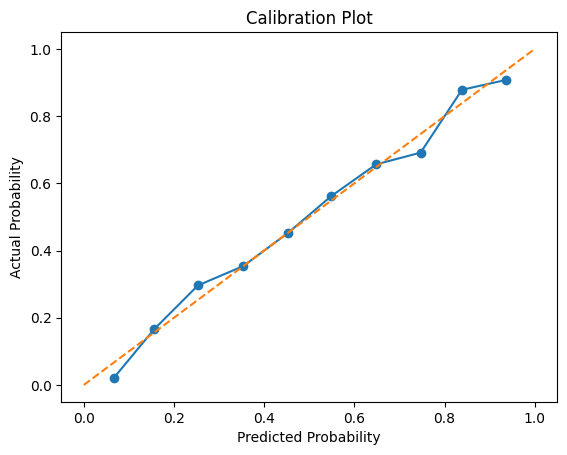

In [360]:
prob_true, prob_pred = calibration_curve(test_y_true, test_predictions, n_bins=10)



plt.figure()
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')  # Perfect calibration line
plt.title('Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Probability')
plt.show()

0.21331734503451608


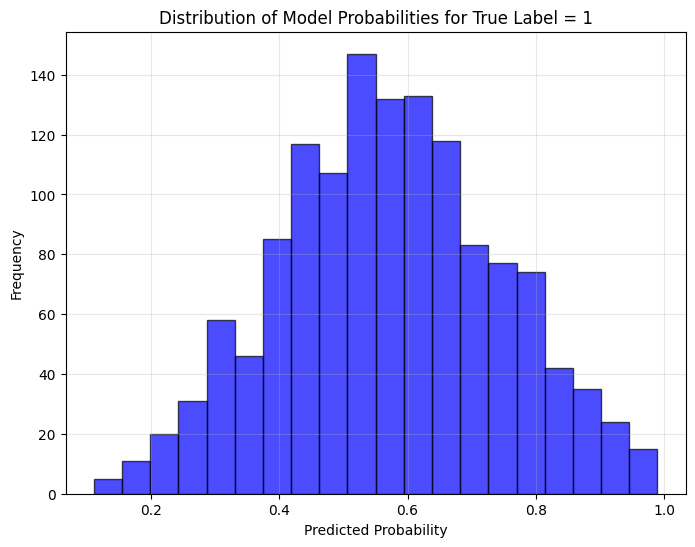

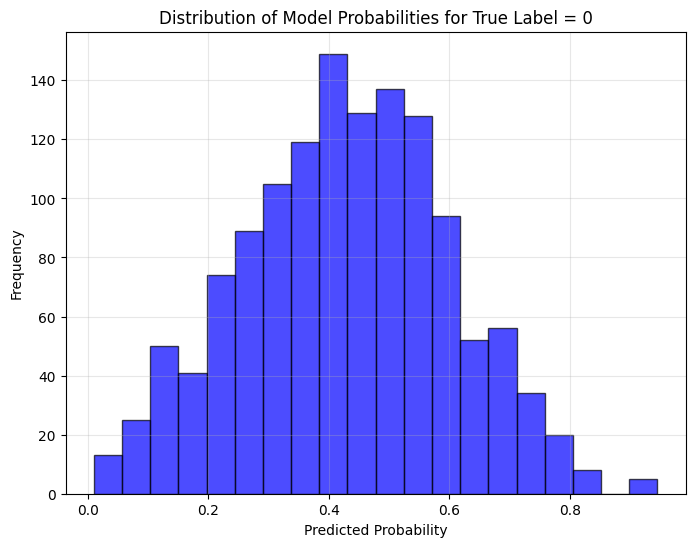

In [261]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_true contains true labels and y_pred contains model probabilities
# Filter probabilities where the true label is 1
true_positive_probs = np.concatenate([p for p, y in zip(test_predictions, test_y_true) if y == 1])
print(brier_score_loss(test_y_true, test_predictions))
# Plot the distribution
plt.figure(figsize=(8, 6))
plt.hist(true_positive_probs, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Model Probabilities for True Label = 1")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

true_positive_probs = np.concatenate([p for p, y in zip(test_predictions, test_y_true) if y == 0])
# Plot the distribution
plt.figure(figsize=(8, 6))
plt.hist(true_positive_probs, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Model Probabilities for True Label = 0")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

In [344]:
brier_scores = 0
set_seed(42)

for fold, (train_idx, val_idx) in enumerate(tscv.split(train_data)):
    print(f"Fold {fold + 1}")

    # --- DATA SPLITTING ---
    train_fold = train_data.iloc[train_idx]
    val_fold = train_data.iloc[val_idx]
    print(train_idx[0], train_idx[-1], val_idx[0], val_idx[-1])

    # Use the function to prepare DataLoaders
    train_loader, val_loader = prepare_dataloaders(
        train_fold, val_fold, player1_cols, player2_cols, env_cols, batch_size=32
    )
    
    # Initialize the model
    model = SymmetricNNWithoutEmbeddings(
            player_feature_size=player1_train.shape[1],
            env_feature_size=env_train.shape[1],
            hidden_sizes=[1024, 512],
            dropout=np.float64(0.09498898337803285)
    )
    
    # Initialize weights
    def initialize_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)
    model.apply(initialize_weights)
    
    # Optimizer and Loss
    optimizer = torch.optim.Adam(model.parameters(), lr=np.float64(0.0009535001707660487), weight_decay=np.float64(3.211367324838775e-06))
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.4)
    criterion = nn.BCELoss()

    
    best_epoch_brier_score = float('inf')
    # Training loop with early stopping
    for epoch in range(40):
        model.train()
        for p1, p2, env, labels in train_loader:
            optimizer.zero_grad()
            predictions = model(p1, p2, env)
            loss = criterion(predictions, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        # Validation loop
        cpu_rng_state = torch.get_rng_state()
        model.eval()
        val_predictions = []
        val_y_true = []

        with torch.no_grad():
            for p1, p2, env, labels in val_loader:
                predictions = model(p1, p2, env)
                val_predictions.extend(predictions.tolist())
                val_y_true.extend(labels.tolist())

        # Reshape predictions and labels
        val_predictions = np.array(val_predictions).reshape(-1, 1)
        val_y_true = np.array(val_y_true)
        val_y_true = np.ravel(val_y_true)  # Reshape labels to 1D
       
        # Brier score with calibrated probabilities
        brier_score = brier_score_loss(val_y_true, val_predictions)
        print(brier_score)
        scheduler.step(brier_score)


        # Save best model based on calibrated Brier score
        if brier_score < best_epoch_brier_score:
            best_epoch_brier_score = brier_score
        torch.set_rng_state(cpu_rng_state)
        
    print(f"Best BS for this fold: Brier Score: {best_epoch_brier_score:.4f}")
    brier_scores+=best_epoch_brier_score

print(f"Best BS for this config: Brier Score: {brier_scores / 4:.4f}")


Fold 1
0 1759 1760 3515
0.2248687688704313
0.2211938984065668
0.22393281924140818
0.2223358131492972
0.2229744153108705
0.2192087141425401
0.2216528582283279
0.22097080223641571
0.22192996165103693
0.22253946183721282
0.22302082952688296
0.22466684695564523
0.2284725923340583
0.2287183071514878
0.2300103287383007
0.23039875530715037
0.23217077513999435
0.23355424376229675
0.23397268509246144
0.23370898728412565
0.23465134017402423
0.23560175987805523
0.23563936282224138
0.2356976655122468
0.23606124086749
0.236140615675659
0.23627563409998278
0.23629009778814095
0.2364912932074622
0.23658199934947677
0.23664083224127588
0.23664648267560798
0.23670152817963636
0.23672424670625664
0.2367398065067768
0.23674943265630094
0.23676340748376445
0.23677315045493333
0.23678073826234677
0.23678729544108584
Best BS for this fold: Brier Score: 0.2192
Fold 2
0 3515 3516 5271
0.2165950635765998
0.2126712280673693
0.21397465338166208
0.21316813702277224
0.21539511446893478
0.21559771104708134
0.213746

In [227]:
brier_scores = 0
set_seed(42)

for fold, (train_idx, val_idx) in enumerate(tscv.split(train_data)):
    print(f"Fold {fold + 1}")

    # --- DATA SPLITTING ---
    train_fold = train_data.iloc[train_idx]
    val_fold = train_data.iloc[val_idx]
    print(train_idx[0], train_idx[-1], val_idx[0], val_idx[-1])

    # Use the function to prepare DataLoaders
    train_loader, val_loader = prepare_dataloaders(
        train_fold, val_fold, player1_cols, player2_cols, env_cols, batch_size=32
    )
    
    # Model
    model = SymmetricNNWithoutEmbeddings(
        player_feature_size=player1_train.shape[1],
        env_feature_size=env_train.shape[1],
        hidden_sizes=[64],
        dropout=np.float64(0.17703961111425218)
    )
       # Initialize weights
    def initialize_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)
    model.apply(initialize_weights)
    
    # Optimizer and Loss
    optimizer = torch.optim.Adam(model.parameters(), lr=np.float64(0.008187941582538088), weight_decay=np.float64(0.0006804550904198494))
    criterion = nn.BCELoss()
    
    best_epoch_brier_score = float('inf')
    # Training loop with early stopping
    for epoch in range(40):
        model.train()
        for p1, p2, env, labels in train_loader:
            optimizer.zero_grad()
            predictions = model(p1, p2, env)
            loss = criterion(predictions, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        # Validation loop
        cpu_rng_state = torch.get_rng_state()
        model.eval()
        val_predictions = []
        val_y_true = []

        with torch.no_grad():
            for p1, p2, env, labels in val_loader:
                predictions = model(p1, p2, env)
                val_predictions.extend(predictions.tolist())
                val_y_true.extend(labels.tolist())

        # Reshape predictions and labels
        val_predictions = np.array(val_predictions).reshape(-1, 1)
        val_y_true = np.array(val_y_true)
        val_y_true = np.ravel(val_y_true)  # Reshape labels to 1D
       
        # Brier score with calibrated probabilities
        brier_score = brier_score_loss(val_y_true, val_predictions)


        # Save best model based on calibrated Brier score
        if brier_score < best_epoch_brier_score:
            best_epoch_brier_score = brier_score
        torch.set_rng_state(cpu_rng_state)
        
    print(f"Best BS for this fold: Brier Score: {best_epoch_brier_score:.4f}")
    brier_scores+=best_epoch_brier_score

print(f"Best BS for this config: Brier Score: {brier_scores / 3:.4f}")


Fold 1
0 2195 2196 4391
Best BS for this fold: Brier Score: 0.2163
Fold 2
0 4391 4392 6587
Best BS for this fold: Brier Score: 0.2133
Fold 3
0 6587 6588 8783
Best BS for this fold: Brier Score: 0.2075
Best BS for this config: Brier Score: 0.2124


### Uncertainty

In [128]:
squared_errors = (calibrated_probs - val_y_true) ** 2

In [31]:
val_indices = val_loader.dataset.indices  # Indices of validation data

# Step 2: Filter the matches DataFrame using validation indices
val_matches = matches.iloc[val_indices]

uncertainty_features = val_matches[[
    'num_CO_matches',     # Matches with common opponents
    'tournament_level',           # Tournament importance
]]

AttributeError: 'TensorDataset' object has no attribute 'indices'

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
uncertainty_features = scaler.fit_transform(uncertainty_features)


In [27]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
regressor.fit(uncertainty_features, squared_errors)  # Predict errors

ValueError: Found input variables with inconsistent numbers of samples: [14111, 2258]

In [41]:
from sklearn.model_selection import ParameterSampler
import scipy.stats as stats
import copy
import torch.nn.functional as F
set_seed(42)

# Parameter grid for random search
param_grid = {
    'learning_rate': stats.loguniform(1e-4, 1e-3),
    'dropout': stats.uniform(0.15, 0.15),  
    'hidden_layer_sizes': [
        [256, 128, 64], [256, 128], [128, 64], [64, 32]
    ],
    'embedding_size': [16],
    'embedding_hidden_layer_sizes': [[32], [64], [128]],  
    'batch_size': [64, 128],
    'weight_decay': stats.loguniform(1e-5, 1e-4),
    'optimizer': ['Adam', 'SGD'] 
}


# Generate random hyperparameter samples
n_samples = 100
random_params = list(ParameterSampler(param_grid, n_iter=n_samples, random_state=42))

# Training and evaluation function
def train_and_evaluate(params):
    print(f"Testing configuration: {params}")
    
    # Extract parameters
    learning_rate = params['learning_rate']
    dropout = params['dropout']
    hidden_layer_sizes = params['hidden_layer_sizes']
    batch_size = params['batch_size']
    weight_decay = params['weight_decay']
    optimizer_choice = params['optimizer']
    embedding_size = params['embedding_size']
    eb_hidden_layer_sizes = params['embedding_hidden_layer_sizes']
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Model
    model = SymmetricNNWithEnvInteraction(
        player_feature_size=player1_train.shape[1],
        env_feature_size=env_train.shape[1],
        embedding_size=embedding_size,
        hidden_sizes=hidden_layer_sizes,
        embedding_hidden_sizes=eb_hidden_layer_sizes,
        dropout=dropout
    )
    
    # Initialize weights
    def initialize_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)
    model.apply(initialize_weights)

    # Optimizer
    if optimizer_choice == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_choice == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    elif optimizer_choice == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Loss function
    criterion = nn.BCELoss()
    
    best_epoch_logloss = float('inf')
    best_model_state = None
     # Training loop
    for epoch in range(40):
        model.train()
        for p1, p2, env, labels in train_loader:
            optimizer.zero_grad()
            predictions = model(p1, p2, env)
            loss = criterion(predictions, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        # Validation loop to calculate Log Loss after each epoch
        model.eval()
        val_predictions = []
        val_y_true = []

        with torch.no_grad():
            for p1, p2, env, labels, avgW, avgL in val_loader:
                predictions = model(p1, p2, env)
                val_predictions.extend(predictions.tolist())
                val_y_true.extend(labels.tolist())

        # Calculate Log Loss for this epoch
        val_predictions = torch.tensor(val_predictions)
        val_y_true = torch.tensor(val_y_true)
        logloss = F.binary_cross_entropy(val_predictions, val_y_true).item()
        
        # Update the best Log Loss if improved
        if logloss < best_epoch_logloss:
            best_epoch_logloss = logloss
            best_model_state = copy.deepcopy(model.state_dict())
    print(f"Best Validation Log Loss for this configuration: {best_epoch_logloss:.4f}")
    return best_epoch_logloss, best_model_state

# Run random search
best_params = None
best_val_logloss = float('inf')  # Start with infinity for minimization
best_model_state = None

for params in random_params:
    val_logloss, model_state = train_and_evaluate(params)
    if val_logloss < best_val_logloss:
        best_val_logloss = val_logloss
        best_params = params
        best_model_state = model_state

# Save the best model weights and configuration
if best_model_state is not None:
    torch.save(best_model_state, os.path.join("best_models", "best_model_weights.pth"))
    with open(os.path.join("best_models", "best_config.txt"), "w") as f:
        f.write(f"Best Configuration:\n{best_params}\n")
        f.write(f"Best Validation Log Loss: {best_val_logloss:.4f}\n")

print(f"Best Configuration: {best_params}")
print(f"Best Validation Log Loss: {best_val_logloss:.4f}")


Testing configuration: {'batch_size': 64, 'dropout': np.float64(0.42879004540108145), 'embedding_hidden_layer_sizes': [128], 'embedding_size': 16, 'hidden_layer_sizes': [128, 64], 'learning_rate': np.float64(0.0006021310185147607), 'optimizer': 'Adam', 'weight_decay': np.float64(1.4322493718230246e-05)}
Best Validation Log Loss for this configuration: 0.6214
Testing configuration: {'batch_size': 64, 'dropout': np.float64(0.18499122053630102), 'embedding_hidden_layer_sizes': [128], 'embedding_size': 16, 'hidden_layer_sizes': [64, 32], 'learning_rate': np.float64(0.00021562971611854283), 'optimizer': 'SGD', 'weight_decay': np.float64(5.105903209394759e-05)}
Best Validation Log Loss for this configuration: 0.6352
Testing configuration: {'batch_size': 128, 'dropout': np.float64(0.16974405265948508), 'embedding_hidden_layer_sizes': [64], 'embedding_size': 16, 'hidden_layer_sizes': [256, 128], 'learning_rate': np.float64(0.00010017947833154713), 'optimizer': 'SGD', 'weight_decay': np.float64

In [50]:
from sklearn.model_selection import ParameterSampler
import scipy.stats as stats
import copy
import torch.nn.functional as F
set_seed(42)

# Parameter grid for random search
param_grid = {
    'learning_rate': stats.loguniform(2e-4, 6e-4),  # Narrowed range
    'dropout': stats.uniform(0.15, 0.15),  # Avoid high dropout
    'hidden_layer_sizes': [
        [64, 32], [128, 64], [256, 128]
    ],  # Fewer layers with 32–256 neurons
    'embedding_size': [16],
    'embedding_hidden_layer_sizes': [[32], [64]],  # Smaller embedding layers
    'batch_size': [64, 128],  # Focus on 64, keep 128 as fallback
    'weight_decay': stats.loguniform(1e-5, 5e-5),  # Avoid high values
    'optimizer': ['Adam'],  # Focus on Adam
}



# Generate random hyperparameter samples
n_samples = 100
random_params = list(ParameterSampler(param_grid, n_iter=n_samples, random_state=42))

# Training and evaluation function
def train_and_evaluate(params):
    print(f"Testing configuration: {params}")
    
    # Extract parameters
    learning_rate = params['learning_rate']
    dropout = params['dropout']
    hidden_layer_sizes = params['hidden_layer_sizes']
    batch_size = params['batch_size']
    weight_decay = params['weight_decay']
    optimizer_choice = params['optimizer']
    embedding_size = params['embedding_size']
    eb_hidden_layer_sizes = params['embedding_hidden_layer_sizes']
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Model
    model = SymmetricNNWithEnvInteraction(
        player_feature_size=player1_train.shape[1],
        env_feature_size=env_train.shape[1],
        embedding_size=embedding_size,
        hidden_sizes=hidden_layer_sizes,
        embedding_hidden_sizes=eb_hidden_layer_sizes,
        dropout=dropout
    )
    
    # Initialize weights
    def initialize_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)
    model.apply(initialize_weights)

    # Optimizer
    if optimizer_choice == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_choice == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    elif optimizer_choice == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Loss function
    criterion = nn.BCELoss()
    
    best_epoch_logloss = float('inf')
    best_brier_score = float('inf')
    best_model_state = None
     # Training loop
    for epoch in range(40):
        model.train()
        for p1, p2, env, labels in train_loader:
            optimizer.zero_grad()
            predictions = model(p1, p2, env)
            loss = criterion(predictions, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        # Validation loop to calculate Log Loss after each epoch
        model.eval()
        val_predictions = []
        val_y_true = []

        with torch.no_grad():
            for p1, p2, env, labels, avgW, avgL in val_loader:
                predictions = model(p1, p2, env)
                val_predictions.extend(predictions.tolist())
                val_y_true.extend(labels.tolist())

        # Calculate Log Loss for this epoch
        val_predictions = torch.tensor(val_predictions)
        val_y_true = torch.tensor(val_y_true)
        logloss = F.binary_cross_entropy(val_predictions, val_y_true).item()
        brier_score = brier_score_loss(val_y_true, val_predictions)
        if brier_score < best_brier_score:
                best_brier_score = brier_score
        
        # Update the best Log Loss if improved
        if logloss < best_epoch_logloss:
            best_epoch_logloss = logloss
            best_model_state = copy.deepcopy(model.state_dict())
    print(f"Best Validation Log Loss for this configuration: {best_epoch_logloss:.4f}")
    print(f"Best Brier Score for this configuration: {best_brier_score:.4f}")
    return best_epoch_logloss, best_model_state

# Run random search
best_params = None
best_val_logloss = float('inf')  # Start with infinity for minimization
best_model_state = None

for params in random_params:
    val_logloss, model_state = train_and_evaluate(params)
    if val_logloss < best_val_logloss:
        best_val_logloss = val_logloss
        best_params = params
        best_model_state = model_state

# Save the best model weights and configuration
# if best_model_state is not None:
#     torch.save(best_model_state, os.path.join("best_models", "best_model_weights.pth"))
#     with open(os.path.join("best_models", "best_config.txt"), "w") as f:
#         f.write(f"Best Configuration:\n{best_params}\n")
#         f.write(f"Best Validation Log Loss: {best_val_logloss:.4f}\n")

print(f"Best Configuration: {best_params}")
print(f"Best Validation Log Loss: {best_val_logloss:.4f}")


Testing configuration: {'batch_size': 64, 'dropout': np.float64(0.2694814480290349), 'embedding_hidden_layer_sizes': [32], 'embedding_size': 16, 'hidden_layer_sizes': [256, 128], 'learning_rate': np.float64(0.00047101760950972487), 'optimizer': 'Adam', 'weight_decay': np.float64(2.6132463801565116e-05)}
Best Validation Log Loss for this configuration: 0.6218
Best Brier Score for this configuration: 0.2173
Testing configuration: {'batch_size': 128, 'dropout': np.float64(0.1733991780504304), 'embedding_hidden_layer_sizes': [32], 'embedding_size': 16, 'hidden_layer_sizes': [256, 128], 'learning_rate': np.float64(0.0005179657521056343), 'optimizer': 'Adam', 'weight_decay': np.float64(2.631245451057452e-05)}
Best Validation Log Loss for this configuration: 0.6268
Best Brier Score for this configuration: 0.2194
Testing configuration: {'batch_size': 128, 'dropout': np.float64(0.24763327094232793), 'embedding_hidden_layer_sizes': [32], 'embedding_size': 16, 'hidden_layer_sizes': [128, 64], 'le

KeyboardInterrupt: 

In [25]:
from sklearn.model_selection import ParameterSampler
import scipy.stats as stats
set_seed(42)

# Parameter grid for random search
param_grid = {
    'learning_rate': stats.loguniform(1e-4, 1e-2),
    'dropout': stats.uniform(0.2, 0.4),
    'hidden_layer_sizes': [
        [128], [256, 128], [64], [32], [16, 8], [64, 32], [64, 64], [64, 32, 16], [32,32], [128,128], [64,16]
    ],
    'batch_size': [32, 64, 128],
    'weight_decay': stats.loguniform(1e-6, 1e-5),
    'optimizer': ['Adam', 'SGD'],
    'embedding_size': [4,8,16],
    'embedding_hidden_layer_sizes': [[128], [256, 128], [64], [32], [16, 8], [64, 32], [16]]
}

# Generate random hyperparameter samples
n_samples = 200
random_params = list(ParameterSampler(param_grid, n_iter=n_samples, random_state=42))

# Training and evaluation function
def train_and_evaluate(params):
    print(f"Testing configuration: {params}")
    
    # Extract parameters
    learning_rate = params['learning_rate']
    dropout = params['dropout']
    hidden_layer_sizes = params['hidden_layer_sizes']
    batch_size = params['batch_size']
    weight_decay = params['weight_decay']
    optimizer_choice = params['optimizer']
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Model
    model = SymmetricNNWithEnvInteraction(
        player_feature_size=player1_train.shape[1],
        env_feature_size=env_train.shape[1],
        embedding_size=8,
        hidden_sizes=hidden_layer_sizes,
        dropout=dropout
    )
    
    # Initialize weights
    def initialize_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)
    model.apply(initialize_weights)

    # Optimizer
    if optimizer_choice == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_choice == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    elif optimizer_choice == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


    # Loss function
    criterion = nn.BCELoss()

     # Training loop
    for epoch in range(20):
        model.train()
        for p1, p2, env, labels in train_loader:
            optimizer.zero_grad()
            predictions = model(p1, p2, env)
            loss = criterion(predictions, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
    
    # Validation loop to calculate ROI
    model.eval()
    val_predictions = []
    val_y_true = []
    val_avgW = []
    val_avgL = []

    with torch.no_grad():
        for p1, p2, env, labels, avgW, avgL in val_loader:
            predictions = model(p1, p2, env)
            val_predictions.extend(predictions.tolist())
            val_y_true.extend(labels.tolist())
            val_avgW.extend(avgW.tolist())
            val_avgL.extend(avgL.tolist())

    # Calculate ROI
    roi = calculate_roi(val_predictions, val_avgW, val_avgL, val_y_true, max_bet=1.0)
    print(f"Validation ROI for this configuration: {roi:.4%}")
    return roi, model

# Run random search
best_params = None
best_val_roi = float('-inf')  # Start with negative infinity for maximization
best_model = None

for params in random_params:
    val_roi, model = train_and_evaluate(params)
    if val_roi > best_val_roi:
        best_val_roi = val_roi
        best_params = params
        best_model = model

# Save the best model weights and configuration
if best_model is not None:
    torch.save(best_model.state_dict(), os.path.join("best_models", "best_model_weights2.pth"))
    with open(os.path.join("best_models", "best_config2.txt"), "w") as f:
        f.write(f"Best Configuration:\n{best_params}\n")
        f.write(f"Best Validation ROI: {best_val_roi:.4%}\n")

print(f"Best Configuration: {best_params}")
print(f"Best Validation ROI: {best_val_roi:.4%}")

Testing configuration: {'batch_size': 128, 'dropout': np.float64(0.5186171947440932), 'embedding_hidden_layer_sizes': [16], 'embedding_size': 16, 'hidden_layer_sizes': [64, 32, 16], 'learning_rate': np.float64(0.0015751320499779737), 'optimizer': 'Adam', 'weight_decay': np.float64(2.7914686374528733e-06)}
Validation ROI for this configuration: 6.1374%
Testing configuration: {'batch_size': 128, 'dropout': np.float64(0.2232334448672798), 'embedding_hidden_layer_sizes': [16, 8], 'embedding_size': 16, 'hidden_layer_sizes': [64, 32], 'learning_rate': np.float64(0.00012966511753760416), 'optimizer': 'SGD', 'weight_decay': np.float64(6.798962421591126e-06)}
Validation ROI for this configuration: 7.2305%
Testing configuration: {'batch_size': 64, 'dropout': np.float64(0.20031150633640574), 'embedding_hidden_layer_sizes': [32], 'embedding_size': 4, 'hidden_layer_sizes': [128], 'learning_rate': np.float64(0.0004059611610484307), 'optimizer': 'SGD', 'weight_decay': np.float64(1.0164038588691218e-0

In [1]:
print(best_params)

NameError: name 'best_params' is not defined

In [18]:
from sklearn.model_selection import ParameterSampler
import scipy.stats as stats
set_seed(42)

# Parameter grid for random search
param_grid = {
    'learning_rate': stats.loguniform(1e-4, 1e-2),
    'dropout': stats.uniform(0.2, 0.4),
    'hidden_layer_sizes': [
        [128], [256, 128], [64], [32], [16, 8], [64, 32], [64, 64], [64, 32, 16], [32,32], [128,128], [64,16]
    ],
    'batch_size': [32, 64, 128],
    'weight_decay': stats.loguniform(1e-6, 1e-5),
    'optimizer': ['Adam', 'SGD'],
    'embedding_size': [8,16],
    'embedding_hidden_layer_sizes': [[128], [64], [32], [16, 8], [64, 32], [16]]
}

# Generate random hyperparameter samples
n_samples = 400
random_params = list(ParameterSampler(param_grid, n_iter=n_samples, random_state=42))

# Training and evaluation function
def train_and_evaluate(params):
    print(f"Testing configuration: {params}")
    
    # Extract parameters
    learning_rate = params['learning_rate']
    dropout = params['dropout']
    hidden_layer_sizes = params['hidden_layer_sizes']
    batch_size = params['batch_size']
    weight_decay = params['weight_decay']
    optimizer_choice = params['optimizer']
    embedding_size = params['embedding_size']
    embedding_hidden_layer_sizes = params['embedding_hidden_layer_sizes']
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Model
    model = SymmetricNNWithEnvInteraction(
        player_feature_size=player1_train.shape[1],
        env_feature_size=env_train.shape[1],
        hidden_sizes=hidden_layer_sizes,
        dropout=dropout,
        embedding_size=embedding_size,
        embedding_hidden_sizes=embedding_hidden_layer_sizes
    )
    
    # Initialize weights
    def initialize_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)
    model.apply(initialize_weights)

    # Optimizer
    if optimizer_choice == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_choice == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    elif optimizer_choice == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


    # Loss function
    criterion = nn.BCELoss()

     # Training loop
    for epoch in range(20):
        model.train()
        for p1, p2, env, labels in train_loader:
            optimizer.zero_grad()
            predictions = model(p1, p2, env)
            loss = criterion(predictions, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
    
    # Validation loop to calculate ROI
    model.eval()
    val_predictions = []
    val_y_true = []
    val_avgW = []
    val_avgL = []

    with torch.no_grad():
        for p1, p2, env, labels, avgW, avgL in val_loader:
            predictions = model(p1, p2, env)
            val_predictions.extend(predictions.tolist())
            val_y_true.extend(labels.tolist())
            val_avgW.extend(avgW.tolist())
            val_avgL.extend(avgL.tolist())

    # Calculate ROI
    roi = calculate_roi(val_predictions, val_avgW, val_avgL, val_y_true, max_bet=1.0)
    print(f"Validation ROI for this configuration: {roi:.4%}")
    return roi, model

# Run random search
best_params = None
best_val_roi = float('-inf')  # Start with negative infinity for maximization
best_model = None

for params in random_params:
    val_roi, model = train_and_evaluate(params)
    if val_roi > best_val_roi:
        best_val_roi = val_roi
        best_params = params
        best_model = model

# Save the best model weights and configuration
if best_model is not None:
    torch.save(best_model.state_dict(), os.path.join("best_models", "best_model_weights3.pth"))
    with open(os.path.join("best_models", "best_config3.txt"), "w") as f:
        f.write(f"Best Configuration:\n{best_params}\n")
        f.write(f"Best Validation ROI: {best_val_roi:.4%}\n")

print(f"Best Configuration: {best_params}")
print(f"Best Validation ROI: {best_val_roi:.4%}")

Testing configuration: {'batch_size': 128, 'dropout': np.float64(0.5186171947440932), 'embedding_hidden_layer_sizes': [32], 'embedding_size': 16, 'hidden_layer_sizes': [16, 8], 'learning_rate': np.float64(0.0002051338263087451), 'optimizer': 'Adam', 'weight_decay': np.float64(1.258852700296548e-06)}
Validation ROI for this configuration: -5.1196%
Testing configuration: {'batch_size': 128, 'dropout': np.float64(0.5464704583099741), 'embedding_hidden_layer_sizes': [16, 8], 'embedding_size': 16, 'hidden_layer_sizes': [64, 32, 16], 'learning_rate': np.float64(0.0020034427927560737), 'optimizer': 'Adam', 'weight_decay': np.float64(9.330606024425669e-06)}
Validation ROI for this configuration: 11.4912%
Testing configuration: {'batch_size': 64, 'dropout': np.float64(0.28493564427131046), 'embedding_hidden_layer_sizes': [16, 8], 'embedding_size': 8, 'hidden_layer_sizes': [128], 'learning_rate': np.float64(0.0004059611610484307), 'optimizer': 'SGD', 'weight_decay': np.float64(1.0164038588691218

In [48]:
from sklearn.model_selection import ParameterSampler
import scipy.stats as stats
set_seed(42)

# Parameter grid for random search
param_grid = {
    'learning_rate': stats.loguniform(1e-4, 1e-2),
    'dropout': stats.uniform(0.2, 0.4),
    'hidden_layer_sizes': [
        [128], [256, 128], [64], [32], [16, 8], [64, 32], [64, 64], [64, 32, 16], [32,32], [128,128], [64,16]
    ],
    'batch_size': [32, 64, 128],
    'weight_decay': stats.loguniform(1e-6, 1e-5),
    'optimizer': ['Adam', 'SGD'],
    'embedding_size': [8,16],
    'embedding_hidden_layer_sizes': [[128], [64], [32], [16, 8], [64, 32], [16]]
}

# Generate random hyperparameter samples
n_samples = 2000
random_params = list(ParameterSampler(param_grid, n_iter=n_samples, random_state=42))

# Training and evaluation function
def train_and_evaluate(params):
    print(f"Testing configuration: {params}")
    
    # Extract parameters
    learning_rate = params['learning_rate']
    dropout = params['dropout']
    hidden_layer_sizes = params['hidden_layer_sizes']
    batch_size = params['batch_size']
    weight_decay = params['weight_decay']
    optimizer_choice = params['optimizer']
    embedding_size = params['embedding_size']
    embedding_hidden_layer_sizes = params['embedding_hidden_layer_sizes']
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Model
    model = SymmetricNNWithEnvInteraction(
        player_feature_size=player1_train.shape[1],
        env_feature_size=env_train.shape[1],
        hidden_sizes=hidden_layer_sizes,
        dropout=dropout,
        embedding_size=embedding_size,
        embedding_hidden_sizes=embedding_hidden_layer_sizes
    )
    
    # Initialize weights
    def initialize_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)
    model.apply(initialize_weights)

    # Optimizer
    if optimizer_choice == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_choice == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    elif optimizer_choice == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


    # Loss function
    criterion = nn.BCELoss()
    
    best_epoch_roi = float('-inf')
    best_model_state = None
     # Training loop
    for epoch in range(20):
        model.train()
        for p1, p2, env, labels in train_loader:
            optimizer.zero_grad()
            predictions = model(p1, p2, env)
            loss = criterion(predictions, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        # Validation loop to calculate ROI after each epoch
        model.eval()
        val_predictions = []
        val_y_true = []
        val_avgW = []
        val_avgL = []

        with torch.no_grad():
            for p1, p2, env, labels, avgW, avgL in val_loader:
                predictions = model(p1, p2, env)
                val_predictions.extend(predictions.tolist())
                val_y_true.extend(labels.tolist())
                val_avgW.extend(avgW.tolist())
                val_avgL.extend(avgL.tolist())
            
        # Calculate ROI for this epoch
        roi = calculate_roi(val_predictions, val_avgW, val_avgL, val_y_true, max_bet=1.0)
        
        # Update the best ROI if improved
        if roi > best_epoch_roi:
            best_epoch_roi = roi
            best_model_state = model.state_dict()
    
    print(f"Best Validation ROI for this configuration: {best_epoch_roi:.4%}")
    return best_epoch_roi, best_model_state

# Run random search
best_params = None
best_val_roi = float('-inf')  # Start with negative infinity for maximization
best_model_state = None

for params in random_params:
    val_roi, model_state = train_and_evaluate(params)
    if val_roi > best_val_roi:
        best_val_roi = val_roi
        best_params = params
        best_model_state = model_state

# Save the best model weights and configuration
if best_model_state is not None:
    torch.save(best_model_state, os.path.join("best_models", "best_model_weights4.pth"))
    with open(os.path.join("best_models", "best_config4.txt"), "w") as f:
        f.write(f"Best Configuration:\n{best_params}\n")
        f.write(f"Best Validation ROI: {best_val_roi:.4%}\n")

print(f"Best Configuration: {best_params}")
print(f"Best Validation ROI: {best_val_roi:.4%}")

Testing configuration: {'batch_size': 128, 'dropout': np.float64(0.5186171947440932), 'embedding_hidden_layer_sizes': [32], 'embedding_size': 16, 'hidden_layer_sizes': [16, 8], 'learning_rate': np.float64(0.0002051338263087451), 'optimizer': 'Adam', 'weight_decay': np.float64(1.258852700296548e-06)}
Best Validation ROI for this configuration: 0.8646%
Testing configuration: {'batch_size': 128, 'dropout': np.float64(0.5464704583099741), 'embedding_hidden_layer_sizes': [16, 8], 'embedding_size': 16, 'hidden_layer_sizes': [64, 32, 16], 'learning_rate': np.float64(0.0020034427927560737), 'optimizer': 'Adam', 'weight_decay': np.float64(9.330606024425669e-06)}
Best Validation ROI for this configuration: 4.5671%
Testing configuration: {'batch_size': 64, 'dropout': np.float64(0.28493564427131046), 'embedding_hidden_layer_sizes': [16, 8], 'embedding_size': 8, 'hidden_layer_sizes': [128], 'learning_rate': np.float64(0.0004059611610484307), 'optimizer': 'SGD', 'weight_decay': np.float64(1.01640385

### Robimy diff dla player_features

In [33]:
list(matches.columns)

['outdoor',
 'player1_bet_odds',
 'player2_bet_odds',
 'tournament_level',
 'player1_right_handed',
 'player1_age',
 'player2_right_handed',
 'player2_age',
 'best_of',
 'player1_rank',
 'player2_rank',
 'player1_entry_LL',
 'player1_entry_Q',
 'player1_entry_WC',
 'player2_entry_LL',
 'player2_entry_Q',
 'player2_entry_WC',
 'player1_is_seeded',
 'player2_is_seeded',
 'num_CO_matches',
 'player1_CO_1st_serve_in_pct_avg',
 'player2_CO_1st_serve_in_pct_avg',
 'player1_1st_serve_in_pct_avg',
 'player2_1st_serve_in_pct_avg',
 'player1_CO_1st_serve_win_pct_avg',
 'player2_CO_1st_serve_win_pct_avg',
 'player1_1st_serve_win_pct_avg',
 'player2_1st_serve_win_pct_avg',
 'player1_CO_2nd_serve_win_pct_avg',
 'player2_CO_2nd_serve_win_pct_avg',
 'player1_2nd_serve_win_pct_avg',
 'player2_2nd_serve_win_pct_avg',
 'player1_CO_serve_games_win_pct_avg',
 'player2_CO_serve_games_win_pct_avg',
 'player1_serve_games_win_pct_avg',
 'player2_serve_games_win_pct_avg',
 'player1_CO_ace_avg',
 'player2_CO_ac

In [76]:
pweather_cols = ['temperature_2m', 'relative_humidity_2m','windspeed_10m','apparent_temperature']
player1_cols = [col for col in matches.columns if col.startswith('player1_') and "bet" not in col and not ("avg" in col and "CO" not in col)]
player2_cols = [col for col in matches.columns if col.startswith('player2_') and "bet" not in col and not ("avg" in col and "CO" not in col)]
env_cols = [col for col in matches.columns if not  col.startswith('player') and col not in player1_cols and col not in player2_cols and "diff" not in col and "CO" not in col and "target" not in col and "bet" not in col]
target_col = 'target'
player1_bet = 'player1_bet_odds'
player2_bet = 'player2_bet_odds'
player1_cols

['player1_right_handed',
 'player1_age',
 'player1_rank',
 'player1_entry_LL',
 'player1_entry_Q',
 'player1_entry_WC',
 'player1_is_seeded',
 'player1_CO_1st_serve_in_pct_avg',
 'player1_CO_1st_serve_win_pct_avg',
 'player1_CO_2nd_serve_win_pct_avg',
 'player1_CO_serve_games_win_pct_avg',
 'player1_CO_ace_avg',
 'player1_CO_df_avg',
 'player1_CO_1st_serve_return_win_pct_avg',
 'player1_elo',
 'player1_surface_elo',
 'player1_blended_elo',
 'player1_fatigue_score',
 'player1_h2h_wins',
 'player1_home',
 'player1_injury_score',
 'player1_win_pct_last_10',
 'player1_win_pct_last_10_surface',
 'player1_Set_Diff_Tournament',
 'player1_Game_Diff_Tournament',
 'player1_total_wins_tournament_history',
 'player1_total_losses_tournament_history']

In [77]:
player_features_cols = [col.replace('player1_', '') for col in player1_cols]
diff_features = {f'{col}_diff': matches[f'player1_{col}'] - matches[f'player2_{col}'] for col in player_features_cols}.values
diff_features

<function dict.values>

In [78]:
player1_features = matches[player1_cols].values  # Convert to numpy array
player2_features = matches[player2_cols].values
player_features = player1_features - player2_features
env_features = matches[env_cols].values
match_outcomes = matches[target_col].values  # Target (1 for player1 win, 0 for player2 win)

In [79]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
player_features = scaler.fit_transform(player_features)  
env_features = scaler.fit_transform(env_features)

In [80]:
class SymmetricNNWithDiffFeatures(nn.Module):
    def __init__(self, player_feature_size, env_feature_size, hidden_sizes, dropout):
        super(SymmetricNNWithDiffFeatures, self).__init__()

        # Input size: combined player features + environment
        input_size = player_feature_size + env_feature_size

        # Define layers dynamically
        layers = []
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))  # Hidden layer
            layers.append(nn.ReLU())                          # Activation
            layers.append(nn.Dropout(dropout))                # Dropout
            input_size = hidden_size

        # Final output layer
        layers.append(nn.Linear(input_size, 1))  # Single output (probability)
        layers.append(nn.Sigmoid())              # Sigmoid activation for probabilities

        self.network = nn.Sequential(*layers)

    def forward(self, player_features, env_features):
        # Concatenate features (player differences + environment)
        inputs = torch.cat([player_features, env_features], dim=1)

        # Single forward pass since symmetry is inherently encoded
        return self.network(inputs)


In [81]:
import torch

player_features = torch.tensor(player_features, dtype=torch.float32)
env_features = torch.tensor(env_features, dtype=torch.float32)
match_outcomes = torch.tensor(match_outcomes, dtype=torch.float32).unsqueeze(1)  # Add dimension for compatibility
player_features

tensor([[0.5000, 0.7146, 0.4463,  ..., 0.4921, 0.4815, 0.4667],
        [0.5000, 0.5893, 0.4895,  ..., 0.4921, 0.4815, 0.4667],
        [0.0000, 0.7610, 0.4733,  ..., 0.4921, 0.4815, 0.4667],
        ...,
        [0.5000, 0.2761, 0.4176,  ..., 0.4921, 0.4630, 0.3333],
        [1.0000, 0.4455, 0.4963,  ..., 0.4444, 0.4815, 0.2000],
        [0.5000, 0.1879, 0.5005,  ..., 0.6984, 0.4444, 0.2000]])

In [82]:
from sklearn.model_selection import train_test_split

player_train, player_test, env_train, env_test, y_train, y_test, player1_bet_odds_train, player1_bet_odds_test, player2_bet_odds_train, player2_bet_odds_test = train_test_split(
    player_features, env_features, match_outcomes, player1_bet_odds, player2_bet_odds, test_size=0.2, random_state=42, stratify=match_outcomes
)
player_train, player_val, env_train, env_val, y_train, y_val, player1_bet_odds_train, player1_bet_odds_val, player2_bet_odds_train, player2_bet_odds_val = train_test_split(
    player_train,  env_train, y_train, player1_bet_odds_train, player2_bet_odds_train, test_size=0.2, random_state=42, stratify=y_train
)
y_val.unique(return_counts=True)

(tensor([0., 1.]), tensor([1129, 1129]))

In [83]:
print(torch.isnan(player_train).sum())  # Count NaNs in player features
print(torch.isnan(env_train).sum())    # Count NaNs in env features
print(torch.isnan(y_train).sum())      # Count NaNs in labels


tensor(0)
tensor(0)
tensor(0)


uncalibrated brier:  0.22615083085679108
val accuracy:  0.6164747564216121
Epoch 1: Training Loss: 0.6644, Validation Loss: 0.6444, ROI: 110.0000%
uncalibrated brier:  0.22530768617197583
val accuracy:  0.6297608503100088
Epoch 2: Training Loss: 0.6439, Validation Loss: 0.6423, ROI: 110.0000%
uncalibrated brier:  0.23679639119844376
val accuracy:  0.5885739592559788
Epoch 3: Training Loss: 0.6395, Validation Loss: 0.6652, ROI: 110.0000%
uncalibrated brier:  0.22967652000365765
val accuracy:  0.6107174490699734
Epoch 4: Training Loss: 0.6411, Validation Loss: 0.6520, ROI: 110.0000%
uncalibrated brier:  0.22239312578768705
val accuracy:  0.6266607617360496
Epoch 5: Training Loss: 0.6329, Validation Loss: 0.6350, ROI: 110.0000%
uncalibrated brier:  0.22561886954641902
val accuracy:  0.6266607617360496
Epoch 6: Training Loss: 0.6351, Validation Loss: 0.6419, ROI: 110.0000%
uncalibrated brier:  0.23094775847833912
val accuracy:  0.6098317094774136
Epoch 7: Training Loss: 0.6328, Validation 

E:\Pawel\Studia\Inzynierka_Git\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Pawel\Studia\Inzynierka_Git\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Pawel\Studia\Inzynierka_Git\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Pawel\Studia\Inzynierka_Git\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was exp

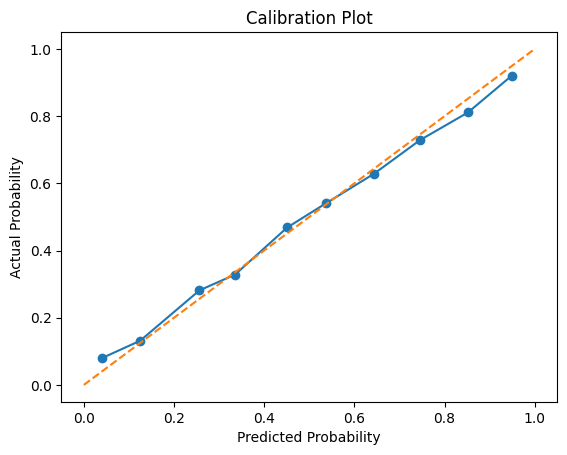

In [86]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch
import random
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
# Set random seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)


train_dataset = TensorDataset(player_train, env_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Validation DataLoader
val_dataset = TensorDataset(player_val, env_val, y_val, player1_bet_odds_val, player2_bet_odds_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Initialize the model
model = SymmetricNNWithDiffFeatures(
    player_feature_size=player_train.shape[1],
    env_feature_size=env_train.shape[1],
    hidden_sizes=[512],
    dropout=np.float64(0.25476497662909336)
)

# Define weight initialization
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(initialize_weights)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=np.float64(0.008841074088520707),  weight_decay=np.float64(5.315656057158321e-06))
criterion = nn.BCELoss()

    
    
 # Training loop
best_val_accuracy = 0.0
for epoch in range(34):
    model.train()
    epoch_loss = 0.0
    for p, env, labels in train_loader:
        optimizer.zero_grad()
        predictions = model(p, env)
        loss = criterion(predictions, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_y_true = []
    val_avgW = []
    val_avgL = []

    with torch.no_grad():
        for p, env, labels, avgW, avgL in val_loader:  # Add avgW, avgL in validation data
            predictions = model(p, env)
            loss = criterion(predictions, labels)
            val_loss += loss.item()
            # Collect predictions and true labels for ROI calculation
            val_predictions.extend(predictions.tolist())
            val_y_true.extend(labels.tolist())
            val_avgW.extend(avgW.tolist())
            val_avgL.extend(avgL.tolist())
    brier = brier_score_loss(val_y_true, val_predictions)
    print("uncalibrated brier: ", brier)
    val_loss /= len(val_loader)
    model.eval()
   
    correct = 0
    total = 0
    with torch.no_grad():
        for p, env, labels, a, b in val_loader:
            predictions = model(p, env)
            
            predicted = (predictions > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_accuracy = correct / total
    print("val accuracy: ", val_accuracy)
    # Calculate validation ROI
    #roi = calculate_roi(val_predictions, val_avgW, val_avgL, val_y_true, max_bet=1.0)
    roi = 1.1
    print(f"Epoch {epoch + 1}: Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, ROI: {roi:.4%}")
# --- CALIBRATION ---
# Prepare data for calibration
val_features = []
val_labels = []

with torch.no_grad():
    for p, env, labels, avgW, avgL in val_loader:
        predictions = model(p, env)
        val_features.extend(predictions.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

val_features = np.array(val_features).reshape(-1, 1)
val_labels = np.array(val_labels)

# Apply Calibration
calibrator = CalibratedClassifierCV(estimator=LogisticRegression(), method='isotonic', cv=5)
calibrator.fit(val_features, val_labels)

# Evaluate Calibration
calibrated_probs = calibrator.predict_proba(val_features)[:, 1]
prob_true, prob_pred = calibration_curve(val_labels, calibrated_probs, n_bins=10)
brier_score = brier_score_loss(val_labels, calibrated_probs)
print(f"Brier Score for Calibrated Predictions: {brier_score:.4f}")



plt.figure()
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')  # Perfect calibration line
plt.title('Calibration Plot')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Probability')
plt.show()